# Introduction : **Optimizing Internet Connectivity for Schools in Isolated Areas**  
### **A Data-Driven Approach to Expanding School Connectivity Using Point-to-Point Networks and Cell Towers**

## **Introduction**
Access to reliable internet connectivity is crucial for education, yet many schools in remote areas remain disconnected due to infrastructure limitations. This notebook presents a **data-driven approach** to analyzing and optimizing internet connectivity for schools in isolated regions. 

We leverage **location and connectivity data** to determine the best strategy for connecting unserved schools, while minimizing infrastructure costs. Specifically, we explore whether unconnected schools can be linked to already connected schools via **point-to-point long-distance network extenders**, reducing the need for expensive new cellular towers.

---

## **Objective**
This notebook aims to:
1. Briefly **Analyze and clean connectivity data** for schools in isolated areas.
2. **Cluster schools based on location** to determine feasible connectivity options.
3. **Classify clusters** into four distinct categories:
   - **Connected Clusters**: All schools already have internet access.
   - **Remote Standalone Schools**: Individual unconnected schools that require dedicated solutions.
   - **Partially Connected Clusters**: Some schools are connected, while others are not. A **point-to-point network algorithm** is applied to extend connectivity.
   - **Isolated Clusters**: No schools in the cluster are connected. The optimal placement of a **new cellular tower** is determined.

4. **Implement a connectivity algorithm** that links unconnected schools using:
   - **Point-to-point connections** (limited to 3 peers per connected school, max 5 km per hop, max 3 hops from the original connected school).
   - **New cellular towers** where point-to-point connections are insufficient.

---

## **Methodology**
The notebook is structured as follows:

1. **Data Acquisition & Cleaning**  
   - Giga School Mapping Data (school locations & connectivity status)  
   - OpenCellID Data (3G/4G tower locations & range)  

2. **Clustering Schools by Location**  
   - Schools are grouped into clusters, ensuring that schools from different regions do not interfere.

3. **Cluster Classification & Connectivity Analysis**  
   - Each cluster is labeled based on connectivity status.  
   - A point-to-point connectivity algorithm is applied to link unconnected schools where possible.  
   - If a cluster remains unconnected, an **optimal cellular tower placement** is proposed.

4. **Results & Recommendations**  
   - Identification of clusters that can be connected via point-to-point links.  
   - Locations where new cellular towers would provide the most impact.  

---

## **Dataset Overview**
| **Dataset**              | **Source**          | **Description** |
|--------------------------|--------------------|----------------|
| **Giga School Mapping**  | Stakeholders       | School locations & internet access status |
| **Cell Tower Data**      | OpenCellID         | Locations and range of existing 3G/4G towers |

---

## **Why This Matters**
Bridging the **digital divide** in education is a pressing global challenge. This analysis provides a **cost-effective strategy** to expand internet coverage, ensuring that more students gain access to online learning resources. 

By leveraging data-driven clustering and optimization techniques, this notebook **offers a scalable approach** to improving school connectivity in isolated areas.


# **Importing Required Libraries**
## **Packages Overview**
The following table provides an overview of the key libraries used in this notebook:

| **Python Package** | **Purpose** |
|--------------------|------------|
| **pulp**          | Defines and solves Integer Linear Programming (ILP) problems for optimizing school connectivity. The default **CBC solver** is used to determine the most efficient network structure. |
| **numpy**         | Handles numerical operations, including distance calculations and matrix manipulations. |
| **pandas**        | Organizes, cleans, and manipulates datasets related to school locations and connectivity. |
| **networkx**      | Creates and analyzes **graph structures**, which are essential for modeling network connections between schools. |
| **geopandas**     | Extends **pandas** with geospatial functionality, allowing us to process location-based data. |
| **matplotlib**    | Generates visualizations, including maps and network graphs, to illustrate connectivity solutions. |
| **shapely**       | Processes geometric data, such as calculating distances and defining spatial relationships between schools. |
| **math**          | Utilizes Python’s built-in mathematical functions for calculations related to network constraints. |


In [1]:
import pulp
import zipfile
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt

from pathlib import Path
from itertools import chain
from math import ceil, sqrt, isclose
from shapely.geometry import Point, box
from IPython.display import display, Markdown

warnings.filterwarnings("ignore")

# Configurable notebook variables

In [2]:
raw_data_folder = Path('./Data/Raw/')

COUNTRY = 'Panama'

maximum_hops = 3
maximum_node_connections = 3
maximum_edge_distance = 5000.0

tower_cost = 10000
default_tower_range = 1000
repeater_cost = 500

ilp_timeout = 60 # Seconds

# Data Preparation
## Loading Raw data

In [3]:
with zipfile.ZipFile(raw_data_folder / 'school_geolocation_measurements_v2.zip', 'r') as z:
    # Filter the list of files to include only CSV files
    csv_files = [f for f in z.namelist() if f.endswith('school_geolocations_with-connnectivity.csv')]
    
    # Read each CSV file into a DataFrame
    if len(csv_files) > 0:
        # There should only be one file in csv_files
        with z.open(csv_files[0]) as f:
            connectivity_data_full = pd.read_csv(f, encoding='utf-8')
    elif len(csv_files) == 0:
        print(f"school_geolocations_with-connnectivity.csv inside zip file '{school_geolocation_measurements_zip_path}' not found.")

dup_school_id = connectivity_data_full.duplicated('school_id_giga')
print(f"There are {dup_school_id.sum()} dupliated school IDs in the dataset. These will be removed.")

# Remove duplicate SchoolIDs, this is quick and dirty way, normally we should merge duplicate data
connectivity_data_full = connectivity_data_full.loc[~dup_school_id]

There are 232 dupliated school IDs in the dataset. These will be removed.


## Cleaning Raw Data

In [4]:
connectivity_data_full.head(5)

country iso2_code iso3_code  \
0  Antigua and Barbuda        ag       atg   
1  Antigua and Barbuda        ag       atg   
2  Antigua and Barbuda        ag       atg   
3  Antigua and Barbuda        ag       atg   
4  Antigua and Barbuda        ag       atg   

                         school_id_giga                  school_name  \
0  8af067c7-1ac6-3910-a1f8-0f784a553da5                 Adele School   
1  408e1d0c-1818-3605-a683-6791eaee79a1  All Saints Secondary School   
2  00156cc9-5fa5-3580-a03f-3eccdf451ef7   Antigua Girl's High School   
3  3e654efb-10e7-3037-8620-e0df39a0656c       Antigua Grammar School   
4  54019fa9-4052-3d4e-bc0f-bc2f5c91756c       Bendals Primary School   

  admin1_id_giga admin2_id_giga education_level connectivity   latitude  \
0            NaN            NaN         Primary          Yes  17.127954   
1            NaN            NaN       Secondary          Yes  17.060556   
2            NaN            NaN       Secondary          Yes  17.123056   
3            NaN            NaN       Secondary          Yes  17.122778   
4            NaN            NaN         Primary          Yes  17.080278   

   longitude  school_data_source  
0 -61.837605                 NaN  
1 -61.792500                 NaN  
2 -61.842777                 NaN  
3 -61.835834                 NaN  
4 -61.832500                 NaN

## Removing empty columns

The `school_data_source` column contains no values. We remove this column

In [5]:
counts = connectivity_data_full.count().to_frame('non-NaN Counts').T
counts.loc['Populated (%)'] = 100 * counts.iloc[0] / connectivity_data_full.shape[0]

display(counts)

if 'school_data_source' in connectivity_data_full.columns: connectivity_data_full = connectivity_data_full.drop('school_data_source', axis=1)
print(f"school_data_source column removed.")

country  iso2_code  iso3_code  school_id_giga  school_name  \
non-NaN Counts  239559.0   239559.0   239559.0        239559.0     239559.0   
Populated (%)      100.0      100.0      100.0           100.0        100.0   

                admin1_id_giga  admin2_id_giga  education_level  connectivity  \
non-NaN Counts   238653.000000   237936.000000         239559.0      239559.0   
Populated (%)        99.621805       99.322505            100.0         100.0   

                latitude  longitude  school_data_source  
non-NaN Counts  239559.0   239559.0                 0.0  
Populated (%)      100.0      100.0                 0.0

school_data_source column removed.


## Checking required data
All rows have longitude and latitude data, so we don't have to remove any rows that are missing these values

In [6]:
missing_latitude = connectivity_data_full['latitude'].isna()
mising_longitude = connectivity_data_full['longitude'].isna()

print(f"{missing_latitude.sum()} Rows are missing latitude. {mising_longitude.sum()} Rows are missing longitude.")

0 Rows are missing latitude. 0 Rows are missing longitude.


## Converting Data
Connectivity column currently has `Yes, yes, no, No, Unknown` values. 

We will convert these to boolean value, where the value `Unknown` is considered `False` (not connected)

In [7]:
connectivity_data_full['connectivity'].unique()

array(['Yes', 'No', 'no', 'yes', 'Unknown'], dtype=object)

In [8]:
if (connectivity_data_full['connectivity'].dtype != bool):
    connectivity_data_full['connectivity'] = connectivity_data_full['connectivity'].str.lower().map(lambda v: v == 'yes')

We now set the data types of the column

In [9]:
school_data_dtypes = {'country': 'string', 
                      'iso2_code': 'string', 
                      'iso3_code':'string',
                      'school_id_giga':'string',
                      'school_name':'string',
                      'admin1_id_giga':'string',
                      'admin2_id_giga':'string', 
                      'education_level':'string', 
                      'connectivity':'bool', 
                      'latitude':'float64',
                      'longitude':'float64'}

connectivity_data_full = connectivity_data_full.astype(school_data_dtypes)
connectivity_data_full.dtypes.to_frame('Data Type').T

country       iso2_code       iso3_code  school_id_giga  \
Data Type  string[python]  string[python]  string[python]  string[python]   

              school_name  admin1_id_giga  admin2_id_giga education_level  \
Data Type  string[python]  string[python]  string[python]  string[python]   

          connectivity latitude longitude  
Data Type         bool  float64   float64

## Filtering the Country
In total there is **27 countries** in the dataset. 

In order to shorten the running time of this notebook, we will focus on only one country. The methodology and algoirthms are however general enough that they can be applied without problems to other countries as well.

Because we think `Panama` is a beatiful country, we like to focus here on this country. The dataset contains **3171 schools** that are located in **Panama**.

In [10]:
countries = sorted(connectivity_data_full['country'].unique())
print(f"There are {len(countries)} unique countries in the dataset.")

counts = connectivity_data_full.groupby('country').size().to_frame('Number of schools')
counts['Percentage of total'] = 100 * counts.iloc[:, 0] / connectivity_data_full.shape[0]
counts['Not Connected'] = connectivity_data_full[['country', 'connectivity']].groupby('country').sum()
counts['Not Connected Percentage'] = connectivity_data_full[['country', 'connectivity']].groupby('country').agg(lambda g: 100 * sum(g) / g.shape[0])
display(counts)

There are 27 unique countries in the dataset.


Number of schools  Percentage of total  \
country                                                                    
Anguilla                                         12             0.005009   
Antigua and Barbuda                              43             0.017950   
Barbados                                        106             0.044248   
Belize                                          372             0.155285   
Benin                                          7713             3.219666   
Bosnia and Herzegovina                         2009             0.838624   
Botswana                                        899             0.375273   
Brazil                                       148091            61.818174   
British Virgin Islands                           23             0.009601   
Fiji                                           1368             0.571049   
Grenada                                          59             0.024629   
Honduras                                      15438             6.444341   
Kazakhstan                                     6915             2.886554   
Kenya                                          6873             2.869022   
Mongolia                                        845             0.352731   
Monserrat                                        17             0.007096   
Namibia                                        1946             0.812326   
Panama                                         3171             1.323682   
Rwanda                                         4974             2.076315   
Saint Kitts and Nevis                            44             0.018367   
Saint Lucia                                      93             0.038821   
Saint Vincent and the Grenadines                 94             0.039239   
Sao Tome and Principe                           104             0.043413   
Sierra Leone                                  11936             4.982489   
Sri Lanka                                     15562             6.496103   
Trinidad and Tobago                             761             0.317667   
Uzbekistan                                    10091             4.212323   

                                  Not Connected  Not Connected Percentage  
country                                                                    
Anguilla                                     12                100.000000  
Antigua and Barbuda                          43                100.000000  
Barbados                                    106                100.000000  
Belize                                      267                 71.774194  
Benin                                        20                  0.259302  
Bosnia and Herzegovina                     1429                 71.129915  
Botswana                                    480                 53.392659  
Brazil                                   129734                 87.604243  
British Virgin Islands                       15                 65.217391  
Fiji                                        841                 61.476608  
Grenada                                      59                100.000000  
Honduras                                      0                  0.000000  
Kazakhstan                                 6903                 99.826464  
Kenya                                       329                  4.786847  
Mongolia                                    845                100.000000  
Monserrat                                    17                100.000000  
Namibia                                    1313                 67.471737  
Panama                                     1755                 55.345317  
Rwanda                                     2553                 51.326900  
Saint Kitts and Nevis                        44                100.000000  
Saint Lucia                                  93                100.000000  
Saint Vincent and the Grenadines             80                 85.106383  
Sao T

Save the filtered dataframe to CSV for future usage

In [11]:
schools_df = connectivity_data_full.loc[connectivity_data_full['country'] == COUNTRY]
schools_df = schools_df.reset_index(drop=True)

schools_df.head(5)

country iso2_code iso3_code                        school_id_giga  \
0  Panama        pa       pan  76208ac2-9547-376c-9c43-b19f9db53864   
1  Panama        pa       pan  d5ff652a-9ab1-328b-ab00-1e22096e9f19   
2  Panama        pa       pan  c3a63124-7f01-38a3-82b1-00beef1ff7dd   
3  Panama        pa       pan  fe82d2b2-0aff-3347-a1c9-b4a8d3e64ed5   
4  Panama        pa       pan  f8882b68-2e20-3243-a910-da9fd0acf38d   

             school_name admin1_id_giga admin2_id_giga education_level  \
0           ESC. CARRETO         PAN010      PAN010001         Unknown   
1        ESC. ANACHUCUNA         PAN010      PAN010001         Unknown   
2         ESC. MEMBRILLO         PAN011      PAN011001         Unknown   
3      CTRO. MAACH POBOR         PAN011      PAN011001         Unknown   
4  ESC. ARCADIO MARTINEZ         PAN010      PAN010001         Unknown   

   connectivity  latitude  longitude  
0          True  8.778971 -77.583862  
1          True  8.731194 -77.552750  
2         False  8.634805 -77.803307  
3         False  8.622620 -77.812180  
4          True  8.921750 -77.724304

## Loading and Preparing Cell Tower Data

In this section, we **load, filter, and prepare** the cell tower dataset for analysis. The dataset contains information about various cellular towers, including their locations, coverage range, and technology type.

### **Steps in Data Preparation**
1. **Load Tower Data**  
   - The dataset is imported from a compressed CSV file.  
   - Relevant columns are assigned for readability.

2. **Filter for LTE Towers**  
   - Only **LTE (4G) towers** are retained, as this is the closest to 5G that we have in the dataset.

3. **Assign Unique Identifiers**  
   - A unique **tower ID** is generated for each LTE tower to facilitate network analysis.

4. **Convert School and Tower Data to GeoDataFrames**  
   - Schools and LTE towers are transformed into **GeoDataFrames** to enable geospatial operations.

5. **Set the Appropriate Coordinate Reference System (CRS)**  
   - The **Universal Transverse Mercator (UTM)** coordinate system is determined based on the schools' mean longitude.  
   - GeoDataFrames are reprojected to UTM to allow distance-based calculations in **meters**.

This prepared dataset will be used in the next steps to **identify connectivity gaps and optimize network expansion**.

In [12]:
# Load towers data from compressed CSV
column_names = [
    "radio", "mcc", "net", "area", "cell", "unit", "lon", "lat",
    "range", "samples", "changeable", "created", "updated", "averageSignal"
]

towers_df = pd.read_csv(raw_data_folder / '714.csv.gz', compression='gzip', names=column_names)
print("Total towers loaded:", len(towers_df))

# Filter to LTE towers only
lte_towers_df = towers_df[towers_df["radio"].str.upper() == 'LTE']
print("LTE towers:", len(lte_towers_df))

# Generate a unique ID for each tower
lte_towers_df = lte_towers_df.copy()
lte_towers_df['tower_id'] = range(1, len(lte_towers_df) + 1)

# Create GeoDataFrame for schools (assumes CSV columns 'longitude' and 'latitude')
schools_gdf = gpd.GeoDataFrame(
    schools_df,
    geometry=gpd.points_from_xy(schools_df['longitude'], schools_df['latitude']),
    crs="EPSG:4326"
)

# Create GeoDataFrame for towers (using CSV columns 'lon' and 'lat')
towers_gdf = gpd.GeoDataFrame(
    lte_towers_df,
    geometry=gpd.points_from_xy(lte_towers_df['lon'], lte_towers_df['lat']),
    crs="EPSG:4326"
)

# Determine UTM zone based on mean longitude of schools and set a UTM CRS (meters)
mean_lon = schools_df['longitude'].mean()
utm_zone = int((mean_lon + 180) // 6) + 1
# Adjust for hemisphere if needed (here we assume Northern Hemisphere)
utm_crs = f"EPSG:{32600 + utm_zone}"
print("Using UTM CRS:", utm_crs)

# Reproject GeoDataFrames to UTM (units in meters)
schools_gdf = schools_gdf.to_crs(utm_crs)
towers_gdf = towers_gdf.to_crs(utm_crs)

# Ensure geometry columns are active
schools_gdf = schools_gdf.set_geometry('geometry')
towers_gdf = towers_gdf.set_geometry('geometry')

# Preview data and check for missing geometries and CRS info
display(schools_gdf.head(2))
display(towers_gdf.head(2))

Total towers loaded: 18213
LTE towers: 10284
Using UTM CRS: EPSG:32617


country iso2_code iso3_code                        school_id_giga  \
0  Panama        pa       pan  76208ac2-9547-376c-9c43-b19f9db53864   
1  Panama        pa       pan  d5ff652a-9ab1-328b-ab00-1e22096e9f19   

       school_name admin1_id_giga admin2_id_giga education_level  \
0     ESC. CARRETO         PAN010      PAN010001         Unknown   
1  ESC. ANACHUCUNA         PAN010      PAN010001         Unknown   

   connectivity  latitude  longitude                       geometry  
0          True  8.778971 -77.583862  POINT (875920.293 972127.867)  
1          True  8.731194 -77.552750  POINT (879396.477 966868.004)

radio  mcc  net   area       cell  unit      lon     lat  range  samples  \
3042   LTE  714    1  18000  204828417     0 -79.5243  8.9798    500       42   
3043   LTE  714    1  18000  204806913     0 -79.5271  8.9802   1000       13   

      changeable     created     updated  averageSignal  tower_id  \
3042           1  1458892694  1738100341              0         1   
3043           1  1458892694  1738391559              0         2   

                           geometry  
3042  POINT (662226.237 992945.062)  
3043  POINT (661918.185 992988.062)

Now we processes the school connectivity status by incorporating coverage from nearby LTE towers. 

We **calculate each tower’s coverage area** and performs a **spatial join** to determine which schools fall within a tower’s coverage. 

Schools that are either **already connected** and/or **covered by a tower** are marked accordingly.

In [13]:
# Rename 'connectivity' to 'ConnectedFromSource' (if the column exists)
if "connectivity" in schools_gdf.columns:
    schools_gdf = schools_gdf.rename(columns={"connectivity": "ConnectedFromSource"})

# Create coverage area for each tower (buffer in meters)
towers_gdf['coverage_area'] = towers_gdf.geometry.buffer(towers_gdf['range'])

# Create a new GeoDataFrame that uses the coverage_area as the active geometry
towers_coverage = towers_gdf[['coverage_area', 'tower_id']].copy()
towers_coverage = towers_coverage.set_geometry('coverage_area')

# Perform spatial join: find schools within any tower's coverage area
coverage_join = gpd.sjoin(schools_gdf, towers_coverage, how='inner', predicate='intersects')

# Mark CoveredByTower solely from towers_coverage processing.
schools_gdf['CoveredByTower'] = False
covered_school_indices = coverage_join.index.unique()
schools_gdf.loc[covered_school_indices, 'CoveredByTower'] = True

# Create new column "Connected" that is the logical OR of ConnectedFromSource and CoveredByTower.
schools_gdf['Connected'] = schools_gdf['ConnectedFromSource'] | schools_gdf['CoveredByTower']

ct = pd.crosstab(schools_gdf["ConnectedFromSource"], schools_gdf["CoveredByTower"])
# Stack it to get a long-format DataFrame and reset the index
table = ct.stack().reset_index(name="Count")
table.columns = ["ConnectedFromSource", "CoveredByTower", "Count"]
display(table)

ConnectedFromSource  CoveredByTower  Count
0                False           False   1312
1                False            True    104
2                 True           False   1170
3                 True            True    585

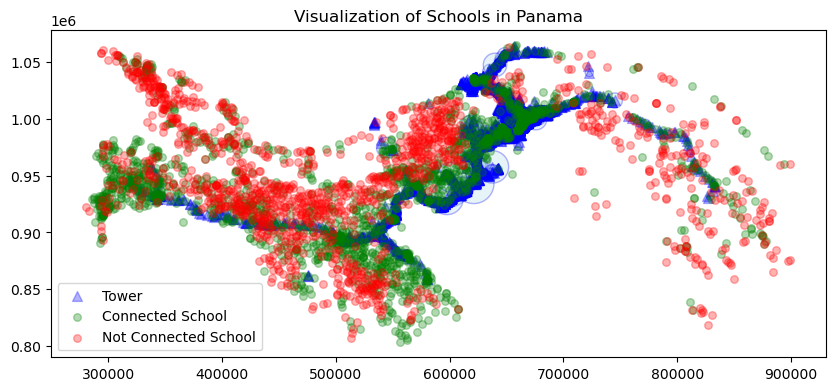

In [14]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the tower coverage areas (polygons)
towers_coverage.plot(ax=ax, color='lightblue', alpha=0.3, edgecolor='blue', label='Tower Coverage')

# Plot the tower points themselves
towers_gdf.plot(ax=ax, color='blue', markersize=50, marker='^', label='Tower', alpha=.3)

# Plot schools:
# Covered schools (green)
schools_gdf[schools_gdf['Connected'] == True].plot(ax=ax, color='green', markersize=30, alpha=.3, label='Connected School')
# Uncovered schools (red)
schools_gdf[schools_gdf['Connected'] == False].plot(ax=ax, color='red', markersize=30, alpha=.3, label='Not Connected School')

plt.title(f"Visualization of Schools in {COUNTRY}")
plt.legend()
plt.show()

# Clustering

We now divide the schools into clusters. The clusters are made in such a way that schools from different clusters will never be able to connect to a school in another cluster (due to the distance).

In the next two code cells, we define all clusters and store them in `cluster_stats`. 

* If there is a cluster in which all schools are connected, we discard this cluster as there is nothing left to optimize for this cluster. This will improve performance later in this notebook.

In [15]:
# Helper Function that will be used in the next code cell
def create_proximity_graph(schools_gdf_local):
    """
    Creates a proximity graph for a given set of schools based on spatial proximity.

    Parameters:
    - schools_gdf_local (GeoDataFrame): Filtered GeoDataFrame containing school locations.
    - max_edge_distance (float): Maximum allowable distance for an edge between schools.

    Returns:
    - clusters_local (list of sets): List of connected components (clusters), each represented as a set of school indices.
    """
    _sindex = schools_gdf_local.sindex  # Spatial index for faster lookup
    local_graph = nx.Graph()

    # Add nodes (schools)
    for school_id in schools_gdf_local.index:
        local_graph.add_node(school_id)

    # Add edges based on proximity
    for school_id, _school_geom in zip(schools_gdf_local.index, schools_gdf_local.geometry):
        _possible_neighbors = list(_sindex.intersection(_school_geom.buffer(maximum_edge_distance).bounds))
        for neighbor_id in _possible_neighbors:
            if neighbor_id == school_id:
                continue  # Skip self-connection
            distance = _school_geom.distance(schools_gdf_local.loc[neighbor_id, 'geometry'])
            if distance <= maximum_edge_distance:
                local_graph.add_edge(school_id, neighbor_id)

    # Find connected components (clusters)
    clusters_local = list(nx.connected_components(local_graph))

    return clusters_local

def has_nearby_tower(school_geom, towers_gdf, extra=5000):
    """
        returns True if the school geometry is within (tower range + extra)
    """
    # Get candidate towers using the towers' spatial index
    candidate_idxs = list(towers_gdf.sindex.intersection(school_geom.buffer(extra).bounds))
    for idx in candidate_idxs:
        tower = towers_gdf.iloc[idx]
        effective_range = tower['range'] + extra  # effective range in meters
        if school_geom.distance(tower.geometry) <= effective_range:
            return True
    return False

def plot_clusters(clusters_list, title):
    """
    clusters_list: a list of dictionaries where each dict has a key "cluster_nodes"
                   which is a list of school indices.
    title: Title for the chart.
    """
    num_clusters = len(clusters_list)
    # Create a colormap with enough distinct colors
    cmap = plt.get_cmap('rainbow', num_clusters)

    _fig, _ax = plt.subplots(figsize=(10, 10))
    for _i, _cluster in enumerate(clusters_list):
        # Get the list of school indices in the cluster
        cluster_indices = list(_cluster["cluster_nodes"])
        # Extract the geometries of these schools
        cluster_points = filtered_schools_gdf.loc[cluster_indices]
        # Plot these points with a distinct color
        cluster_points.plot(
            ax=_ax,
            marker='o',
            color=cmap(_i),
            markersize=20,
            alpha=.5,
            label=f"Cluster {_i + 1}"
        )
    _ax.set_title(title)
    plt.show()

In [16]:
# Make a copy of the original schools GeoDataFrame
all_schools_gdf = schools_gdf.copy()
total_schools = len(all_schools_gdf)

# Separate connected and disconnected schools
connected_mask = all_schools_gdf['Connected']
disconnected_mask = ~all_schools_gdf['Connected']

connected_schools = all_schools_gdf[connected_mask].index
disconnected_schools = all_schools_gdf[disconnected_mask].index

# We want to keep:
#   - All disconnected schools,
#   - And only those connected schools that have at least one disconnected neighbor within 5 km.
to_keep = set(disconnected_schools)  # keep all disconnected schools

# Build a spatial index on the full DataFrame
all_sindex = all_schools_gdf.sindex

for c in connected_schools:
    c_geom = all_schools_gdf.loc[c, 'geometry']
    # Get candidates within 5 km of this connected school
    possible_neighbors = list(all_sindex.intersection(c_geom.buffer(maximum_edge_distance).bounds))
    has_disconnected_neighbor = False
    for nbr_idx in possible_neighbors:
        if nbr_idx in disconnected_schools:
            dist = c_geom.distance(all_schools_gdf.loc[nbr_idx, 'geometry'])
            if dist <= maximum_edge_distance:
                has_disconnected_neighbor = True
                break
    if has_disconnected_neighbor:
        to_keep.add(c)

# Filter the GeoDataFrame to keep only relevant schools.
filtered_schools_gdf = all_schools_gdf.loc[list(to_keep)].copy()
# Reset the index so that our spatial index uses a continuous RangeIndex
filtered_schools_gdf = filtered_schools_gdf.reset_index(drop=True)

print(f"After filtering, total schools: {len(filtered_schools_gdf)}")

clusters_all = create_proximity_graph(filtered_schools_gdf)

# Prepare statistics and also store (cluster_id, node, closest_neighbor, distance)
clusters_stats = []
isolated_clusters_count = 0
cluster_neighbors_data = []

for idx, cluster in enumerate(clusters_all, start=1):
    cluster_list = list(cluster)
    cluster_size = len(cluster_list)

    if cluster_size == 1:
        isolated_clusters_count += 1
    else:
        # Count how many are connected vs not connected
        connected_count = filtered_schools_gdf.loc[cluster_list, 'Connected'].sum()
        not_connected_count = cluster_size - connected_count

        clusters_stats.append({
            "cluster_id": idx,
            "total_nodes": cluster_size,
            "connected_schools": connected_count,
            "not_connected_schools": not_connected_count
        })

        # For each node in this cluster, find the closest neighbor in the same cluster
        for node_id in cluster_list:
            node_geom = filtered_schools_gdf.loc[node_id, 'geometry']
            min_dist = float('inf')
            closest_neighbor = None
            for other_id in cluster_list:
                if other_id == node_id:
                    continue
                d = node_geom.distance(filtered_schools_gdf.loc[other_id, 'geometry'])
                if d < min_dist:
                    min_dist = d
                    closest_neighbor = other_id

            cluster_neighbors_data.append({
                "cluster_id": idx,
                "node_id": node_id,
                "closest_neighbor": closest_neighbor,
                "distance_m": min_dist
            })

clusters_stats_df = pd.DataFrame(clusters_stats).sort_values("total_nodes", ascending=False).reset_index(drop=True)
clusters_stats_df.index = clusters_stats_df.index + 1
clusters_stats_df.index.name = "stats_id"

print("Clusters with 2 or more nodes:")
display(clusters_stats_df.head(5))
print(f"Number of isolated clusters (1 node): {isolated_clusters_count}")

df_cluster_neighbors = pd.DataFrame(cluster_neighbors_data)
df_cluster_neighbors = df_cluster_neighbors.sort_values(["cluster_id", "node_id"]).reset_index(drop=True)

print("\nClosest Neighbor Info for Clusters >= 2 nodes:")
display(df_cluster_neighbors.head(5))

After filtering, total schools: 2213
Clusters with 2 or more nodes:


cluster_id  total_nodes  connected_schools  not_connected_schools
stats_id                                                                   
1                 83          792                322                    470
2                 88          339                118                    221
3                109          158                120                     38
4                147          131                 30                    101
5                111           90                 37                     53

Number of isolated clusters (1 node): 77

Closest Neighbor Info for Clusters >= 2 nodes:


cluster_id  node_id  closest_neighbor   distance_m
0           1        0                 1  1666.210485
1           1        1                 0  1666.210485
2           1       72                 1  2199.256477
3           2        2                 3   347.427247
4           2        3                 2   347.427247

### Classifying All Disconnected Clusters and Mixed Connection Clusters

Using the identified clusters in from the previous code block, we now divide the clusters into two groups:
* **all_disconnected clusters**: Clusters for which all schools within the cluster are disconnected. For thes type of clusters we need to place a tower somewhere inside the cluster to connect one or more schools, which can then connect to other schools using point-to-point connections.
* **mixed clusters**: Clusters in which some schools are connected and others are disconnected. For these clusters we first try to connect as many schools as possible to already connected schools using point-to-point connections. If there are remaining unconnected schools within a mixed cluster after the first optimization, we will consider placing a tower somewhere in order to connect the remaining schools.

In [17]:
# Prepare lists to hold cluster info for each category, ignoring 1-node clusters
all_disconnected_clusters = []
mixed_clusters = []

# For each cluster, compute the stats and categorize (skip clusters with 1 node)
for cluster in clusters_all:
    cluster_ids = list(cluster)
    cluster_size = len(cluster_ids)
    if cluster_size == 1:
        continue  # Skip isolated clusters

    # Sum boolean values: True counts as 1, False as 0
    connected_count = filtered_schools_gdf.loc[cluster_ids, 'Connected'].sum()
    not_connected_count = cluster_size - connected_count

    cluster_info = {
        "cluster_nodes": cluster_ids,
        "total_nodes": cluster_size,
        "connected_schools": connected_count,
        "not_connected_schools": not_connected_count
    }

    if connected_count == 0:
        # All schools are disconnected
        all_disconnected_clusters.append(cluster_info)
    else:
        # Mixed connectivity
        mixed_clusters.append(cluster_info)

# Convert lists to DataFrames
df_all_disconnected = pd.DataFrame(all_disconnected_clusters)
df_mixed = pd.DataFrame(mixed_clusters)

df_all_disconnected.index = df_all_disconnected.index + 1
df_all_disconnected.index.name = "cluster_id"

df_mixed.index = df_mixed.index + 1
df_mixed.index.name = "cluster_id"

We now visualize the identified **disconnected** and **Mixed connectivity** clusters

Total clusters (all clusters): 201
All disconnected clusters (>1 node): 51
Mixed clusters (>1 node): 73 



### Clusters with all schools disconnected:

total_nodes  connected_schools  not_connected_schools
cluster_id                                                       
1                     3                  0                      3
2                     2                  0                      2
3                     4                  0                      4
4                     3                  0                      3
5                     2                  0                      2

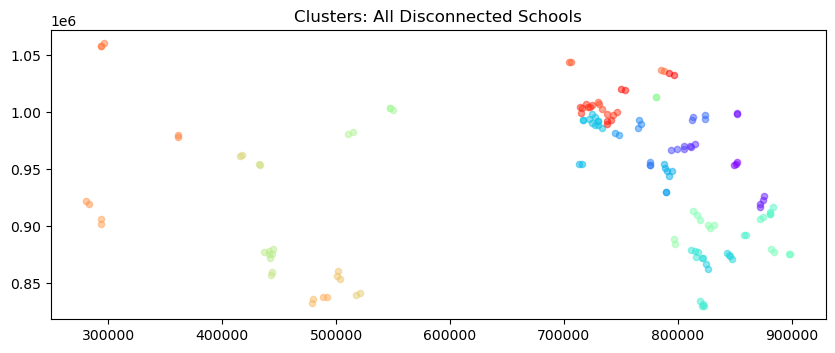

### Clusters with mixed connectivity:

total_nodes  connected_schools  not_connected_schools
cluster_id                                                       
1                     3                  1                      2
2                     2                  1                      1
3                    22                 11                     11
4                    16                  7                      9
5                     2                  1                      1

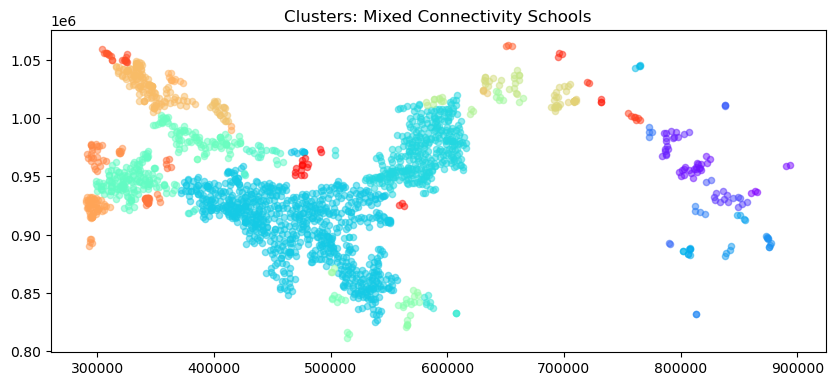

In [18]:
print(f"Total clusters (all clusters): {len(clusters_all)}")
print(f"All disconnected clusters (>1 node): {len(df_all_disconnected)}")
print(f"Mixed clusters (>1 node): {len(df_mixed)} \n")

if len(df_all_disconnected) > 0:
    display(Markdown(f"### Clusters with all schools disconnected:"))
    display(df_all_disconnected[['total_nodes', 'connected_schools', 'not_connected_schools']].head(5))
    plot_clusters(all_disconnected_clusters, "Clusters: All Disconnected Schools")

if len(df_mixed) > 0:
    display(Markdown(f"### Clusters with mixed connectivity:"))
    display(df_mixed[['total_nodes', 'connected_schools', 'not_connected_schools']].head(5))
    plot_clusters(mixed_clusters, "Clusters: Mixed Connectivity Schools")

## Classifying Trivial Clusters
To speed up the runtime of the algorithm, we will classify the trivial clusters in the cluster set.

More specifically we will look for the following clusters:
* **Isolated disconnected clusters**: These clusters consist of one school that is disconnected. The only option for these clusters is to place a cellular tower or some sattelite connection.
* **Multi-node disconnected clusters**: These clusters have more than one node (school) and every school is disconnected

For the **Multi-node disconnected cluster** we check if a celltower is nearby. The results of this check will be used further in the notebook.

In [19]:
# 1. Process isolated disconnected clusters (clusters with one node)
isolated_disconnected = []
for cluster in clusters_all:
    if len(cluster) == 1:
        node = list(cluster)[0]
        # Check if this single node is disconnected
        if not filtered_schools_gdf.loc[node, 'CoveredByTower']:
            isolated_disconnected.append(cluster)

# Check each isolated disconnected node for nearby tower presence
isolated_results = []
for cluster in isolated_disconnected:
    node = list(cluster)[0]
    school_geom = filtered_schools_gdf.loc[node, 'geometry']
    nearby = has_nearby_tower(school_geom, towers_gdf, extra=5000)
    isolated_results.append({
       'node': node,
       'has_nearby_tower': nearby
    })

df_isolated = pd.DataFrame(isolated_results)
df_isolated.index = df_isolated.index + 1
df_isolated.index.name = "isolated_cluster_id"

# -------------------------------------
# 2. Process disconnected clusters with more than one node.
# We define these as clusters (with >1 node) where every school is disconnected.
multi_disconnected = []
for cluster in clusters_all:
    if len(cluster) > 1:
        # Check if all schools in the cluster are disconnected:
        if all(filtered_schools_gdf.loc[node, 'CoveredByTower'] == False for node in cluster):
            multi_disconnected.append(cluster)

# Check each multi-node disconnected cluster for nearby tower presence.
multi_results = []
for cluster in multi_disconnected:
    nodes = list(cluster)
    near_count = 0
    for node in nodes:
        school_geom = filtered_schools_gdf.loc[node, 'geometry']
        if has_nearby_tower(school_geom, towers_gdf, extra=5000):
            near_count += 1
    multi_results.append({
         'cluster_nodes': nodes,
         'total_nodes': len(nodes),
         'nearby_tower_count': near_count,
         'has_nearby_tower': (near_count > 0)
    })

df_multi = pd.DataFrame(multi_results)
df_multi.index = df_multi.index + 1
df_multi.index.name = "cluster_id"

# -------------------------------------
# Display results:
print("Isolated disconnected clusters (1-node) with nearby tower check:")
display(df_isolated)

print("Multi-node disconnected clusters with nearby tower check:")
display(df_multi)


Isolated disconnected clusters (1-node) with nearby tower check:


node  has_nearby_tower
isolated_cluster_id                        
1                      44             False
2                      45             False
3                      46             False
4                      70             False
5                      71             False
...                   ...               ...
73                   2039             False
74                   2059             False
75                   2072             False
76                   2119             False
77                   2208             False

[77 rows x 2 columns]

Multi-node disconnected clusters with nearby tower check:


cluster_nodes  total_nodes  \
cluster_id                                                                   
1                                                  [0, 1, 72]            3   
2                                                      [2, 3]            2   
3                                                   [4, 5, 6]            3   
4                                            [8, 162, 163, 7]            4   
5                                                     [9, 10]            2   
...                                                       ...          ...   
100                                              [2070, 2071]            2   
101                                              [2074, 2075]            2   
102                                        [2129, 2130, 2131]            3   
103         [2211, 2212, 2185, 2186, 2187, 2168, 2169, 217...           13   
104                                              [2201, 2202]            2   

            nearby_tower_count  has_nearby_tower  
cluster_id                                        
1                            0             False  
2                            0             False  
3                            0             False  
4                            0             False  
5                            0             False  
...                        ...               ...  
100                          0             False  
101                          0             False  
102                          0             False  
103                          0             False  
104                          0             False  

[104 rows x 4 columns]

# Optimizing the connectivity between schools in the same clusters

We will now solve a graph optimization problem in which we find optimal point-to-point connections between connected schools and neighbouring non connected schools.

For each cluster, we will solve a Integer Linear Program (ILP) that will find the optimal point-to-point connections between schools.

We define the following constraints for the ILP:
1. Each non-connected school must get exactly one incoming connection.
2. Each edge (point-to-point connection) can be at most `maximum_edge_distance` in distance.
3. Each school can have at most `Y_capacity` outgoing connections.
4. Hop count constraints: When for example *SchoolA* has a point-to-point connection with *SchoolB*, this is counted as one hop. There can be at most `maximum_hops` (defined in the configuration variables at the top of the notebook hops form a connected node.

The objective of the ILP is to minimize the total point-to-point connection distance.

## Mixed-Connectivity Clusters : Initial Optimization Sweep
The following code block will try to solve the ILP for each cluster with a configurable timeout of `ilp_timeout` (60 seconds).

If the ILP turns out to be infeasible (not solvable) for the cluster or if solving takes longer than `ilp_timeout`, the cluster will be re-processed in a second sweep with more optimizations (see next code blocks).

Cluster 1: 3 nodes; using N = 3 nodes (Roots: 1, Disconnected: 2)


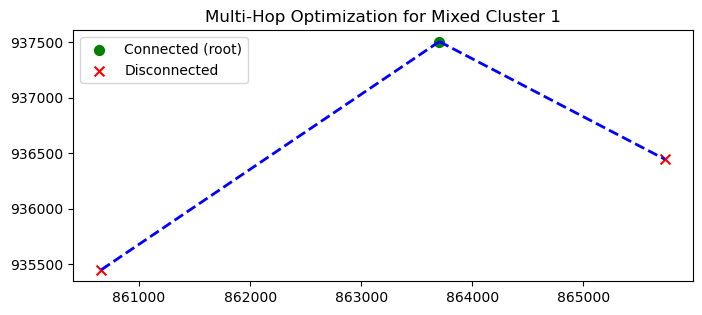

Cluster 2: 2 nodes; using N = 2 nodes (Roots: 1, Disconnected: 1)


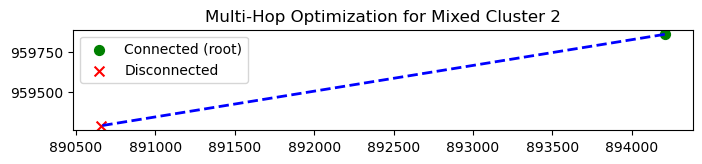

Cluster 3: 22 nodes; using N = 22 nodes (Roots: 11, Disconnected: 11)
Cluster 3 has no optimal solution; mark to reanalysis.
Cluster 4: 16 nodes; using N = 16 nodes (Roots: 7, Disconnected: 9)


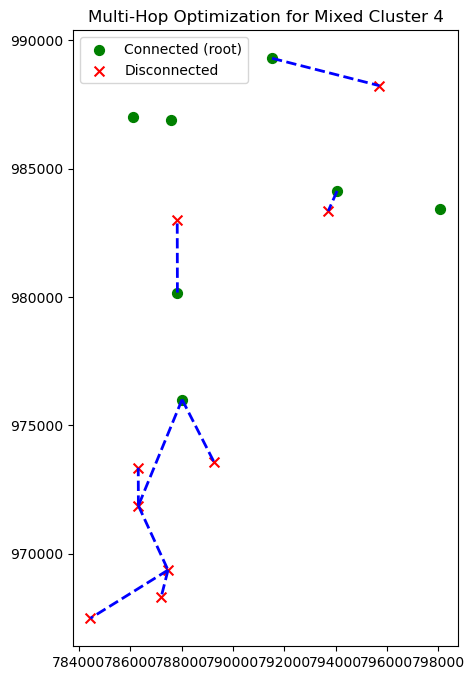

Cluster 5: 2 nodes; using N = 2 nodes (Roots: 1, Disconnected: 1)


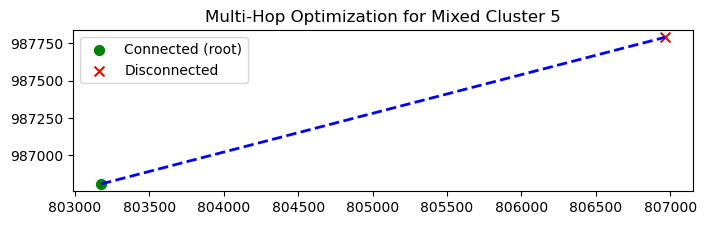

Cluster 6: 8 nodes; using N = 8 nodes (Roots: 3, Disconnected: 5)


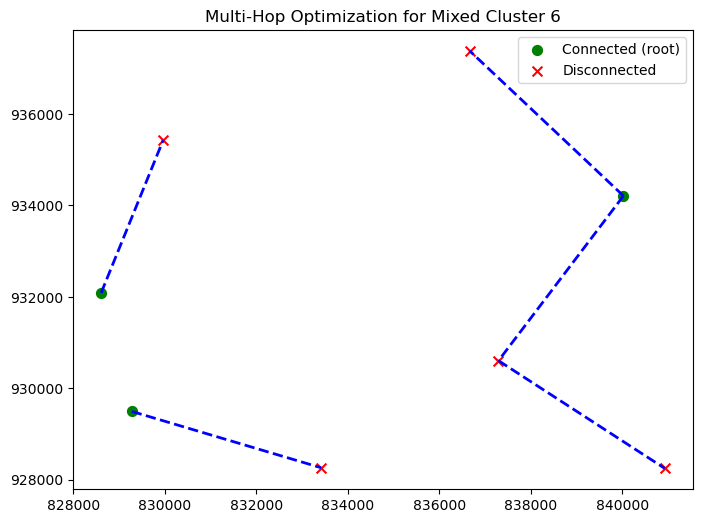

Cluster 7: 3 nodes; using N = 3 nodes (Roots: 1, Disconnected: 2)


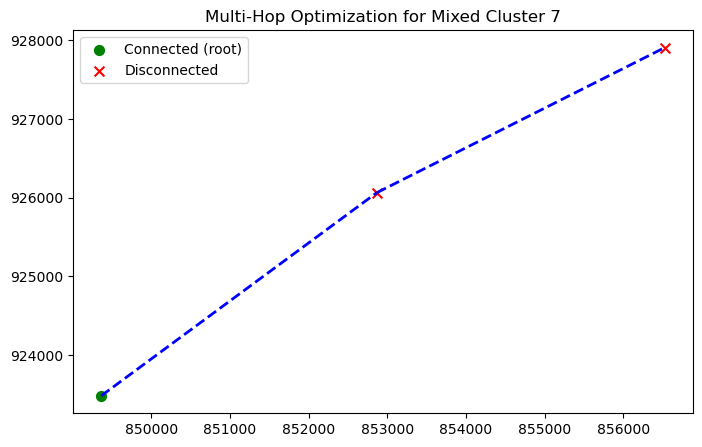

Cluster 8: 3 nodes; using N = 3 nodes (Roots: 2, Disconnected: 1)


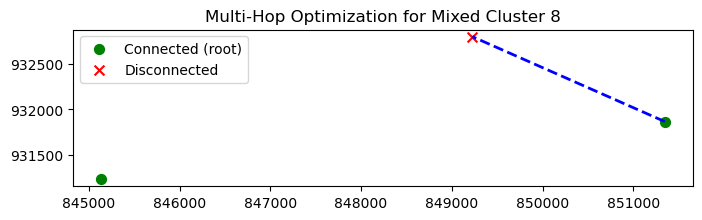

Cluster 9: 2 nodes; using N = 2 nodes (Roots: 1, Disconnected: 1)


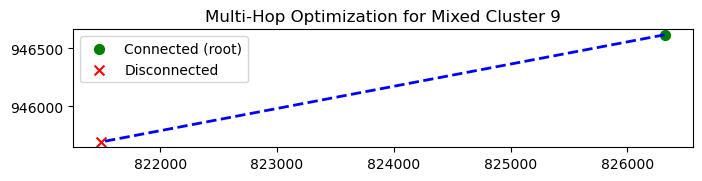

Cluster 10: 3 nodes; using N = 3 nodes (Roots: 1, Disconnected: 2)


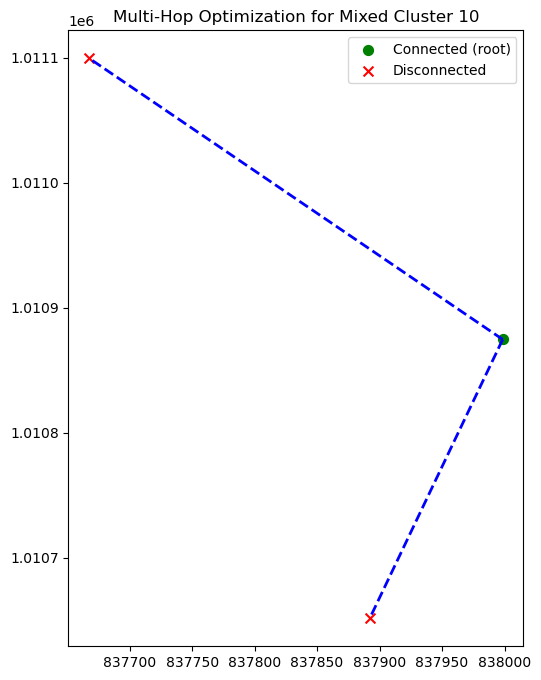

Cluster 11: 2 nodes; using N = 2 nodes (Roots: 1, Disconnected: 1)


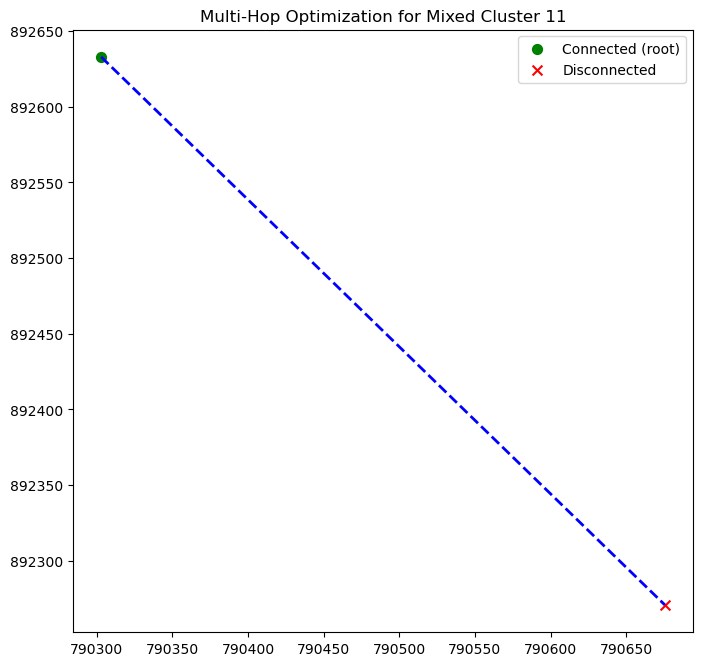

Cluster 12: 4 nodes; using N = 4 nodes (Roots: 1, Disconnected: 3)


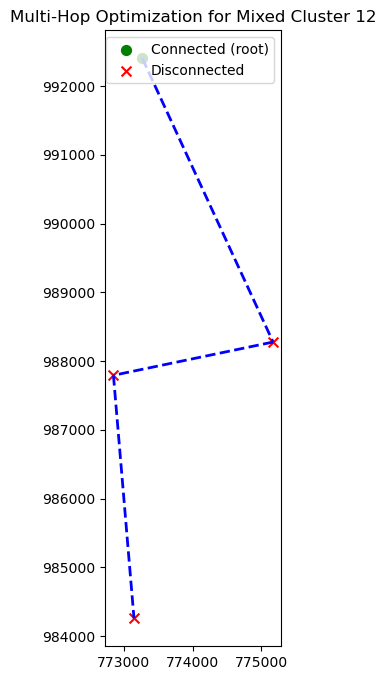

Cluster 13: 4 nodes; using N = 4 nodes (Roots: 1, Disconnected: 3)


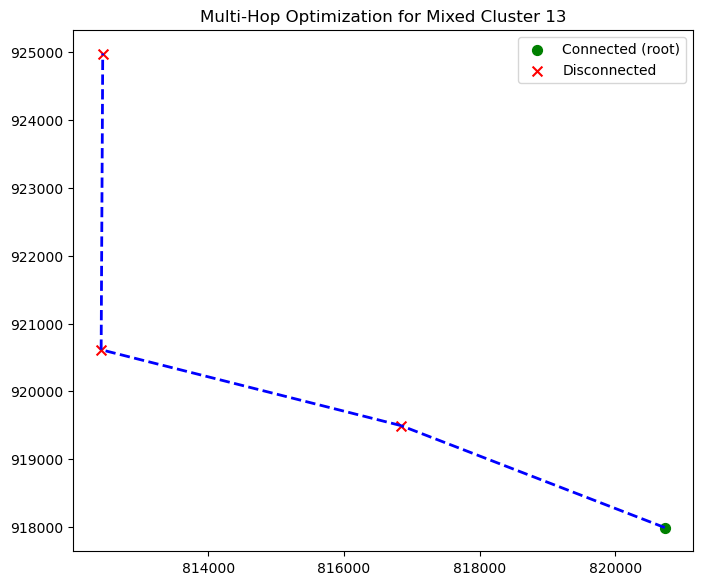

Cluster 14: 2 nodes; using N = 2 nodes (Roots: 1, Disconnected: 1)


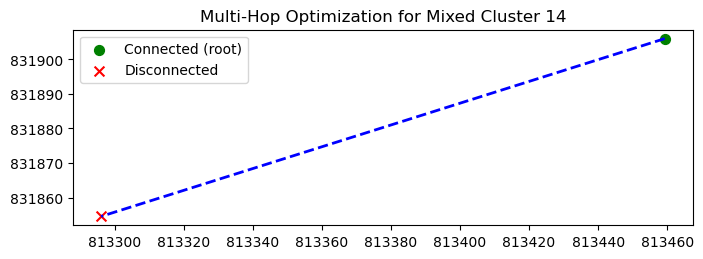

Cluster 15: 9 nodes; using N = 9 nodes (Roots: 6, Disconnected: 3)


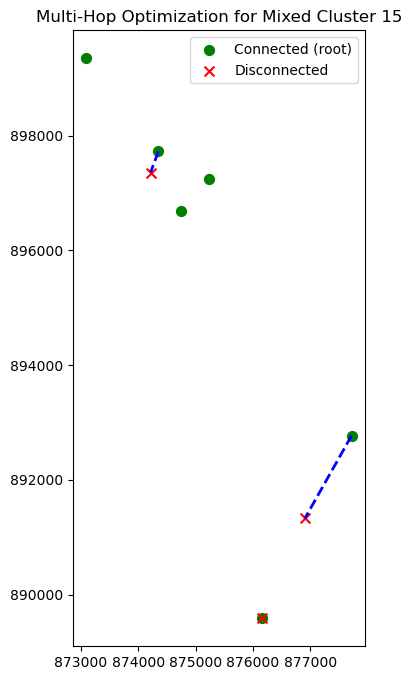

Cluster 16: 4 nodes; using N = 4 nodes (Roots: 2, Disconnected: 2)


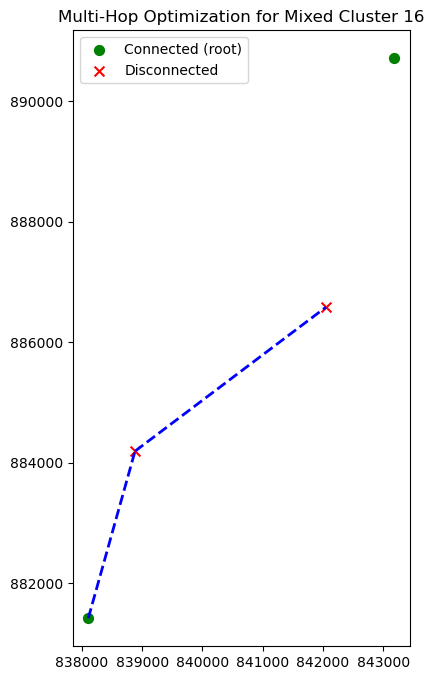

Cluster 17: 4 nodes; using N = 4 nodes (Roots: 2, Disconnected: 2)


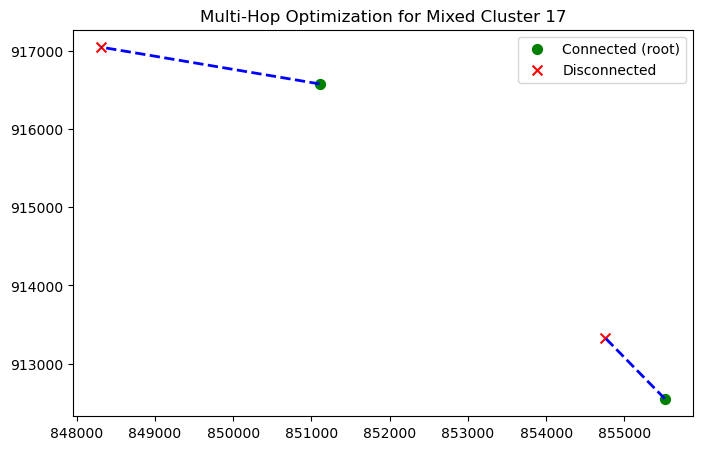

Cluster 18: 7 nodes; using N = 7 nodes (Roots: 3, Disconnected: 4)


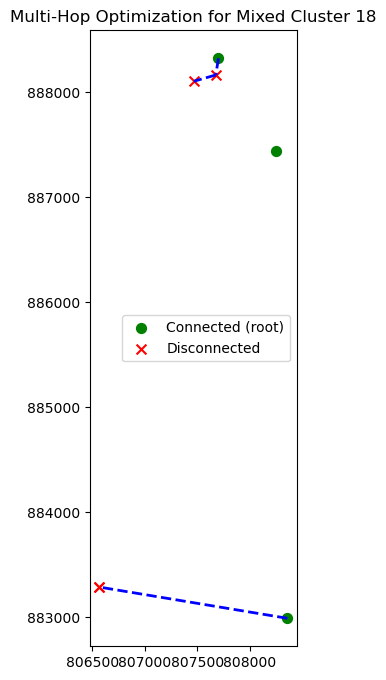

Cluster 19: 2 nodes; using N = 2 nodes (Roots: 1, Disconnected: 1)


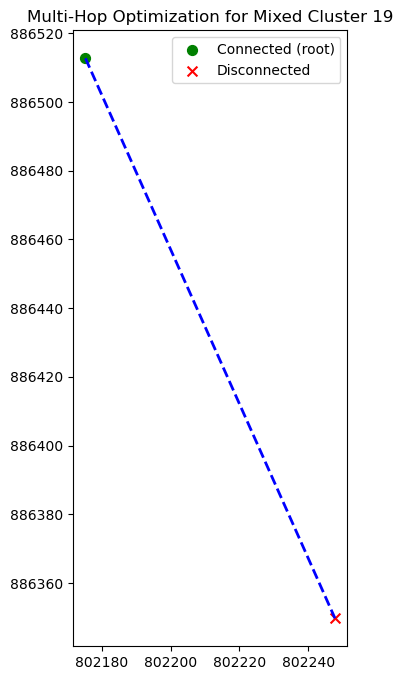

Cluster 20: 4 nodes; using N = 4 nodes (Roots: 3, Disconnected: 1)


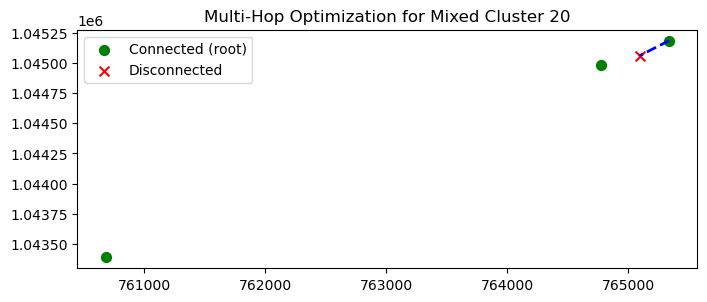

Cluster 21: 8 nodes; using N = 8 nodes (Roots: 1, Disconnected: 7)
Cluster 21 has no optimal solution; mark to reanalysis.
Cluster 22: 792 nodes; using N = 792 nodes (Roots: 322, Disconnected: 470)
Cluster 22 has no optimal solution; mark to reanalysis.
Cluster 23: 4 nodes; using N = 4 nodes (Roots: 3, Disconnected: 1)


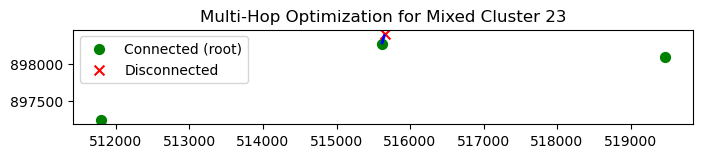

Cluster 24: 339 nodes; using N = 339 nodes (Roots: 118, Disconnected: 221)
Cluster 24 has no optimal solution; mark to reanalysis.
Cluster 25: 2 nodes; using N = 2 nodes (Roots: 1, Disconnected: 1)


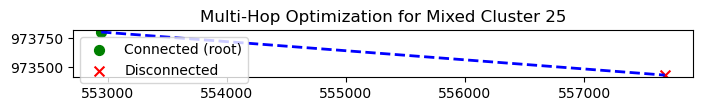

Cluster 26: 2 nodes; using N = 2 nodes (Roots: 1, Disconnected: 1)


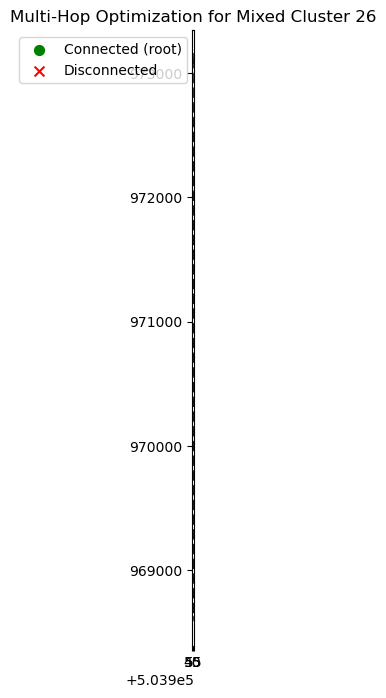

Cluster 27: 7 nodes; using N = 7 nodes (Roots: 3, Disconnected: 4)


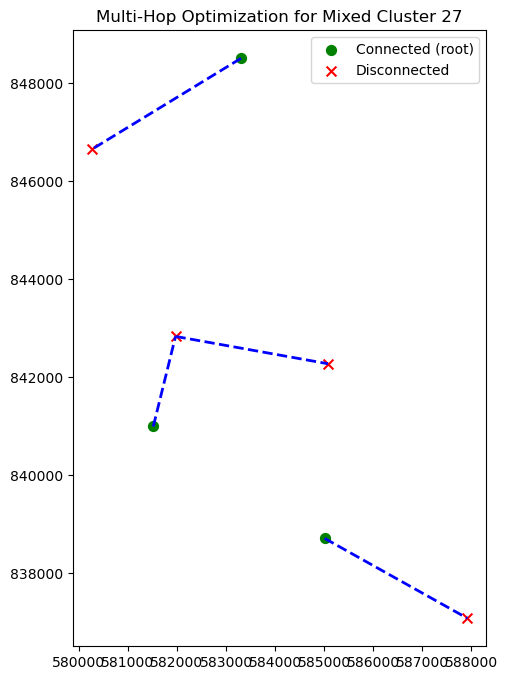

Cluster 28: 3 nodes; using N = 3 nodes (Roots: 2, Disconnected: 1)


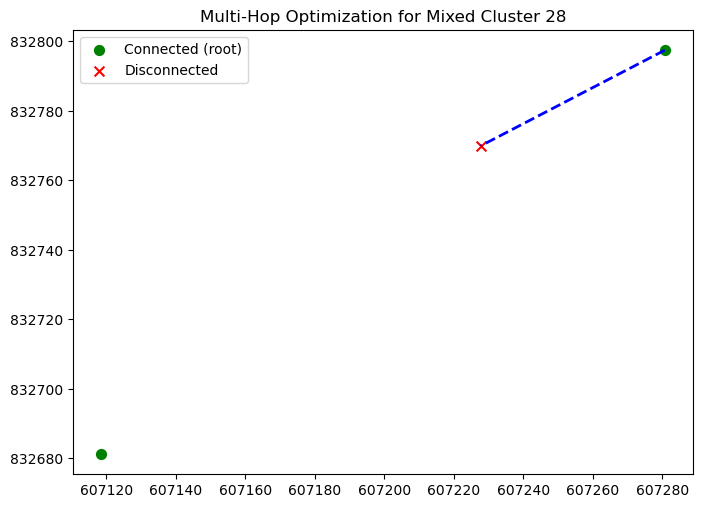

Cluster 29: 4 nodes; using N = 4 nodes (Roots: 2, Disconnected: 2)


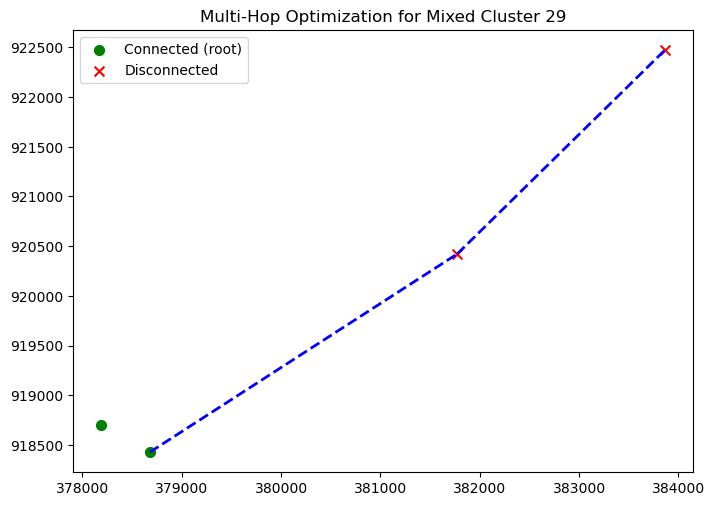

Cluster 30: 3 nodes; using N = 3 nodes (Roots: 1, Disconnected: 2)


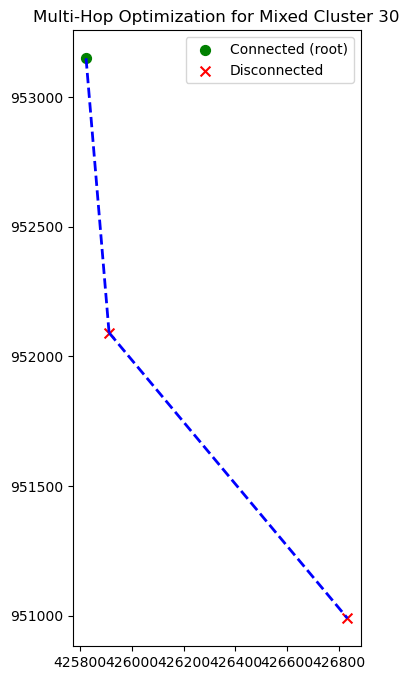

Cluster 31: 15 nodes; using N = 15 nodes (Roots: 6, Disconnected: 9)


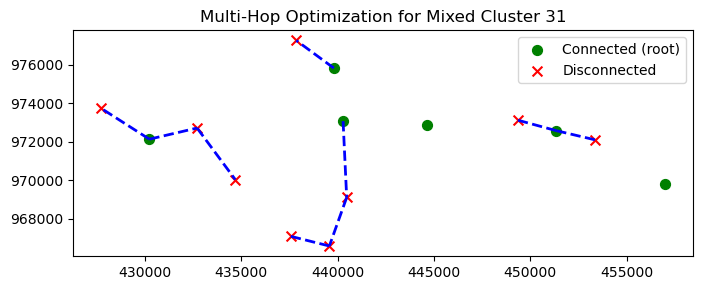

Cluster 32: 3 nodes; using N = 3 nodes (Roots: 1, Disconnected: 2)


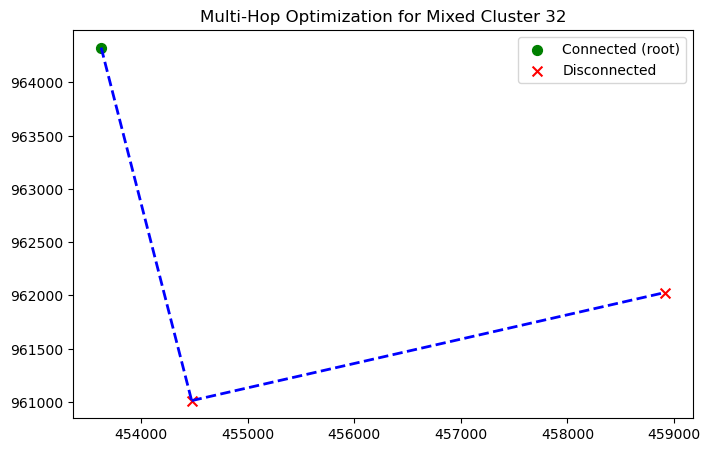

Cluster 33: 158 nodes; using N = 158 nodes (Roots: 120, Disconnected: 38)


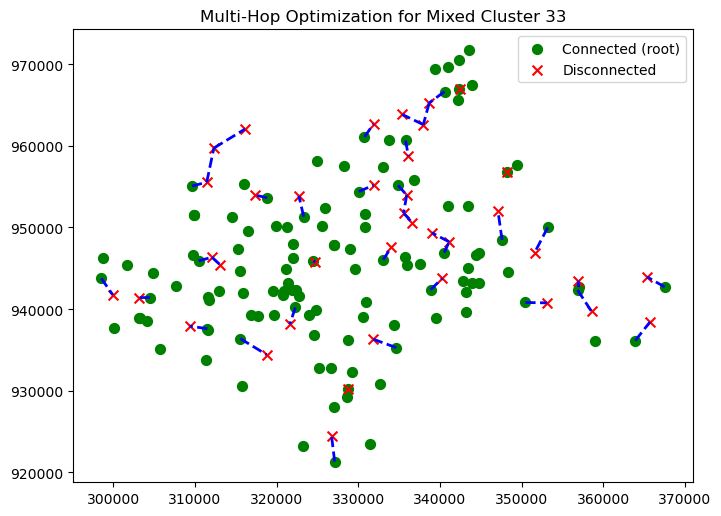

Cluster 34: 90 nodes; using N = 90 nodes (Roots: 37, Disconnected: 53)


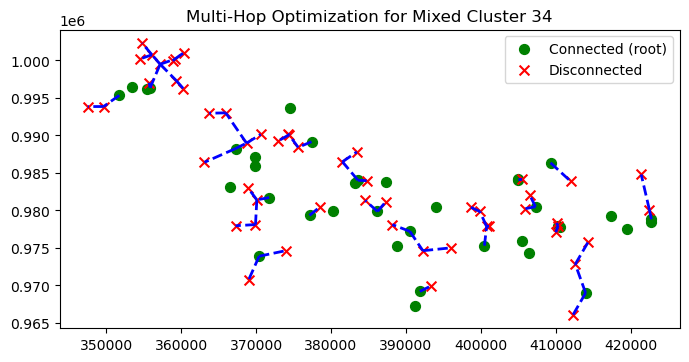

Cluster 35: 2 nodes; using N = 2 nodes (Roots: 1, Disconnected: 1)


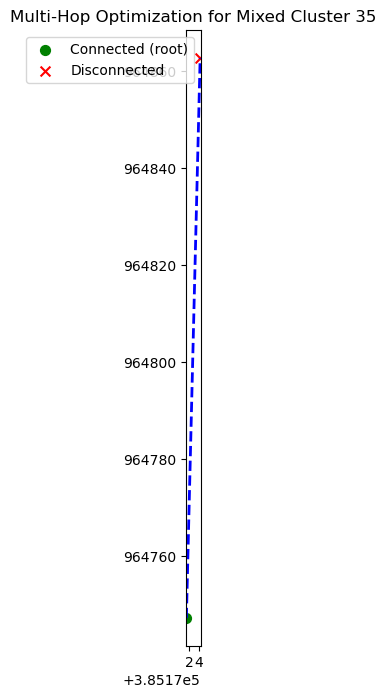

Cluster 36: 7 nodes; using N = 7 nodes (Roots: 1, Disconnected: 6)


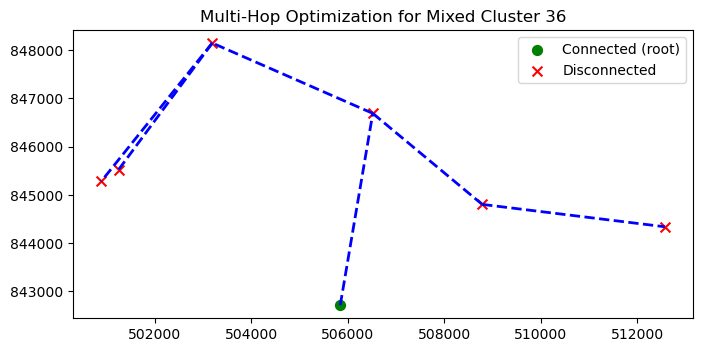

Cluster 37: 3 nodes; using N = 3 nodes (Roots: 1, Disconnected: 2)


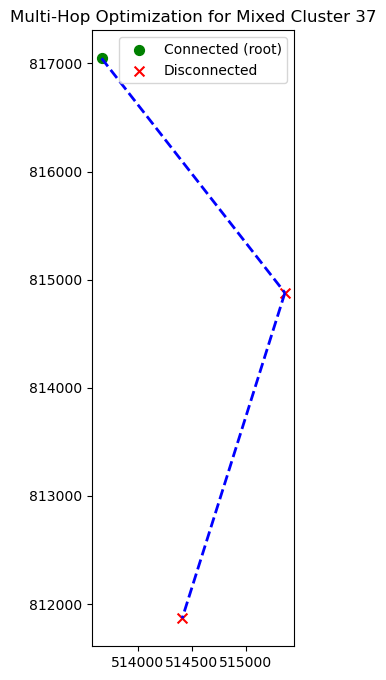

Cluster 38: 9 nodes; using N = 9 nodes (Roots: 5, Disconnected: 4)


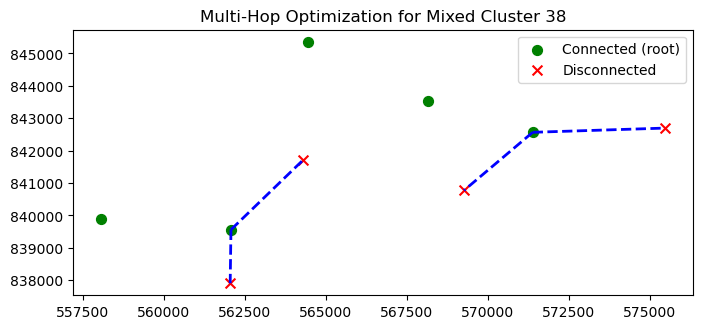

Cluster 39: 6 nodes; using N = 6 nodes (Roots: 2, Disconnected: 4)


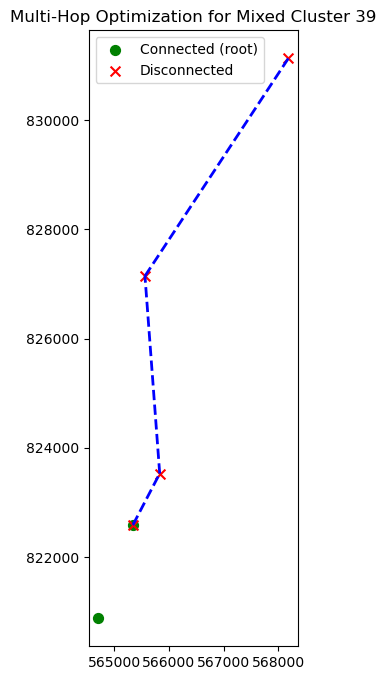

Cluster 40: 4 nodes; using N = 4 nodes (Roots: 2, Disconnected: 2)


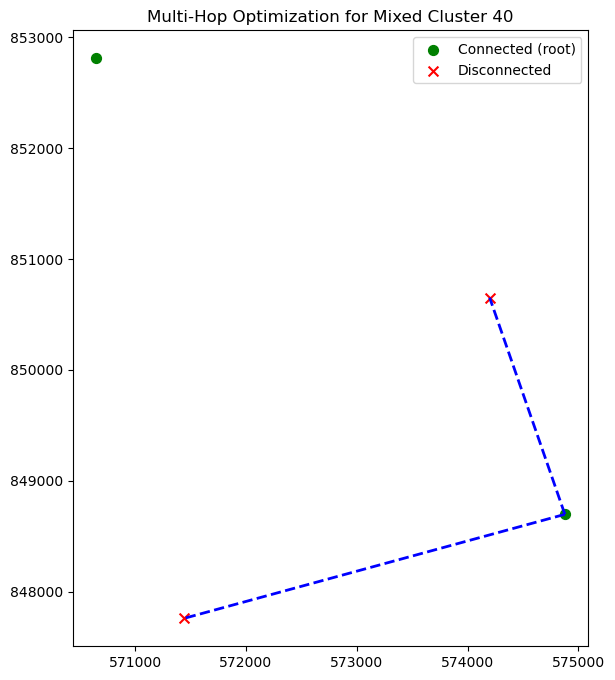

Cluster 41: 3 nodes; using N = 3 nodes (Roots: 1, Disconnected: 2)


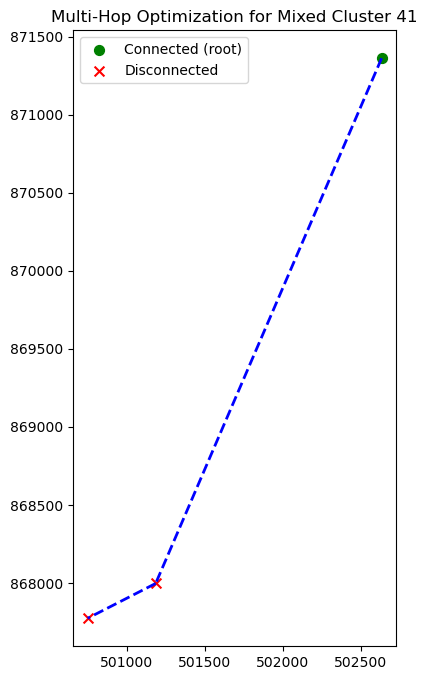

Cluster 42: 6 nodes; using N = 6 nodes (Roots: 4, Disconnected: 2)


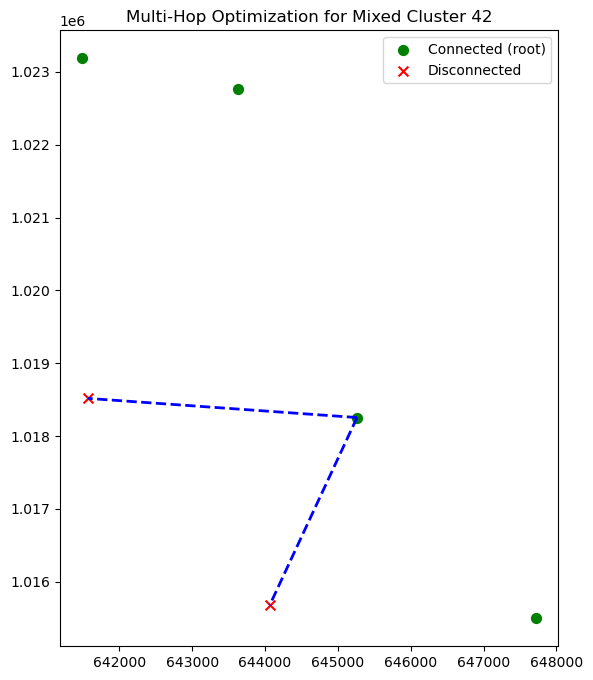

Cluster 43: 2 nodes; using N = 2 nodes (Roots: 1, Disconnected: 1)


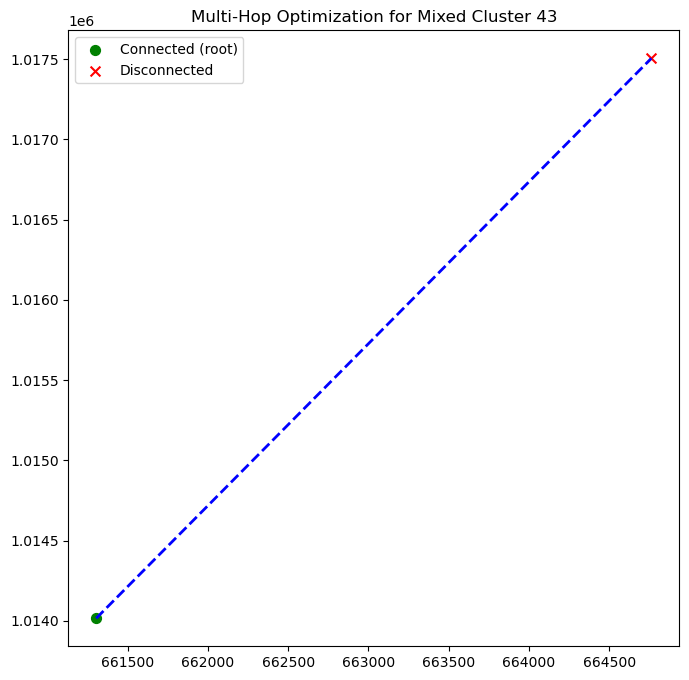

Cluster 44: 3 nodes; using N = 3 nodes (Roots: 2, Disconnected: 1)


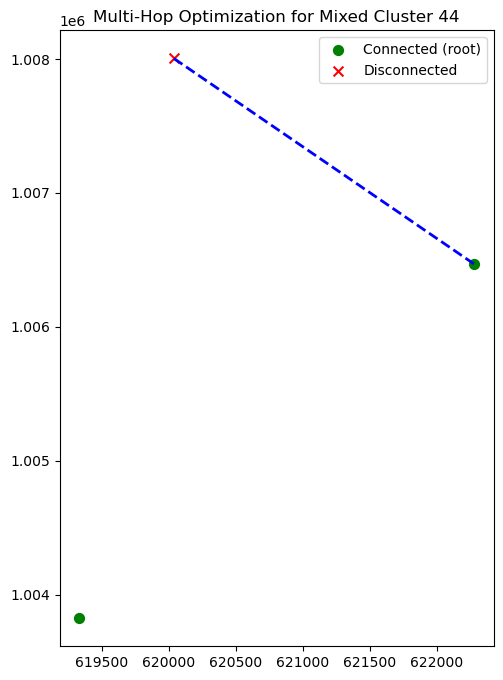

Cluster 45: 8 nodes; using N = 8 nodes (Roots: 3, Disconnected: 5)


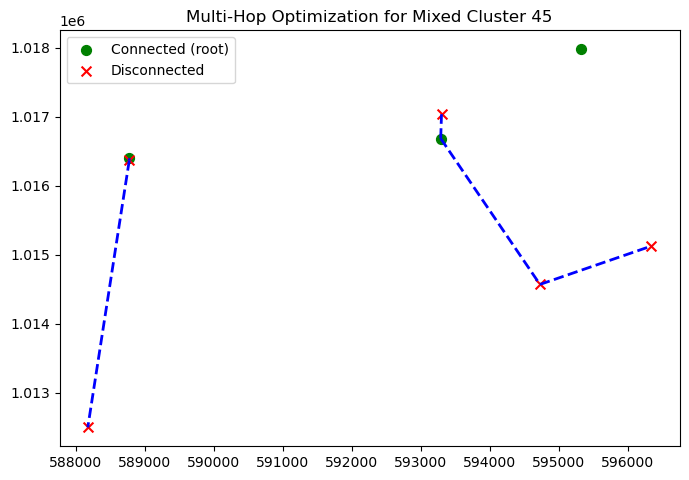

Cluster 46: 2 nodes; using N = 2 nodes (Roots: 1, Disconnected: 1)


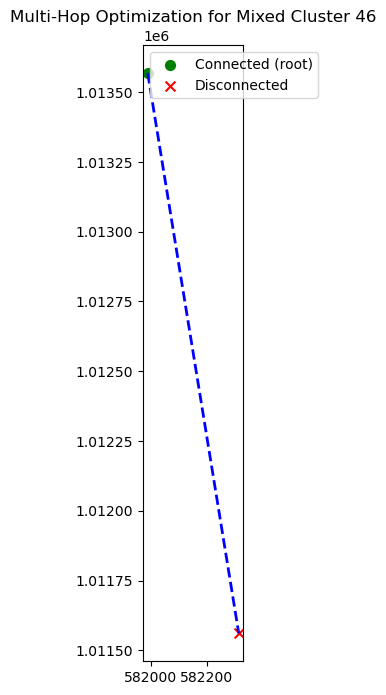

Cluster 47: 11 nodes; using N = 11 nodes (Roots: 3, Disconnected: 8)


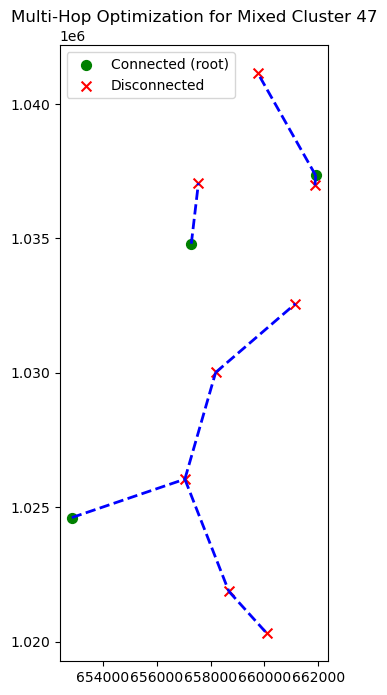

Cluster 48: 2 nodes; using N = 2 nodes (Roots: 1, Disconnected: 1)


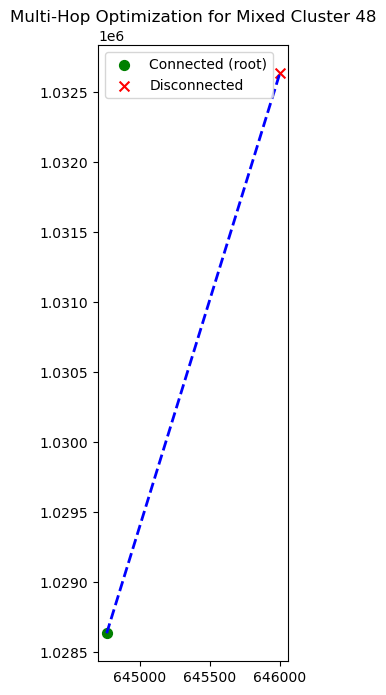

Cluster 49: 8 nodes; using N = 8 nodes (Roots: 6, Disconnected: 2)


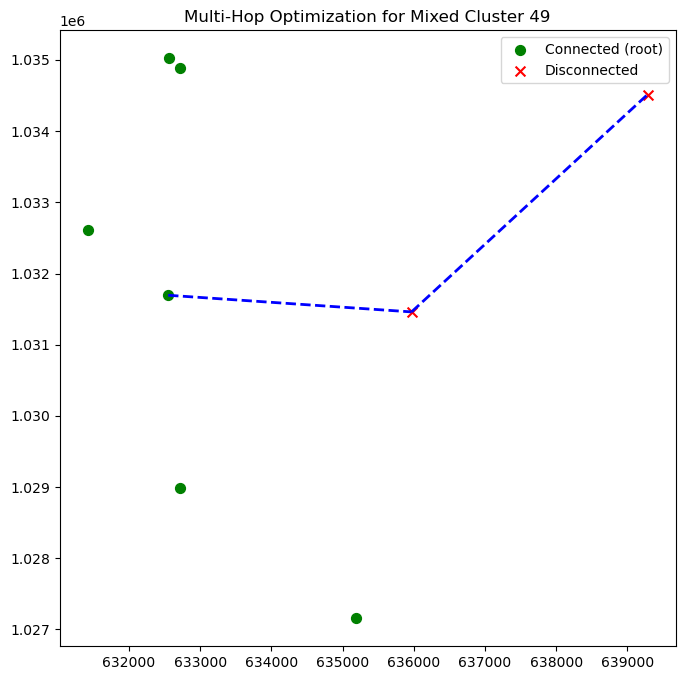

Cluster 50: 19 nodes; using N = 19 nodes (Roots: 12, Disconnected: 7)
Cluster 50 has no optimal solution; mark to reanalysis.
Cluster 51: 15 nodes; using N = 15 nodes (Roots: 14, Disconnected: 1)


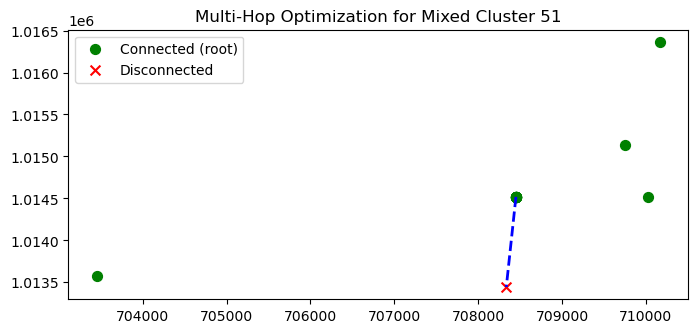

Cluster 52: 4 nodes; using N = 4 nodes (Roots: 2, Disconnected: 2)


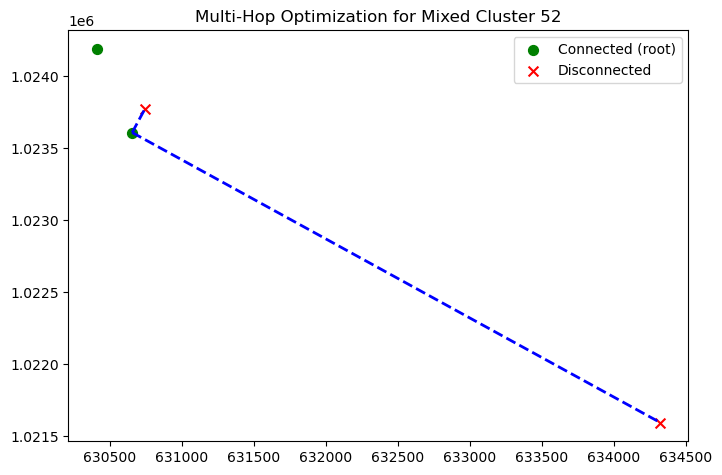

Cluster 53: 22 nodes; using N = 22 nodes (Roots: 7, Disconnected: 15)


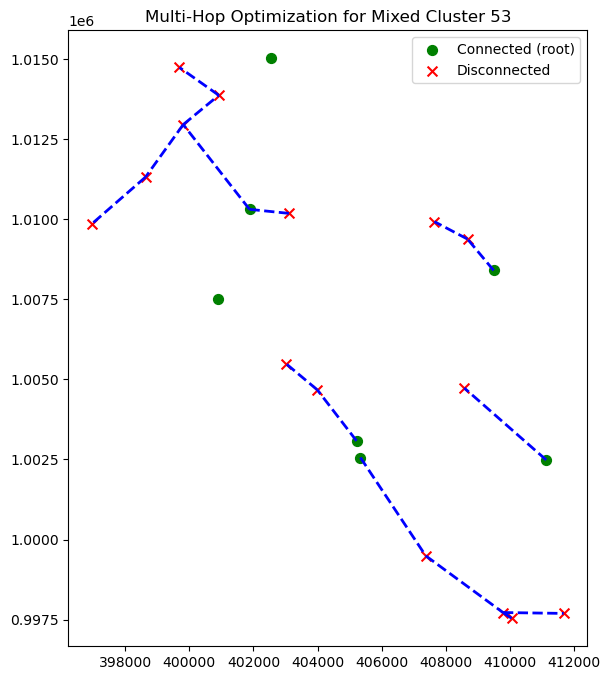

Cluster 54: 131 nodes; using N = 131 nodes (Roots: 30, Disconnected: 101)
Cluster 54 has no optimal solution; mark to reanalysis.
Cluster 55: 10 nodes; using N = 10 nodes (Roots: 5, Disconnected: 5)


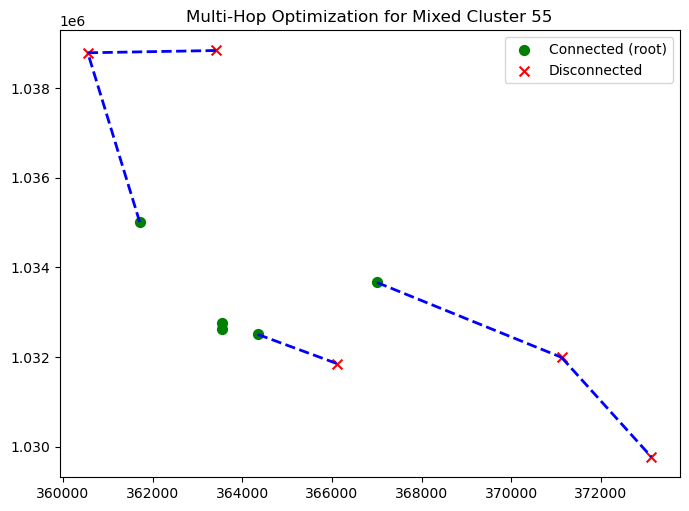

Cluster 56: 2 nodes; using N = 2 nodes (Roots: 1, Disconnected: 1)


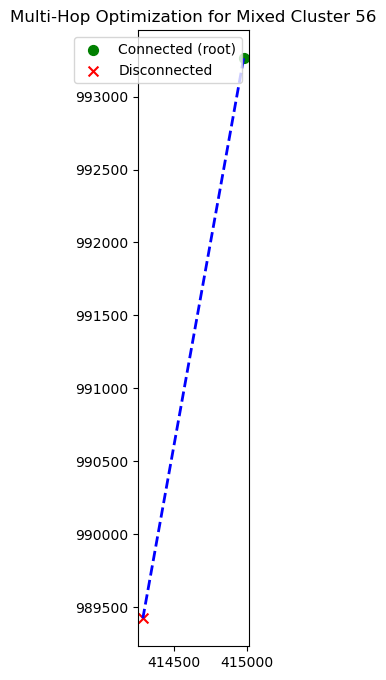

Cluster 57: 54 nodes; using N = 54 nodes (Roots: 47, Disconnected: 7)


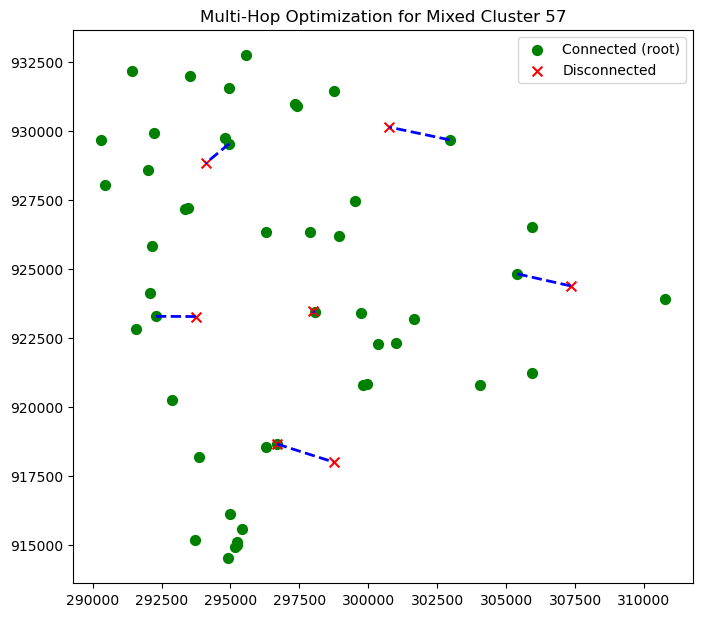

Cluster 58: 5 nodes; using N = 5 nodes (Roots: 4, Disconnected: 1)


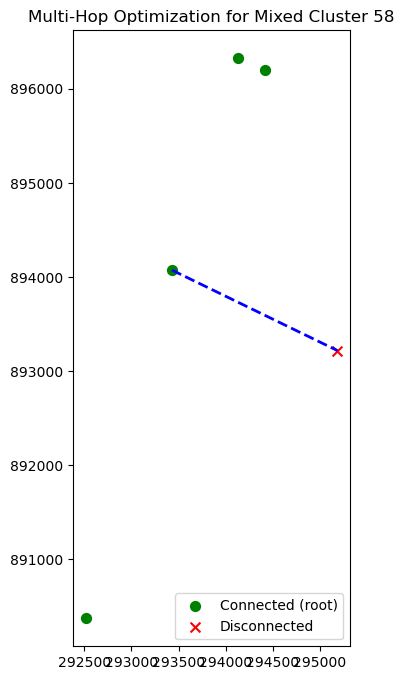

Cluster 59: 7 nodes; using N = 7 nodes (Roots: 6, Disconnected: 1)


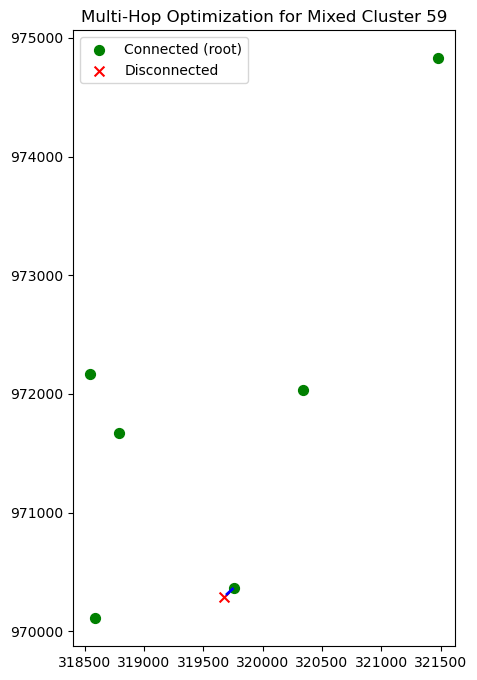

Cluster 60: 24 nodes; using N = 24 nodes (Roots: 16, Disconnected: 8)


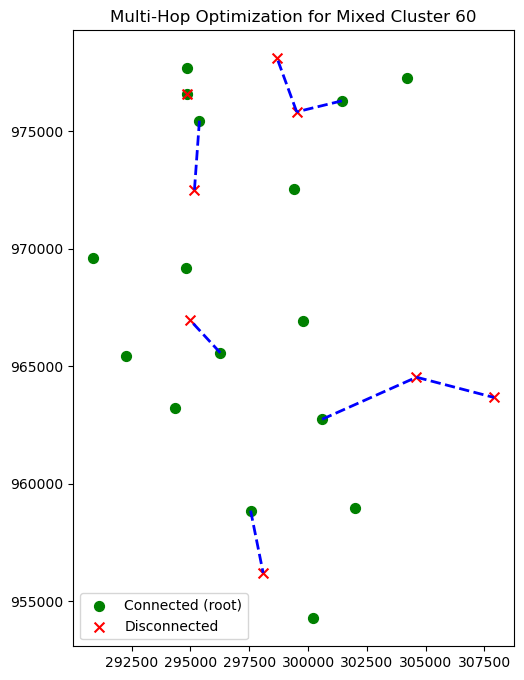

Cluster 61: 3 nodes; using N = 3 nodes (Roots: 2, Disconnected: 1)


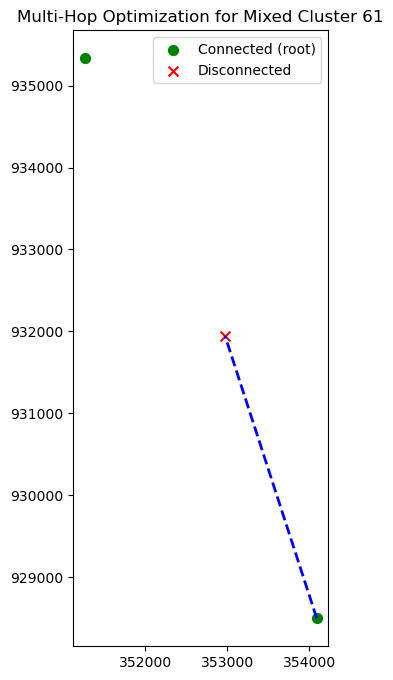

Cluster 62: 22 nodes; using N = 22 nodes (Roots: 21, Disconnected: 1)


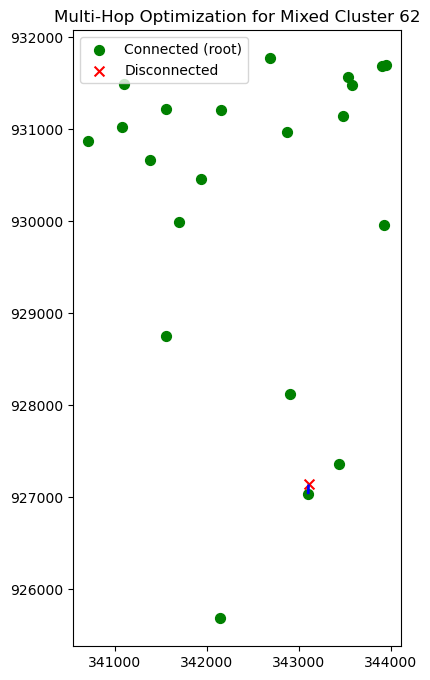

Cluster 63: 5 nodes; using N = 5 nodes (Roots: 3, Disconnected: 2)


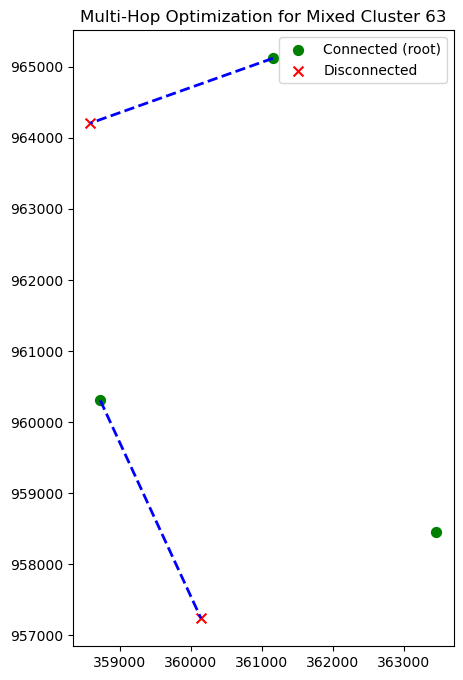

Cluster 64: 3 nodes; using N = 3 nodes (Roots: 2, Disconnected: 1)


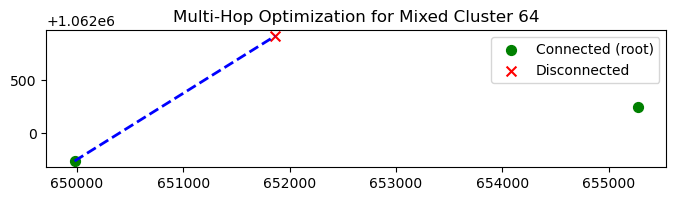

Cluster 65: 10 nodes; using N = 10 nodes (Roots: 4, Disconnected: 6)


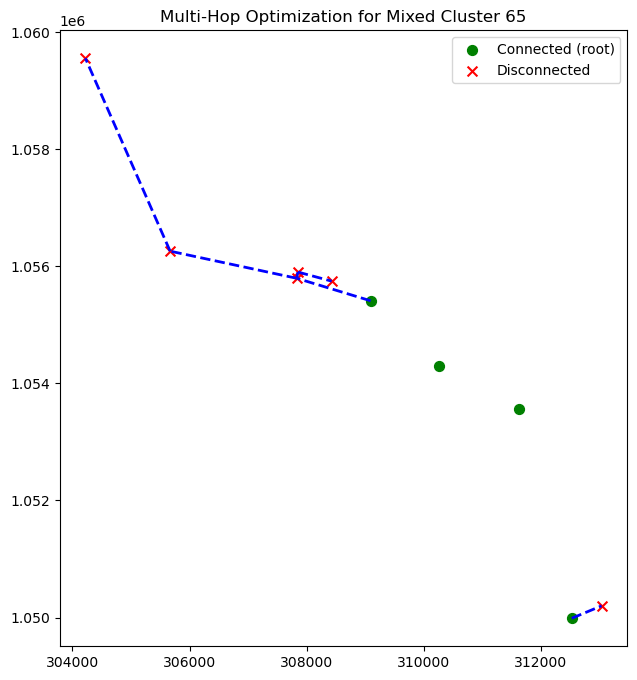

Cluster 66: 9 nodes; using N = 9 nodes (Roots: 6, Disconnected: 3)


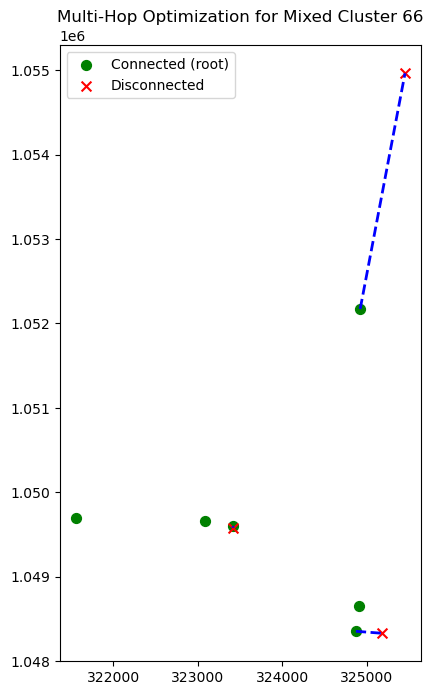

Cluster 67: 7 nodes; using N = 7 nodes (Roots: 4, Disconnected: 3)


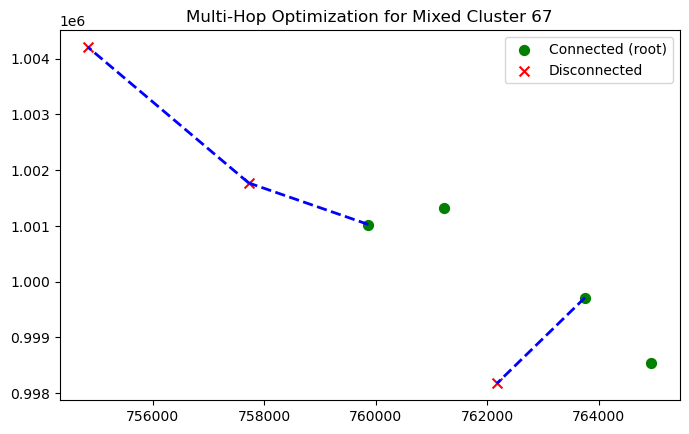

Cluster 68: 2 nodes; using N = 2 nodes (Roots: 1, Disconnected: 1)


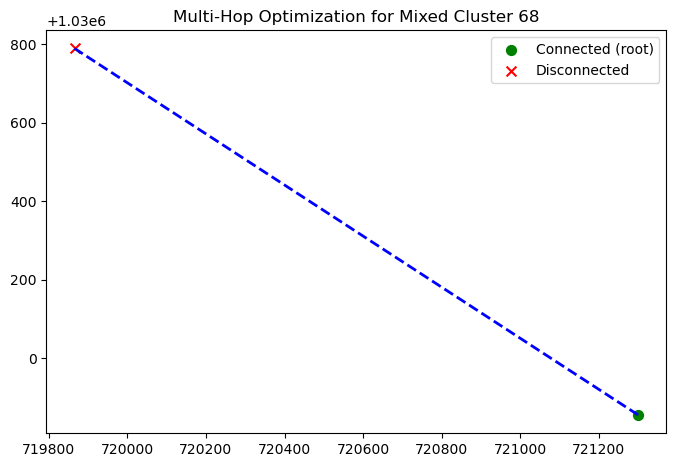

Cluster 69: 3 nodes; using N = 3 nodes (Roots: 2, Disconnected: 1)


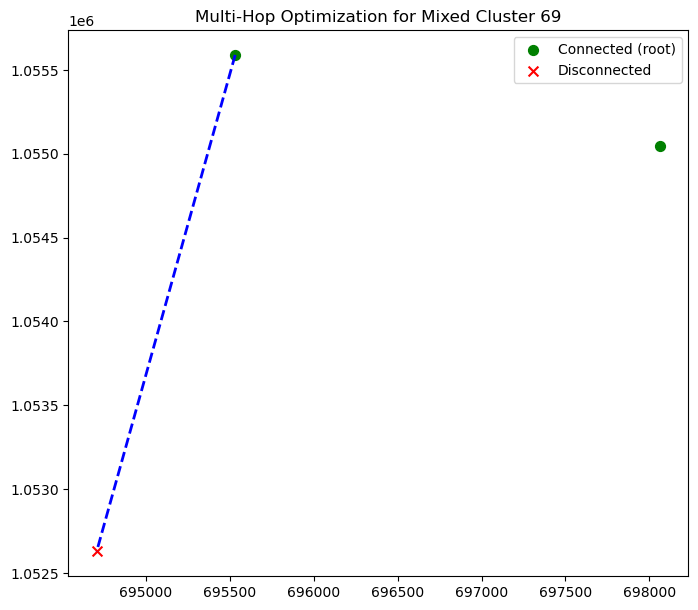

Cluster 70: 3 nodes; using N = 3 nodes (Roots: 2, Disconnected: 1)


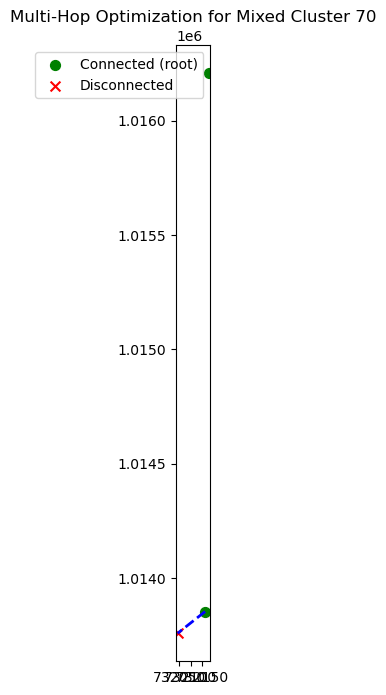

Cluster 71: 3 nodes; using N = 3 nodes (Roots: 1, Disconnected: 2)


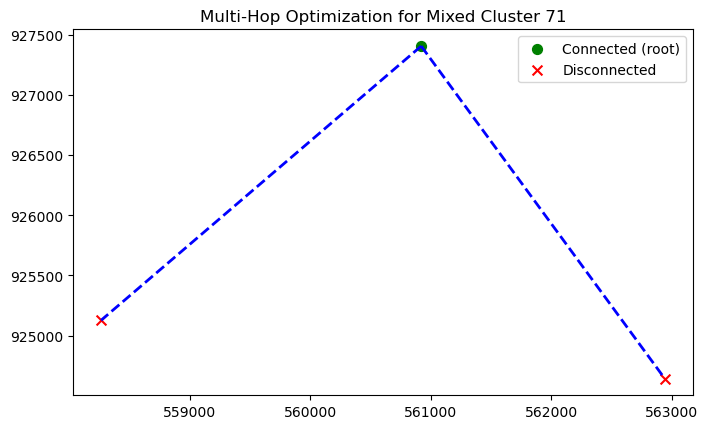

Cluster 72: 13 nodes; using N = 13 nodes (Roots: 6, Disconnected: 7)


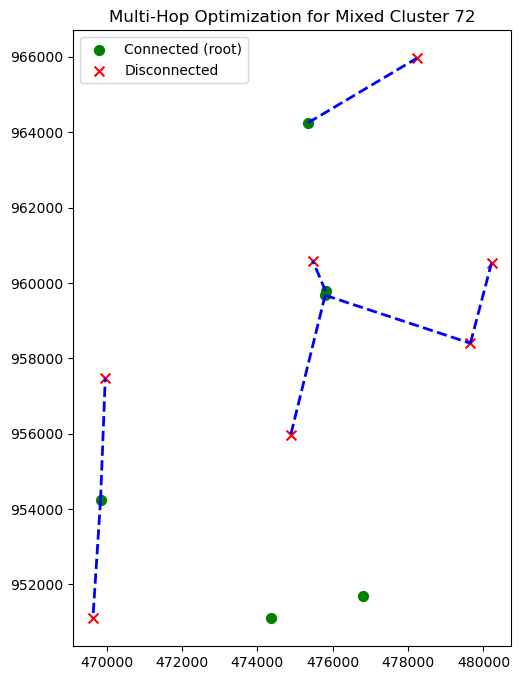

Cluster 73: 2 nodes; using N = 2 nodes (Roots: 1, Disconnected: 1)


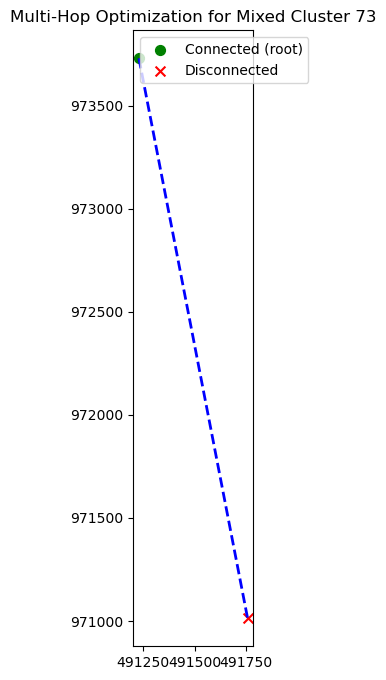

Total mixed cluster: 73
Total solved: 67
Total not solved: 6


In [20]:
# Parameters for the ILP
alpha = 1.0         # Weight for hop count in the objective (adjust as needed)

# We'll store optimization results for each mixed cluster (if needed)
mixed_cluster_results = []
not_solved_mixed_clusters = []

total_solved = 0
total_not_solved = 0

def solve_ilp(f_R, f_ND, f_cluster_idx):
    r_status = False
    r_assignments = []

    # Keep all nodes in N
    _N = list(set(f_R) | set(f_ND))

    print(f"Cluster {f_cluster_idx}: {len(_N)} nodes; using N = {len(_N)} nodes (Roots: {len(f_R)}, Disconnected: {len(f_ND)})")

    # If there are no root nodes, skip optimization
    if len(f_R) == 0:
        print(f"Cluster {f_cluster_idx} has no connected nodes; skipping optimization.")
        return r_status, r_assignments

    distances = {}
    valid_edges = []

    for _i in _N:
        for _j in _N:
            if _i != _j:
                _dist = filtered_schools_gdf.loc[_i, 'geometry'].distance(filtered_schools_gdf.loc[_j, 'geometry'])
                if _dist <= maximum_edge_distance:
                    _i, _j = int(_i), int(_j)  # Ensure they are plain Python ints
                    distances[(_i, _j)] = _dist
                    valid_edges.append((_i, _j))  # Store only valid edges

    # If no valid edges exist, skip this cluster
    if not valid_edges:
        print(f"Cluster {f_cluster_idx} has no valid edges within {maximum_edge_distance}m; skipping optimization.")
        return r_status, r_assignments

    # Set M as the number of nodes + buffer
    M = len(_N) + 5

    # Create the ILP model for this cluster
    prob = pulp.LpProblem(f"MultiHopOptimization_cluster_{f_cluster_idx}", pulp.LpMinimize)

    # Decision variables: x[i,j] is 1 if node i connects to node j (i -> j)
    x = pulp.LpVariable.dicts("x", valid_edges, cat=pulp.LpBinary)

    # Continuous variables: h[j] is the hop count (level) for node j
    h = pulp.LpVariable.dicts("h", _N, lowBound=0, cat=pulp.LpContinuous)

    # Objective: Minimize sum(distance * x) + alpha * sum(h)
    prob += (pulp.lpSum(distances[(_i, _j)] * x[_i, _j] for (_i, _j) in valid_edges)
             + alpha * pulp.lpSum(h[j] for j in _N)), "TotalCost"

    # Constraint 1: Each non-root node must have exactly one incoming edge
    for _j in _N:
        if _j not in f_R:
            prob += pulp.lpSum(x[i, _j] for i in _N if (i, _j) in valid_edges) == 1, f"InEdge_{_j}"
        else:
            prob += pulp.lpSum(x[i, _j] for i in _N if (i, _j) in valid_edges) == 0, f"Root_{_j}"

    # Constraint 2: Each node can have at most maximum_node_connections outgoing edges
    for _i in _N:
        prob += pulp.lpSum(x[_i, j] for j in _N if (_i, j) in valid_edges) <= maximum_node_connections, f"Capacity_{_i}"

    # Constraint 3: Hop count constraints - if i -> j, then h[j] >= h[i] + 1
    for (_i, _j) in valid_edges:
        prob += h[_j] >= h[_i] + 1 - M * (1 - x[_i, _j]), f"Hop_{_i}_{_j}"

    # Constraint 4: Root nodes have h = 0
    for r in f_R:
        prob += h[r] == 0, f"RootHop_{r}"

    for _j in _N:
        prob += h[_j] <= maximum_hops, f"MaxHop_{_j}"

    # Solve the optimization for this cluster with a 60-second timeout
    solver = pulp.PULP_CBC_CMD(timeLimit=ilp_timeout)
    prob.solve(solver)

    # If infeasible, print constraints and variables
    if pulp.LpStatus[prob.status] != "Optimal":
        return r_status, r_assignments

    r_status = True

    # Extract the chosen edges (assignments)
    for (_i, _j) in valid_edges:
        if pulp.value(x[_i, _j]) == 1:
            r_assignments.append((_i, _j, distances[(_i, _j)], pulp.value(h[_j])))

    return r_status, r_assignments

# Loop over each mixed cluster (assumed to be in mixed_clusters list)
for cluster_idx, cluster_info in enumerate(mixed_clusters, start=1):
    cluster_nodes = list(cluster_info["cluster_nodes"])

    # Partition nodes: those already connected (roots) and disconnected.
    R = [_node for _node in cluster_nodes if filtered_schools_gdf.loc[_node, 'Connected']]
    ND = [_node for _node in cluster_nodes if _node not in R]  # Disconnected nodes
    N = list(set(R) | set(ND))
    status, assignments = solve_ilp(R, ND, cluster_idx)

    if not status:
        not_solved_mixed_clusters.append(cluster_info)
        total_not_solved += 1
        print(f"Cluster {cluster_idx} has no optimal solution; mark to reanalysis.")
        continue

    # Convert to DataFrame for review
    df_cluster_assignments = pd.DataFrame(assignments, columns=["from", "to", "distance", "hop"])

    # Plot this cluster
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_title(f"Multi-Hop Optimization for Mixed Cluster {cluster_idx}")

    # Plot all nodes in the cluster
    cluster_gdf = filtered_schools_gdf.loc[N]

    # Use different markers: green for roots, red for disconnected
    roots_plot = [node for node in N if node in R]
    non_roots_plot = [node for node in N if node not in R]

    if roots_plot:
        filtered_schools_gdf.loc[roots_plot].plot(ax=ax, color="green", markersize=50, marker="o", label="Connected (root)")
    if non_roots_plot:
        filtered_schools_gdf.loc[non_roots_plot].plot(ax=ax, color="red", markersize=50, marker="x", label="Disconnected")

    # Draw the chosen connection edges
    for (i, j, dist_val, hop_val) in assignments:
        pt_i = filtered_schools_gdf.loc[i, 'geometry']
        pt_j = filtered_schools_gdf.loc[j, 'geometry']
        ax.plot([pt_i.x, pt_j.x], [pt_i.y, pt_j.y], linestyle="--", color="blue", linewidth=2)

    ax.legend()
    plt.show()
    total_solved += 1
    # Save cluster results (if desired)
    mixed_cluster_results.append({
        "cluster_id": cluster_idx,
        "assignments_df": df_cluster_assignments
    })

print(f"Total mixed cluster: {len(mixed_clusters)}")
print(f"Total solved: {total_solved}")
print(f"Total not solved: {total_not_solved}")

## Mixed-Connectivity clusters : Second Optimization Sweep: Dropping infeasible nodes

For some clusters it might be impossible to connect all non-connected schools within the cluster with connected schools. In that case the ILP in the previous code block will not find a feasible solution. The only option in this case would be to add one or more additional cellular towers nearby unconnected schools, which can then connect to other nearby schools using point-to-point connections.

For all those mixed-clusters that don't have a feasible solution in the first sweep, we do another sweep with some smart heuristics. Big clusters with a lot of schools will also fall into this second sweep, due to the imposed timeout on the ILP solving in the first sweep. This heuristic will also help these clusters so that they can be solved within a reasonable amount of time.

**Heuristic**: Non-connected schools that are very isolated in the cluster are more likeley to cause the ILP to become infeasible. Therefore we calculate an isolation score for non-connected schools in the mixed-cluster, and we drop schools that have a high isolation score from the cluster.

With those "isolated" schools dropped, we try to solve the ILP again and see if it is feasible. We repeat this process iteratively (dropping - solving ILP with new cluster) until a feasible solution is found within the timeout, or until a maximum of 10 iterations is reached.


Processing Cluster 1 with 22 nodes
Binary Search Iteration 1: Trying removal count = 5 (Total candidate nodes: 17)
Cluster 1: 17 nodes; using N = 17 nodes (Roots: 11, Disconnected: 6)
  Optimal with 17 nodes. Updating best solution; trying fewer removals.
Final solution includes 17 nodes; dropped 5 nodes.
Cluster 1: Dropped 5 nodes.


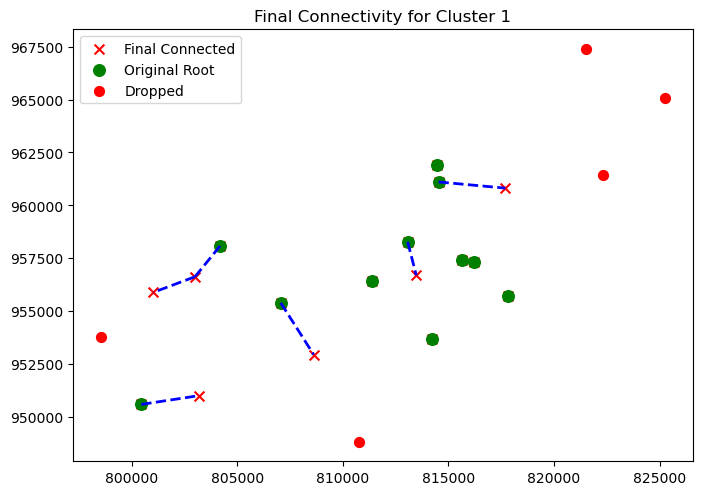


Processing Cluster 2 with 8 nodes
Binary Search Iteration 1: Trying removal count = 3 (Total candidate nodes: 5)
Cluster 2: 5 nodes; using N = 5 nodes (Roots: 1, Disconnected: 4)
  Optimal with 5 nodes. Updating best solution; trying fewer removals.
Final solution includes 5 nodes; dropped 3 nodes.
Cluster 2: Dropped 3 nodes.


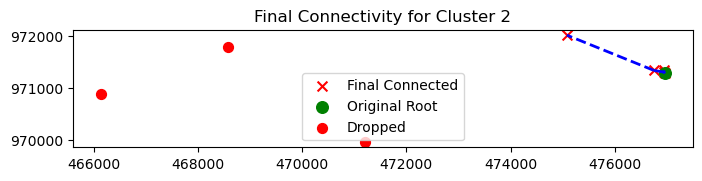


Processing Cluster 3 with 792 nodes
Binary Search Iteration 1: Trying removal count = 235 (Total candidate nodes: 557)
Cluster 3: 557 nodes; using N = 557 nodes (Roots: 322, Disconnected: 235)
  Optimal with 557 nodes. Updating best solution; trying fewer removals.
Final solution includes 557 nodes; dropped 235 nodes.
Cluster 3: Dropped 235 nodes.


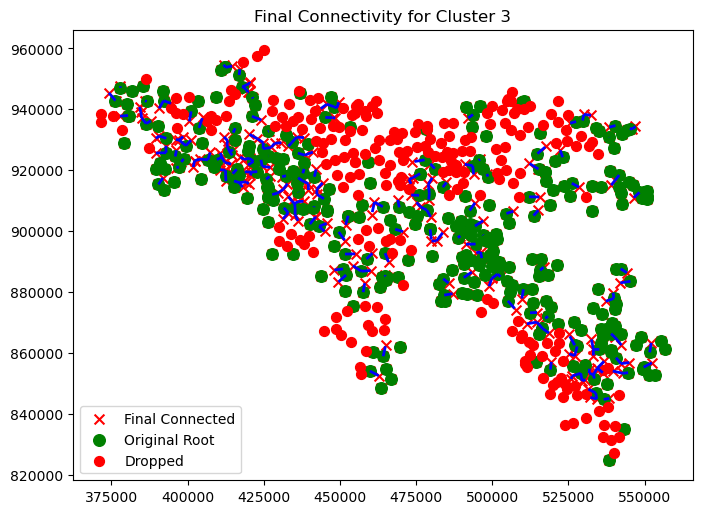


Processing Cluster 4 with 339 nodes
Binary Search Iteration 1: Trying removal count = 110 (Total candidate nodes: 229)
Cluster 4: 229 nodes; using N = 229 nodes (Roots: 118, Disconnected: 111)
  Not optimal. Increasing removal count.
Binary Search Iteration 2: Trying removal count = 166 (Total candidate nodes: 173)
Cluster 4: 173 nodes; using N = 173 nodes (Roots: 118, Disconnected: 55)
  Optimal with 173 nodes. Updating best solution; trying fewer removals.
Final solution includes 173 nodes; dropped 166 nodes.
Cluster 4: Dropped 166 nodes.


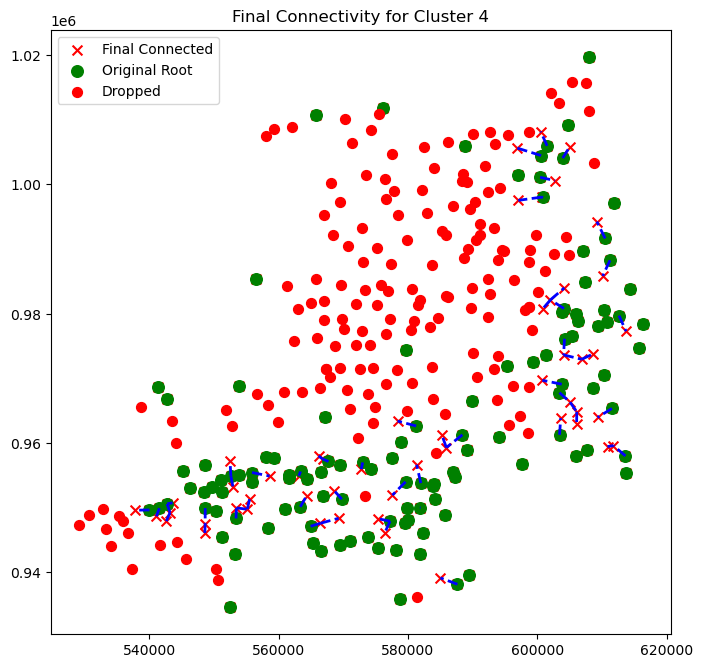


Processing Cluster 5 with 19 nodes
Binary Search Iteration 1: Trying removal count = 3 (Total candidate nodes: 16)
Cluster 5: 16 nodes; using N = 16 nodes (Roots: 12, Disconnected: 4)
  Not optimal. Increasing removal count.
Binary Search Iteration 2: Trying removal count = 5 (Total candidate nodes: 14)
Cluster 5: 14 nodes; using N = 14 nodes (Roots: 12, Disconnected: 2)
  Optimal with 14 nodes. Updating best solution; trying fewer removals.
Final solution includes 14 nodes; dropped 5 nodes.
Cluster 5: Dropped 5 nodes.


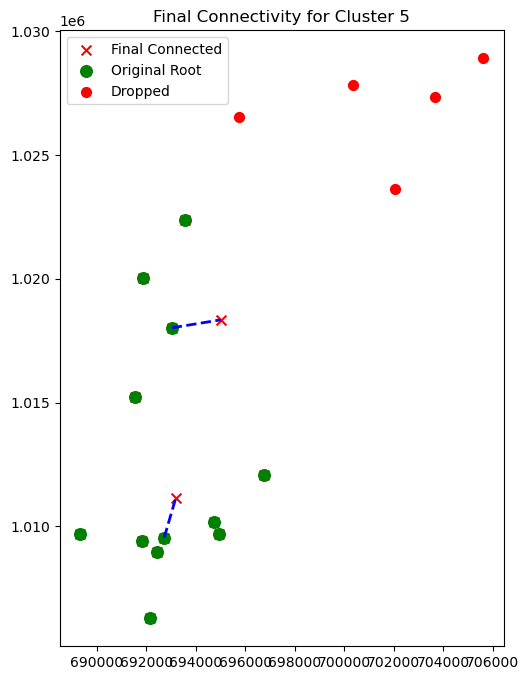


Processing Cluster 6 with 131 nodes
Binary Search Iteration 1: Trying removal count = 50 (Total candidate nodes: 81)
Cluster 6: 81 nodes; using N = 81 nodes (Roots: 30, Disconnected: 51)
  Optimal with 81 nodes. Updating best solution; trying fewer removals.
Final solution includes 81 nodes; dropped 50 nodes.
Cluster 6: Dropped 50 nodes.


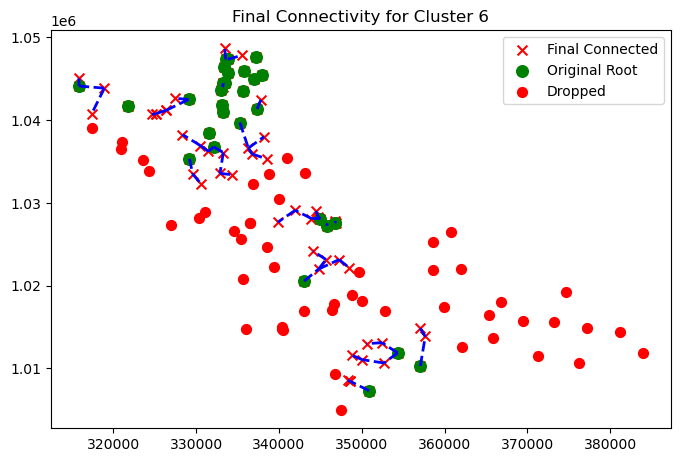

cluster_id  num_nodes  num_assignments  \
0           1         17                6   
1           2          5                4   
2           3        557              235   
3           4        173               55   
4           5         14                2   
5           6         81               51   

                                      assignments_df  
0     from  to     distance  hop
0    32  33  289...  
1     from    to     distance  hop
0  2197  2198 ...  
2       from    to     distance  hop
0    1036  1...  
3      from    to     distance  hop
0   2080  207...  
4     from    to     distance  hop
0  1400  1395 ...  
5      from    to     distance  hop
0   1827  182...

In [21]:
def compute_isolation_score(f_node_id, local_gdf, k=3):
    # Get indices of connected (root) nodes
    connected_nodes = local_gdf[local_gdf['Connected']].index
    _geom = local_gdf.loc[f_node_id, 'geometry']
    dists = []
    for other in connected_nodes:
        if other == f_node_id:
            continue
        dists.append(_geom.distance(local_gdf.loc[other, 'geometry']))
    if len(dists) == 0:
        return np.inf  # no connected nodes available
    dists = np.sort(dists)
    return np.mean(dists[:k]) if len(dists) >= k else np.mean(dists)


def iterative_ilp_with_golden(f_cluster_nodes,
                              f_cluster_idx,
                              max_iterations=10):

    f_cluster_nodes = list(f_cluster_nodes)
    _R = [n for n in f_cluster_nodes if filtered_schools_gdf.loc[n, 'Connected']]
    _ND = [n for n in f_cluster_nodes if n not in _R]
    # Sort ND by isolation score in descending order (worst first)
    sorted_ND = sorted(_ND, key=lambda n: compute_isolation_score(n, filtered_schools_gdf), reverse=True)

    # We'll search for the minimal number r (0 <= r <= len(sorted_ND)) to drop such that ILP on (R ∪ (ND[r:])) is optimal.
    low, high = 0, len(sorted_ND)
    best_solution = None
    iteration = 0
    while low <= high and iteration < max_iterations:
        mid = (low + high) // 2
        candidate_nodes = _R + sorted_ND[mid:]  # keep all connected and the less isolated ND
        print(f"Binary Search Iteration {iteration+1}: Trying removal count = {mid} (Total candidate nodes: {len(candidate_nodes)})")
        _status, _assignments = solve_ilp(_R, sorted_ND[mid:], f_cluster_idx)
        if _status:
            solution = {
                "nodes": candidate_nodes,
                "assignments": _assignments
            }
            best_solution = solution
            high = mid - 1
            print(f"  Optimal with {len(candidate_nodes)} nodes. Updating best solution; trying fewer removals.")
            #for debug
            break
        else:
            low = mid + 1
            print(f"  Not optimal. Increasing removal count.")
        iteration += 1

    # Compute the list of dropped nodes relative to the original full cluster.
    final_nodes = best_solution["nodes"] if best_solution is not None else []
    _dropped_nodes = list(set(f_cluster_nodes) - set(final_nodes))
    print(f"Final solution includes {len(final_nodes)} nodes; dropped {len(_dropped_nodes)} nodes.")

    return best_solution, _dropped_nodes


final_cluster_results = []
dropped_bucket = {}

for cluster_idx, cluster_info in enumerate(not_solved_mixed_clusters, start=1):
    cluster_nodes = list(cluster_info["cluster_nodes"])
    if len(cluster_nodes) < 2:
        print(f"Cluster {cluster_idx} has only one node; skipping.")
        continue
    # Save the original root nodes for this cluster.
    original_roots = [n for n in cluster_nodes if filtered_schools_gdf.loc[n, 'Connected']]

    print(f"\nProcessing Cluster {cluster_idx} with {len(cluster_nodes)} nodes")
    sol, dropped = iterative_ilp_with_golden(cluster_nodes,
                                             cluster_idx,
                                             max_iterations=5)
    dropped_bucket[cluster_idx] = dropped
    if sol is not None:
        assignments = sol["assignments"]
        df_cluster_assignments = pd.DataFrame(assignments, columns=["from", "to", "distance", "hop"])
        final_cluster_results.append({
            "cluster_id": cluster_idx,
            "num_nodes": len(sol["nodes"]),
            "num_assignments": len(assignments),
            "assignments_df": df_cluster_assignments
        })
        # Visualization:
        N = sol["nodes"]
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_title(f"Final Connectivity for Cluster {cluster_idx}")
        # Plot final solution nodes in green.
        filtered_schools_gdf.loc[N].plot(ax=ax, color="red", markersize=50, marker="x", label="Final Connected")
        # Overlay original root nodes as red circles.
        if original_roots:
            filtered_schools_gdf.loc[original_roots].plot(ax=ax, color="green", markersize=70, marker="o", label="Original Root")
        # Plot dropped nodes in red X.
        dropped_nodes = list(set(cluster_nodes) - set(N))
        print(f"Cluster {cluster_idx}: Dropped {len(dropped_nodes)} nodes.")
        if dropped_nodes:
            filtered_schools_gdf.loc[dropped_nodes].plot(ax=ax, color="red", markersize=50, marker="o", label="Dropped")
        # Draw ILP edges.
        for (i, j, d_val, h_val) in assignments:
            pt_i = filtered_schools_gdf.loc[i, 'geometry']
            pt_j = filtered_schools_gdf.loc[j, 'geometry']
            ax.plot([pt_i.x, pt_j.x], [pt_i.y, pt_j.y], linestyle="--", color="blue", linewidth=2)
        ax.legend()
        plt.show()
    else:
        print(f"No feasible solution found for Cluster {cluster_idx} after outlier removal.")

results_df = pd.DataFrame(final_cluster_results)
results_df.to_excel("final_cluster_results.xlsx", index=False)
display(results_df)


**Dropped schools**: At the end when the cluster is sovled during the second sweep, a smaller sub-cluster of dropped unconnected schools will remain. This sub-cluster of all unconnected nodes will be solved later in this notebook together with the disconnected clusters in  `disconnected_cluster_info`.

In [22]:
dropped_gdfs = []
for cluster_id, node_list in dropped_bucket.items():
    if node_list:  # only if there are dropped nodes for this cluster
        gdf_subset = filtered_schools_gdf.reindex(node_list).dropna(subset=["geometry"]).copy()
        gdf_subset["cluster_id"] = cluster_id
        dropped_gdfs.append(gdf_subset)

if dropped_gdfs:
    dropped_gdf = gpd.GeoDataFrame(pd.concat(dropped_gdfs, axis=0))
else:
    dropped_gdf = gpd.GeoDataFrame()

# Preserve the original index in a new column "old_index"
dropped_gdf = dropped_gdf.copy()
dropped_gdf["old_index"] = dropped_gdf.index

# Reset the index to create a continuous RangeIndex for clustering
dropped_gdf_reindexed = dropped_gdf.reset_index(drop=True)

# Build a spatial index on the reindexed GeoDataFrame
reindexed_sindex = dropped_gdf_reindexed.sindex

# Create a proximity graph using the reindexed GeoDataFrame
G_all = nx.Graph()
for sid in dropped_gdf_reindexed.index:
    G_all.add_node(sid)

for sid, geom in zip(dropped_gdf_reindexed.index, dropped_gdf_reindexed.geometry):
    possible_neighbors = list(reindexed_sindex.intersection(geom.buffer(maximum_edge_distance).bounds))
    for nbr_idx in possible_neighbors:
        if nbr_idx == sid:
            continue
        nbr_geom = dropped_gdf_reindexed.loc[nbr_idx, 'geometry']
        if geom.distance(nbr_geom) <= maximum_edge_distance:
            G_all.add_edge(sid, nbr_idx)

# Find connected components (clusters) in the graph (using the reindexed indices)
clusters_reindexed = list(nx.connected_components(G_all))
print(f"Total clusters found (reindexed): {len(clusters_reindexed)}")

# Map clusters back to original indices using the "old_index" column.
clusters_disconnected_all = []
for comp in clusters_reindexed:
    # comp is a set of reindexed IDs; map each one back to original index
    original_ids = { dropped_gdf_reindexed.loc[new_idx, "old_index"] for new_idx in comp }
    clusters_disconnected_all.append(original_ids)

all_dropped_disconnected_clusters = []

for cluster in clusters_disconnected_all:
    cluster_ids = list(cluster)
    cluster_size = len(cluster_ids)
    if cluster_size == 1:
        continue  # Skip isolated clusters

    # Sum boolean values: True counts as 1, False as 0
    connected_count = filtered_schools_gdf.loc[cluster_ids, 'CoveredByTower'].sum()
    not_connected_count = cluster_size - connected_count

    cluster_info = {
        "cluster_nodes": cluster_ids,
        "total_nodes": cluster_size,
        "connected_schools": connected_count,
        "not_connected_schools": not_connected_count
    }

    all_dropped_disconnected_clusters.append(cluster_info)

df_all_dropped_disconnected_clusters = pd.DataFrame(all_dropped_disconnected_clusters)
df_all_dropped_disconnected_clusters.index = df_all_dropped_disconnected_clusters.index + 1
df_all_dropped_disconnected_clusters.index.name = "cluster_id"

display(df_all_dropped_disconnected_clusters.head(5))

Total clusters found (reindexed): 52


cluster_nodes  total_nodes  \
cluster_id                                                                   
1                                                [16, 17, 18]            3   
2                                           [216, 2209, 2210]            3   
3           [1120, 1027, 996, 997, 964, 965, 963, 966, 100...           11   
4                                                [1035, 1037]            2   
5           [1060, 1162, 1163, 972, 976, 1169, 977, 1171, ...           16   

            connected_schools  not_connected_schools  
cluster_id                                            
1                           0                      3  
2                           0                      3  
3                           0                     11  
4                           0                      2  
5                           0                     16

## Disconnected clusters: Placing a cellular tower

For clusters that consist of only disconnected schools, the only option is to place a cellular tower somewhere within the cluster.

In this section we will solve the optimization problem of finding a location for the cellular tower, and subsequently the point-to-point connections between schools that become connected to the cellular tower and other schools outside of the cellular tower reach.

We first define some helper functions that we will need

In [23]:
def find_close_pairs(gdf, R=2000):
    """
        Find pairs within the given geopandas dataframe gdf that are within R from each other.
    """

    pairs = []
    # Create the spatial index
    sindex = gdf.sindex

    # Loop over each row in the GeoDataFrame
    for idx, geom in gdf.geometry.items():
        # Buffer the geometry by R to create a search area
        buffered_geom = geom.buffer(R)

        # Find and iterate over candidate indices whose bounding boxes intersect the buffer
        for row_nb in sindex.intersection(buffered_geom.bounds):
            j = gdf.index[row_nb]
            # Skip if it's the same geometry or if we've already checked the pair
            if (j == idx) or ((j, idx) in pairs):
                continue

            # Check the actual distance
            candidate_geom = gdf.loc[j].geometry
            if geom.distance(candidate_geom) <= R:
                pairs.append((idx, j))
    return pairs


def find_intersection_points(point1, point2, R=1000):
    """
        Returns the intersection points of two circles centered at point1 and point2 with radius R.
        Distance between point1 and point2 should be <= 2R
        In case Distance between point1 and point2
    """
    x1, y1 = point1.x, point1.y
    x2, y2 = point2.x, point2.y

    d = sqrt((x1-x2)**2+(y1-y2)**2)
    if (d > 2*R) or isclose(d, 0):
        # If the distance is 0, there are no intersections
        # There are no intersections
        return ()

    l = d/2.
    h = sqrt(R**2 - l**2)

    sol1 = ((l/d)*(x2-x1)+(h/d)*(y2-y1)+x1, (l/d)*(y2-y1)-(h/d)*(x2-x1)+y1)
    sol2 = ((l/d)*(x2-x1)-(h/d)*(y2-y1)+x1, (l/d)*(y2-y1)+(h/d)*(x2-x1)+y1)

    if (isclose(sol1[0], sol2[0]) and isclose(sol1[1], sol2[1])):
        return (Point(*sol1),)

    return (Point(*sol1), Point(*sol2))


def get_greedy_tower_location(school_idx, cluster_close_schools, cluster_gdf):
    """
        Return a tower location (Point) around the unconnected school at index school_idx, such that the tower covers as many neighbouring schools as possible.
        If there are no neighbouring schools withing the default_tower_range, the location of the school is returned as tower location (in this case the location doesn't matter, as long as it is within default_tower_location from the school.
    """

    neighbours = list(filter(lambda pair: school_idx in pair, cluster_close_schools))

    # Tower location and nodes that are covered by this tower location
    loc_and_nodes = (cluster_gdf.geometry.loc[school_idx], [school_idx,])
    if len(neighbours) > 0:
        # This school has neighbours that can be connected to the same tower
        for pair in neighbours:
            points = cluster_gdf.geometry.loc[list(pair)]
            potential_tower_locations = find_intersection_points(points.loc[pair[0]], points.loc[pair[1]], default_tower_range)

            for tower_loc in potential_tower_locations:
                # the or clause with map and isclose needs to be added due to precision issues, because the nodes are right on the edge of the tower connectivity radius
                current_connections = (cluster_gdf.geometry.distance(tower_loc) <= default_tower_range) | (cluster_gdf.geometry.distance(tower_loc).map(lambda v: isclose(v, default_tower_range)))

                if current_connections.sum() > len(loc_and_nodes[1]):
                    loc_and_nodes = (tower_loc, list(cluster_gdf.index[current_connections]))

    return loc_and_nodes


def solve_mixed_connections_cluster(cluster_idx, cluster_gdf, verbose=False):
    # Parameters for the ILP
    alpha = 1.0         # Weight for hop count in the objective (adjust as needed)

    cluster_nodes = list(cluster_gdf.index)

    # Partition nodes: those already connected (roots) and disconnected.
    R = list(cluster_gdf.loc[cluster_gdf['CoveredByTower']].index)
    ND = list(cluster_gdf.loc[~cluster_gdf['CoveredByTower']].index)  # Disconnected nodes

    # Keep all nodes in N
    N = list(set(R) | set(ND))

    if verbose: print(f"Cluster {cluster_idx} before filtering: {len(cluster_nodes)} nodes; using N = {len(N)} nodes (Roots: {len(R)}, Disconnected: {len(ND)})")

    # If there are no root nodes, skip optimization
    if len(R) == 0:
        print(f"Mixed cluster {cluster_idx} has no connected nodes; skipping optimization.")
        return

    # Precompute distances and filter valid edges (distance ≤ maximum_edge_distance)
    distances = {}
    valid_edges = []

    for i in N:
        for j in N:
            if i != j:
                dist = cluster_gdf.loc[i, 'geometry'].distance(cluster_gdf.loc[j, 'geometry'])
                if dist <= maximum_edge_distance:
                    i, j = int(i), int(j)  # Ensure they are plain Python ints
                    distances[(i, j)] = dist
                    valid_edges.append((i, j))  # Store only valid edges

    # If no valid edges exist, skip this cluster
    if not valid_edges:
        print(f"Mixed cluster {cluster_idx} has no valid edges within {maximum_edge_distance}m; skipping optimization.")
        return

    # Set M as the number of nodes + buffer
    M = len(N) + 5

    # Create the ILP model for this cluster
    prob = pulp.LpProblem(f"MultiHopOptimization_cluster_{cluster_idx}", pulp.LpMinimize)

    # Decision variables: x[i,j] is 1 if node i connects to node j (i -> j)
    x = pulp.LpVariable.dicts("x", valid_edges, cat=pulp.LpBinary)

    # Continuous variables: h[j] is the hop count (level) for node j
    h = pulp.LpVariable.dicts("h", N, lowBound=0, cat=pulp.LpContinuous)

    # Objective: Minimize sum(distance * x) + alpha * sum(h)
    prob += (pulp.lpSum(distances[(i, j)] * x[i, j] for (i, j) in valid_edges)
             + alpha * pulp.lpSum(h[j] for j in N)), "TotalCost"

    # Constraint 1: Each non-root node must have exactly one incoming edge
    for j in N:
        if j not in R:
            prob += pulp.lpSum(x[i, j] for i in N if (i, j) in valid_edges) == 1, f"InEdge_{j}"
        else:
            prob += pulp.lpSum(x[i, j] for i in N if (i, j) in valid_edges) == 0, f"Root_{j}"

    # Constraint 2: Each node can have at most maximum_node_connections outgoing edges
    for i in N:
        prob += pulp.lpSum(x[i, j] for j in N if (i, j) in valid_edges) <= maximum_node_connections, f"Capacity_{i}"

    # Constraint 3: Hop count constraints - if i -> j, then h[j] >= h[i] + 1
    for (i, j) in valid_edges:
        prob += h[j] >= h[i] + 1 - M * (1 - x[i, j]), f"Hop_{i}_{j}"

    # Constraint 4: Root nodes have h = 0
    for r in R:
        prob += h[r] == 0, f"RootHop_{r}"

    # (Optional) Upper bound on hop count
    H_max = 2  # Adjust as needed
    for j in N:
        prob += h[j] <= H_max, f"MaxHop_{j}"

    # Solve the optimization for this cluster with a 60-second timeout
    solver = pulp.PULP_CBC_CMD(timeLimit=60)
    prob.solve(solver)

    # Debugging output
    if verbose: print(f"Cluster {cluster_idx} optimization status: {pulp.LpStatus[prob.status]}")

    # If infeasible, print constraints and variables
    if pulp.LpStatus[prob.status] != "Optimal":
        print(f"Cluster {cluster_idx} is infeasible. Debugging constraints and variables...")

        # Output constraints
        if verbose:
            for constraint in prob.constraints:
                print(f"Constraint {constraint}: {prob.constraints[constraint]}")

            # Output variable values
            for variable in prob.variables():
                print(f"{variable.name}: {variable.varValue}")

        return  # Skip the rest of this cluster

    # Extract the chosen edges (assignments)
    assignments = []
    for (i, j) in valid_edges:
        if pulp.value(x[i, j]) == 1:
            assignments.append((i, j, distances[(i, j)], pulp.value(h[j])))

    # Convert to DataFrame for review
    df_cluster_assignments = pd.DataFrame(assignments, columns=["from", "to", "distance", "hop"])
    if verbose: print(f"Cluster {cluster_idx} assignments:")
    return df_cluster_assignments


def plot_optimized_cluster(cluster_idx, cluster_gdf, df_cluster_assignments, tower_location=None, tower_range=None):
    # Plot this cluster
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_title(f"Multi-Hop Optimization for Mixed Cluster {cluster_idx}")

    # Use different markers: green for roots, red for disconnected
    roots_plot = list(cluster_gdf.loc[cluster_gdf['CoveredByTower']].index)
    non_roots_plot = list(cluster_gdf.loc[~cluster_gdf['CoveredByTower']].index)

    if roots_plot:
        cluster_gdf.loc[roots_plot].plot(ax=ax, color="green", markersize=50, marker="o", label="Connected (root)")
    if non_roots_plot:
        cluster_gdf.loc[non_roots_plot].plot(ax=ax, color="red", markersize=50, marker="x", label="Disconnected")
    if tower_location is not None:
        if tower_range is not None:
            circle = plt.Circle((tower_location.x, tower_location.y), radius=tower_range, alpha=.1)
            ax.add_patch(circle)
        ax.scatter(tower_location.x, tower_location.y, marker='^', color='C1', s=100, label="Proposed LTE tower")

    # Draw the chosen connection edges
    for _, (i, j, dist_val, hop_val) in df_cluster_assignments.iterrows():
        pt_i = cluster_gdf.loc[i, 'geometry']
        pt_j = cluster_gdf.loc[j, 'geometry']
        ax.plot([pt_i.x, pt_j.x], [pt_i.y, pt_j.y], linestyle="--", color="blue", linewidth=2)
        if (hop_val > 0):
            ax.annotate(str(int(hop_val)),
                xy=(pt_j.x, pt_j.y), xycoords='data',
                xytext=(1.5, 1.5), textcoords='offset points', fontsize=12, color='red')

    legend = ax.legend()
    plt.show()

To optimize the disconnected clusters we follow a very similar approach as the mixed-clusters optimization, but with one additional step before solving the ILP.

The algorithm is as follows:

For each school in the disconnected cluster:
1. Place a cellular tower nearby this school such that this school is within the range of the tower.
    * The algorithm will try to place the tower in such a way that as many other neighbouring schools as possible will also be within the range of this tower.
    * In case there is no other school within tower range nearby this school, the tower will be placed at the same location as the school. Note that in this case the tower can be place anywhere around the school, as long as the school is still within tower range
2. The considered school, and potentially some other neighbouring schools within tower distance now become a connected schools. In other words, the cluster now becomes a mixed-connection cluster
3. Solve the ILP that was presented in the **'Mixed-Connectivity Clusters : Initial Optimization Sweep'** section for this mixed-connection cluster
4. Based on the ILP Result:
    * If a valid solution is found in which all schools are connected then this cluster is solved.
    * If no valid solution is found, then we consider placing a cellular tower nearby the next disconnected school in the cluster and go back to step **1.**

We repeat this algorithm for all clusters that were disconnected based on the connection dataset, and also for the disconnected sub-clusters that were obtained during in the **'Mixed-Connectivity clusters : Second Optimization Sweep: Dropping infeasible nodes'** section.

[cluster 1] Assigning tower to school 0
[cluster 1] cluster 1 is solved.


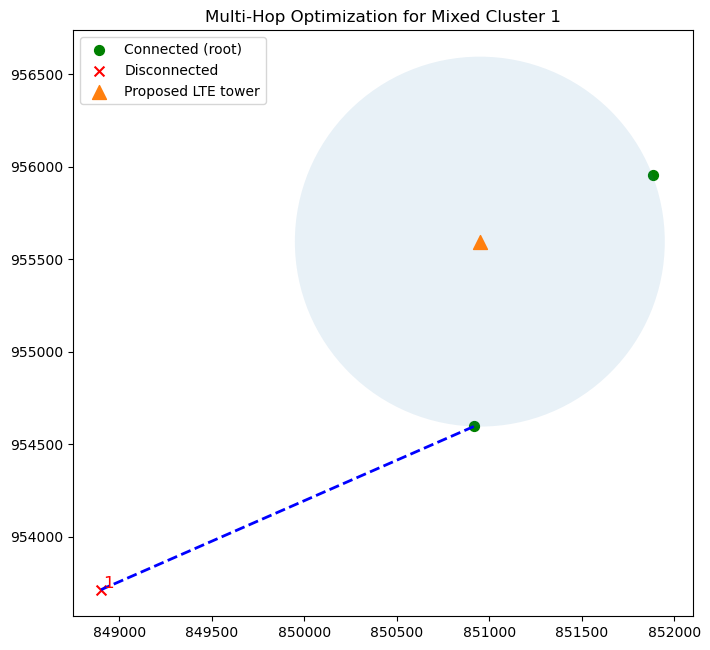

[cluster 2] Assigning tower to school 2
[cluster 2] cluster 2 is solved.


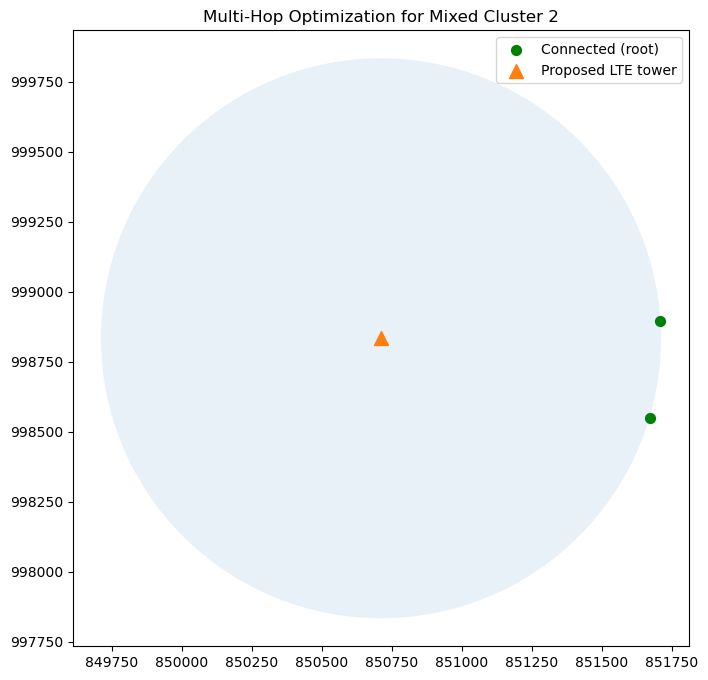

[cluster 3] Assigning tower to school 8
Cluster 8 is infeasible. Debugging constraints and variables...
[cluster 3] Assigning tower to school 162
[cluster 3] cluster 3 is solved.


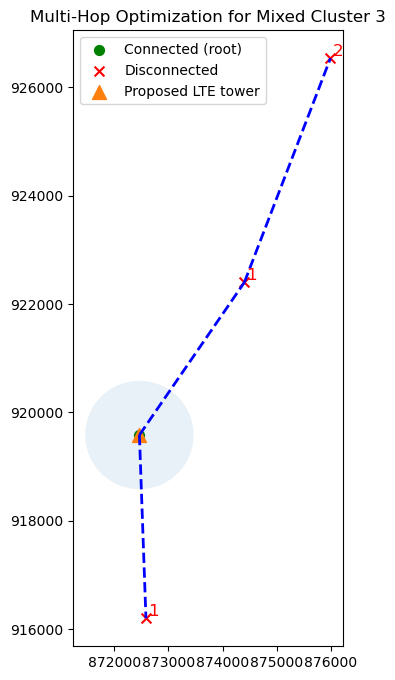

[cluster 4] Assigning tower to school 11
[cluster 4] cluster 4 is solved.


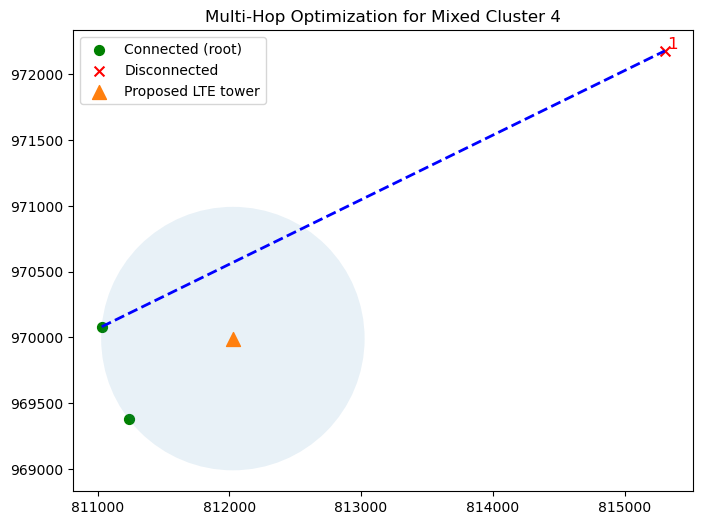

[cluster 5] Assigning tower to school 14
[cluster 5] cluster 5 is solved.


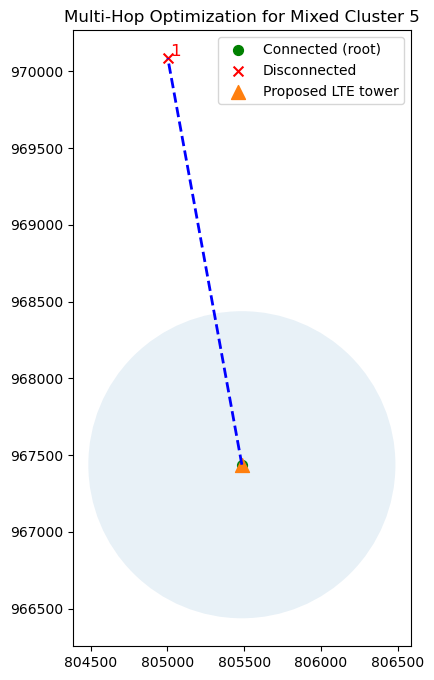

[cluster 6] Assigning tower to school 19
[cluster 6] cluster 6 is solved.


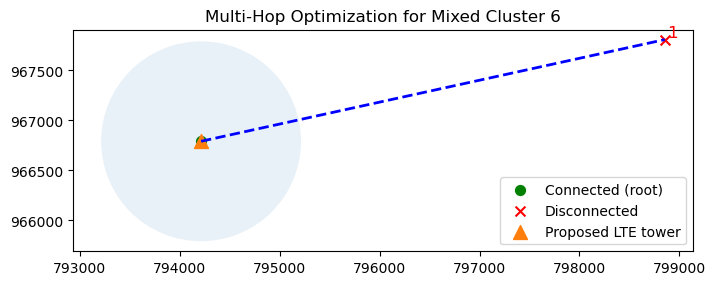

[cluster 7] Assigning tower to school 41
[cluster 7] cluster 7 is solved.


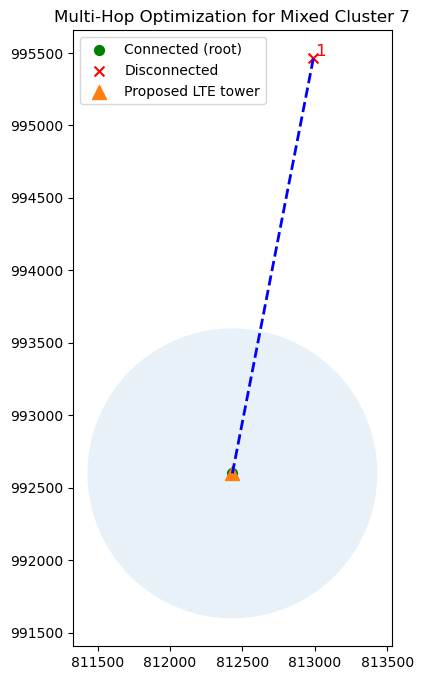

[cluster 8] Assigning tower to school 80
[cluster 8] cluster 8 is solved.


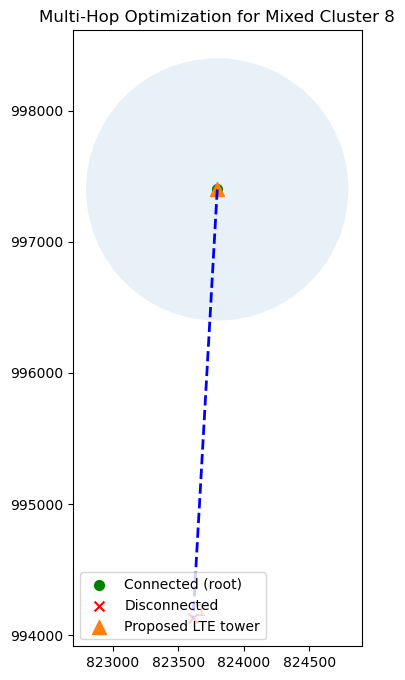

[cluster 9] Assigning tower to school 90
[cluster 9] cluster 9 is solved.


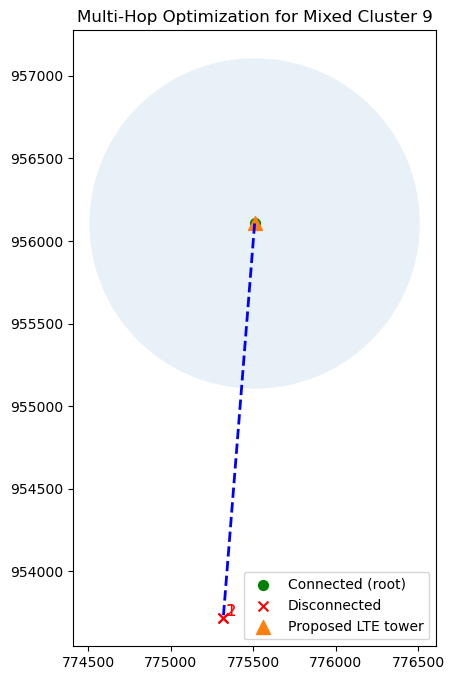

[cluster 10] Assigning tower to school 96
[cluster 10] cluster 10 is solved.


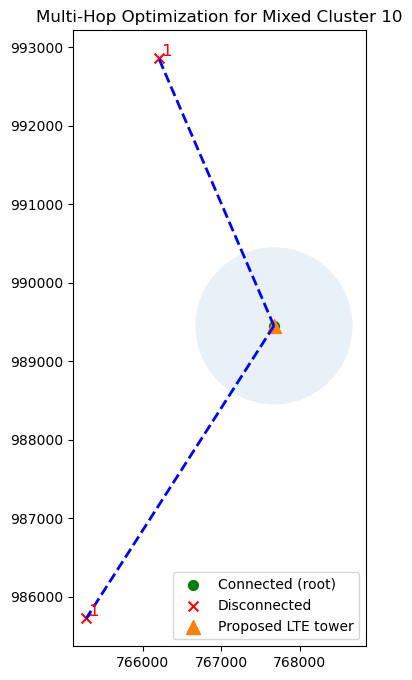

[cluster 11] Assigning tower to school 104
[cluster 11] cluster 11 is solved.


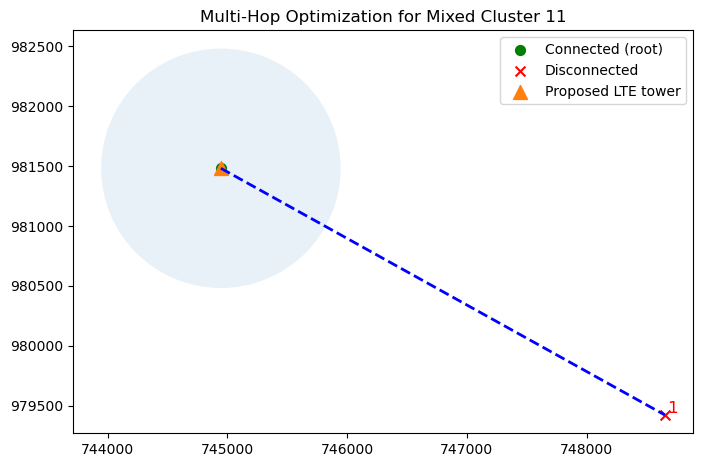

[cluster 12] Assigning tower to school 105
[cluster 12] cluster 12 is solved.


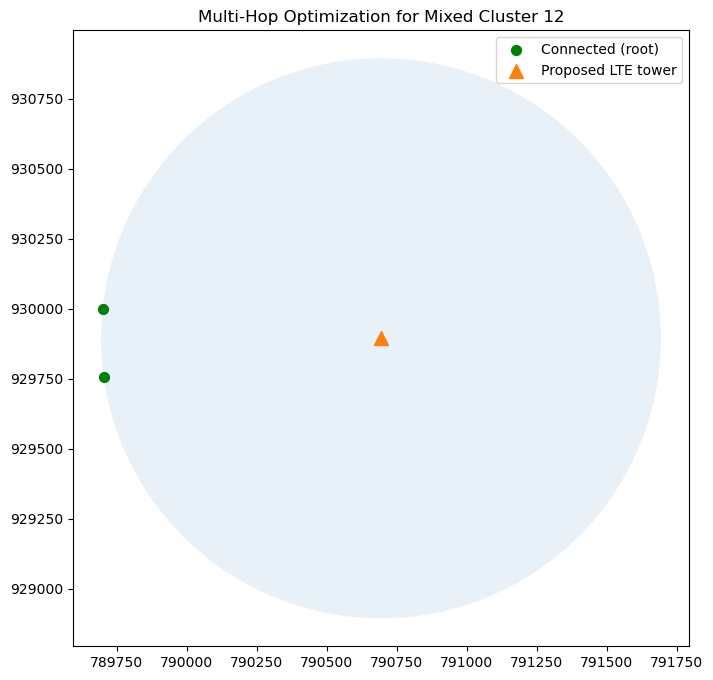

[cluster 13] Assigning tower to school 107
Cluster 107 is infeasible. Debugging constraints and variables...
[cluster 13] Assigning tower to school 111
Cluster 111 is infeasible. Debugging constraints and variables...
[cluster 13] Assigning tower to school 112
[cluster 13] cluster 13 is solved.


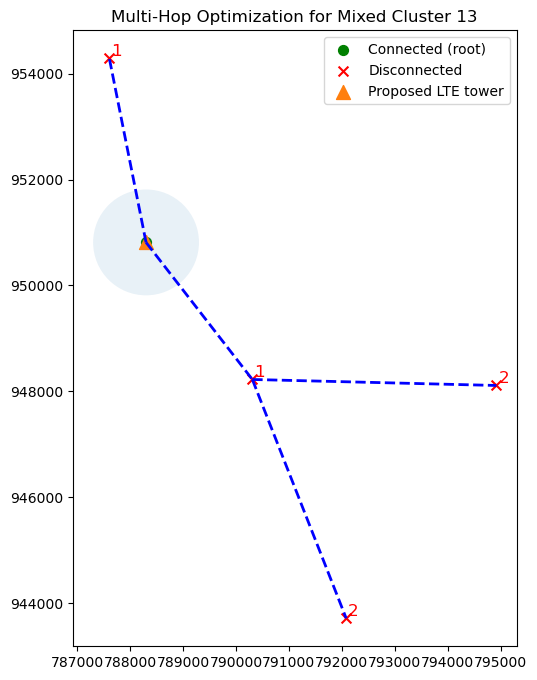

[cluster 14] Assigning tower to school 122
[cluster 14] cluster 14 is solved.


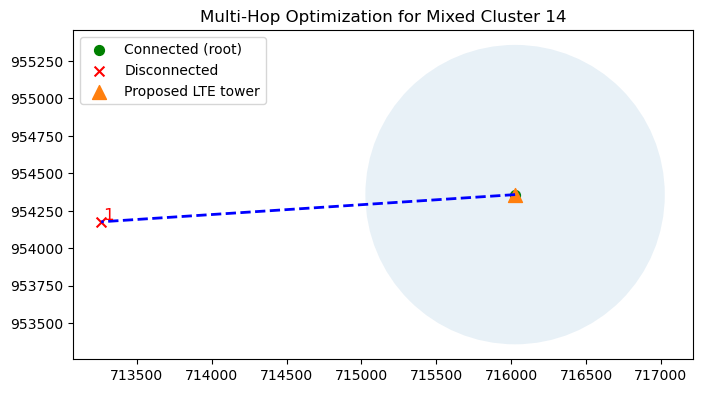

[cluster 15] Assigning tower to school 2052
Cluster 2052 is infeasible. Debugging constraints and variables...
[cluster 15] Assigning tower to school 2062
Cluster 2062 is infeasible. Debugging constraints and variables...
[cluster 15] Assigning tower to school 2063
Cluster 2063 is infeasible. Debugging constraints and variables...
[cluster 15] Assigning tower to school 2064
Cluster 2064 is infeasible. Debugging constraints and variables...
[cluster 15] Assigning tower to school 2065
Cluster 2065 is infeasible. Debugging constraints and variables...
[cluster 15] Assigning tower to school 2066
Cluster 2066 is infeasible. Debugging constraints and variables...
[cluster 15] Assigning tower to school 2069
Cluster 2069 is infeasible. Debugging constraints and variables...
[cluster 15] Assigning tower to school 124
Cluster 124 is infeasible. Debugging constraints and variables...
[cluster 15] Assigning tower to school 125
Cluster 125 is infeasible. Debugging constraints and variables...
[clus

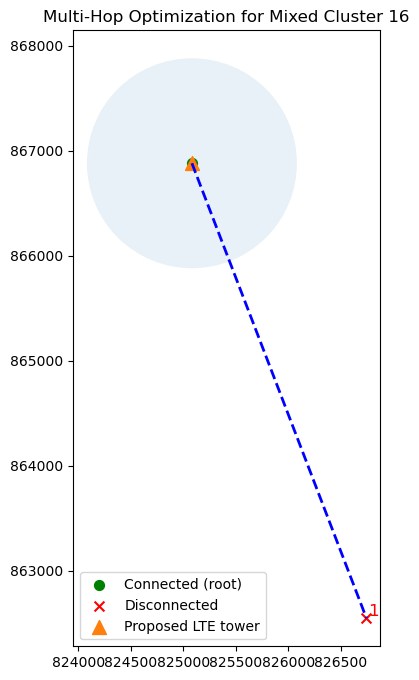

[cluster 17] Assigning tower to school 130
[cluster 17] cluster 17 is solved.


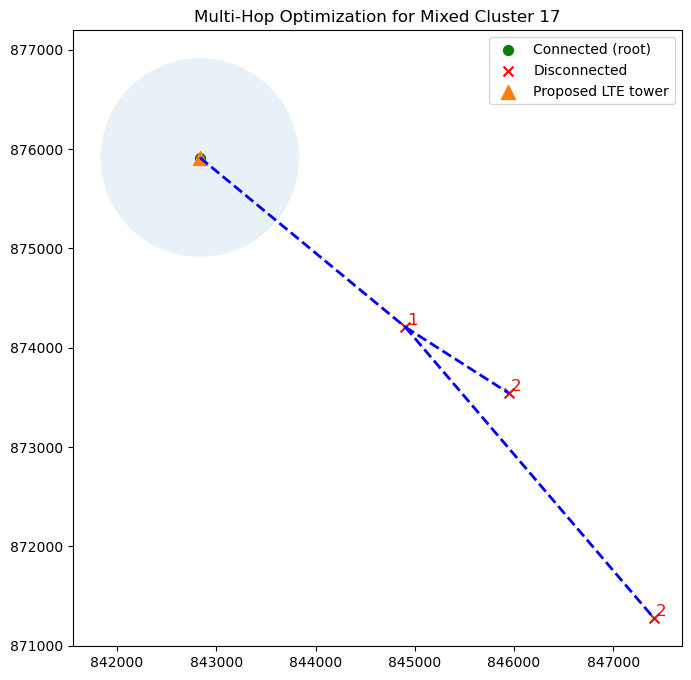

[cluster 18] Assigning tower to school 134
[cluster 18] cluster 18 is solved.


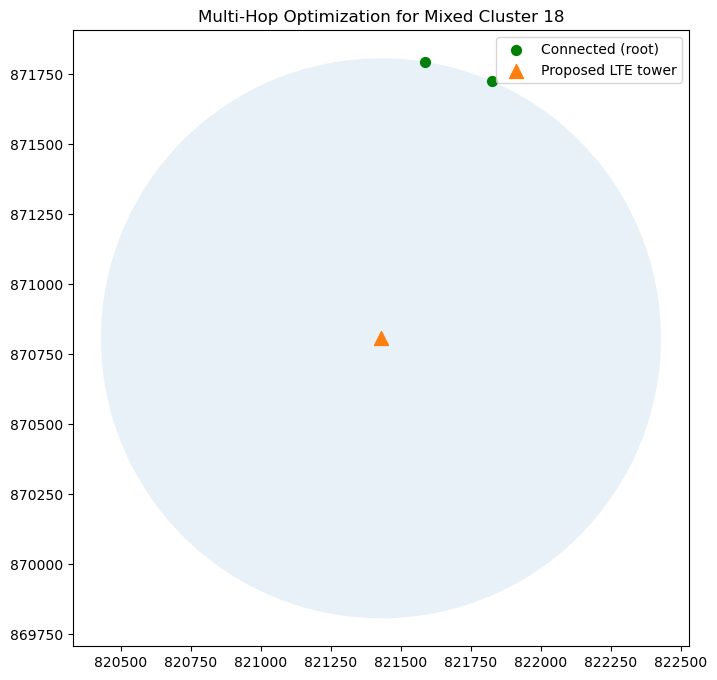

[cluster 19] Assigning tower to school 194
[cluster 19] cluster 19 is solved.


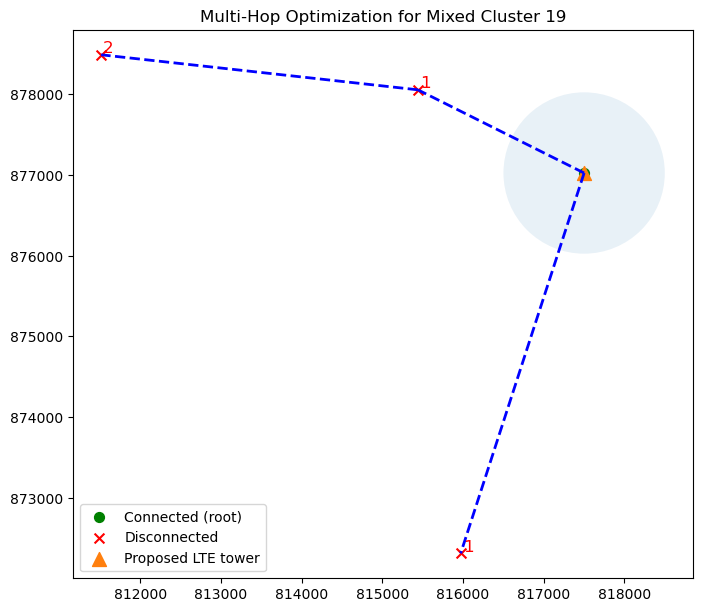

[cluster 20] Assigning tower to school 146
[cluster 20] cluster 20 is solved.


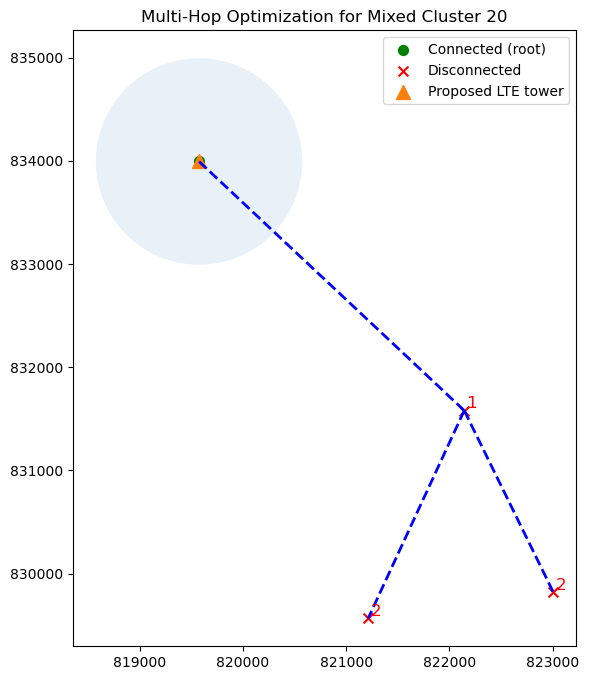

[cluster 21] Assigning tower to school 158
[cluster 21] cluster 21 is solved.


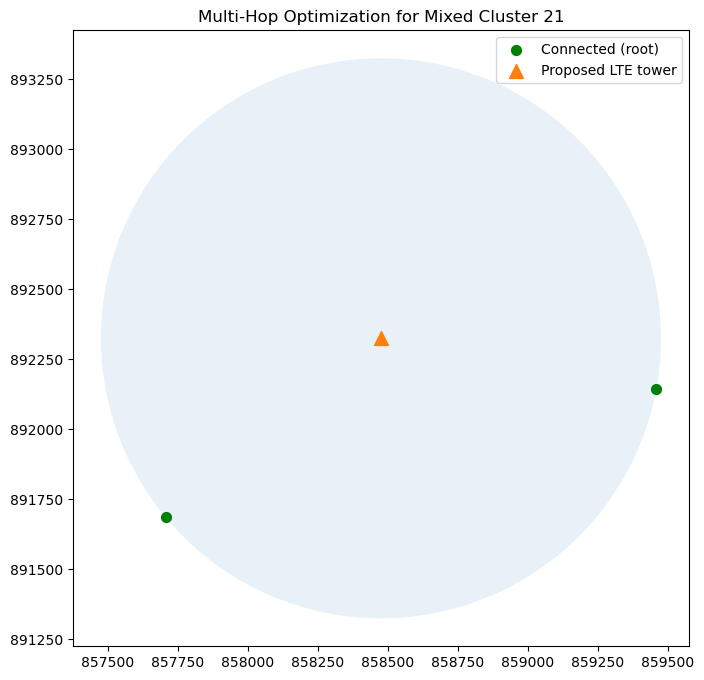

[cluster 22] Assigning tower to school 168
[cluster 22] cluster 22 is solved.


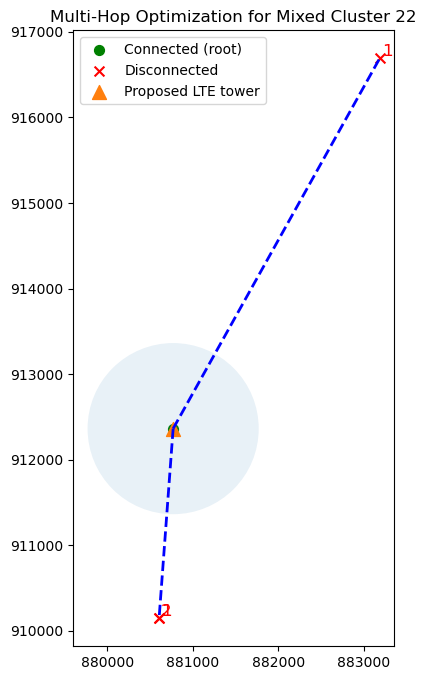

[cluster 23] Assigning tower to school 166
[cluster 23] cluster 23 is solved.


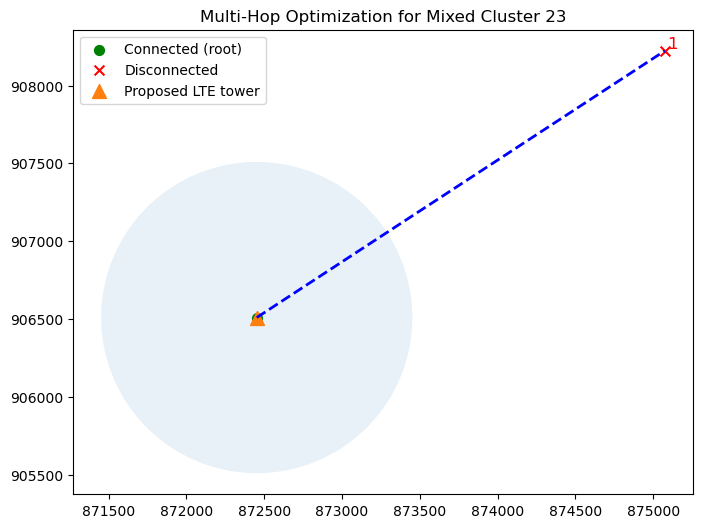

[cluster 24] Assigning tower to school 176
[cluster 24] cluster 24 is solved.


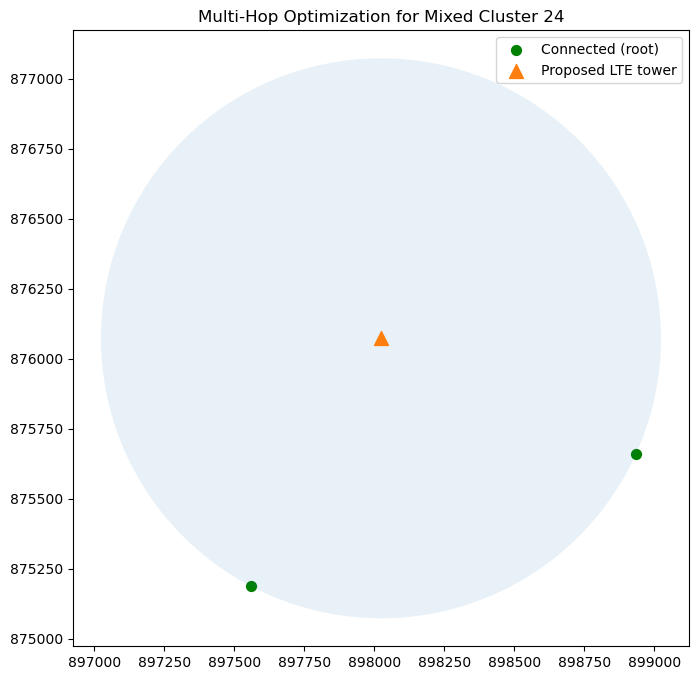

[cluster 25] Assigning tower to school 178
[cluster 25] cluster 25 is solved.


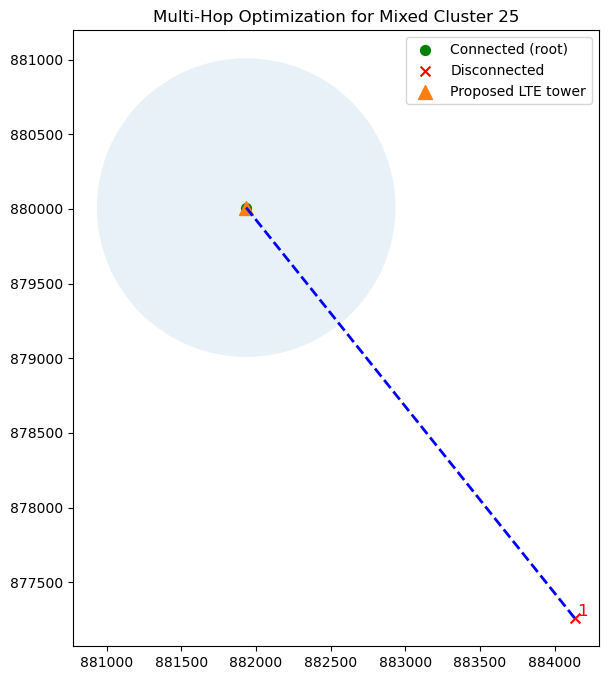

[cluster 26] Assigning tower to school 201
[cluster 26] cluster 26 is solved.


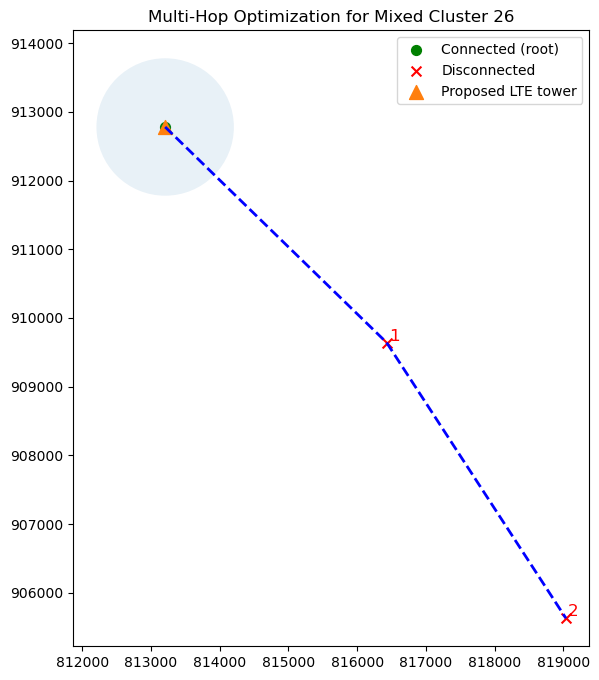

[cluster 27] Assigning tower to school 181
[cluster 27] cluster 27 is solved.


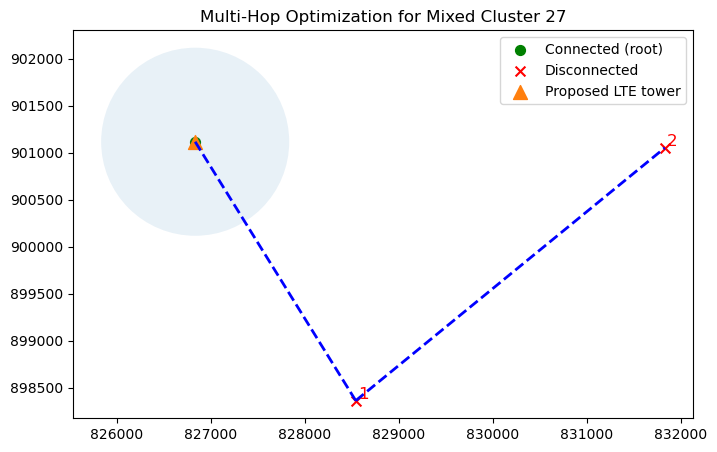

[cluster 28] Assigning tower to school 192
[cluster 28] cluster 28 is solved.


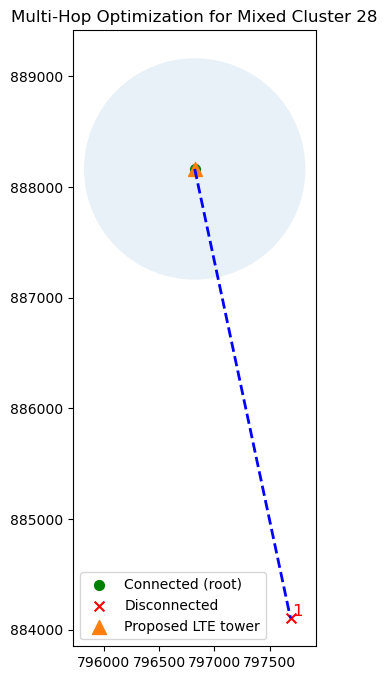

[cluster 29] Assigning tower to school 213
[cluster 29] cluster 29 is solved.


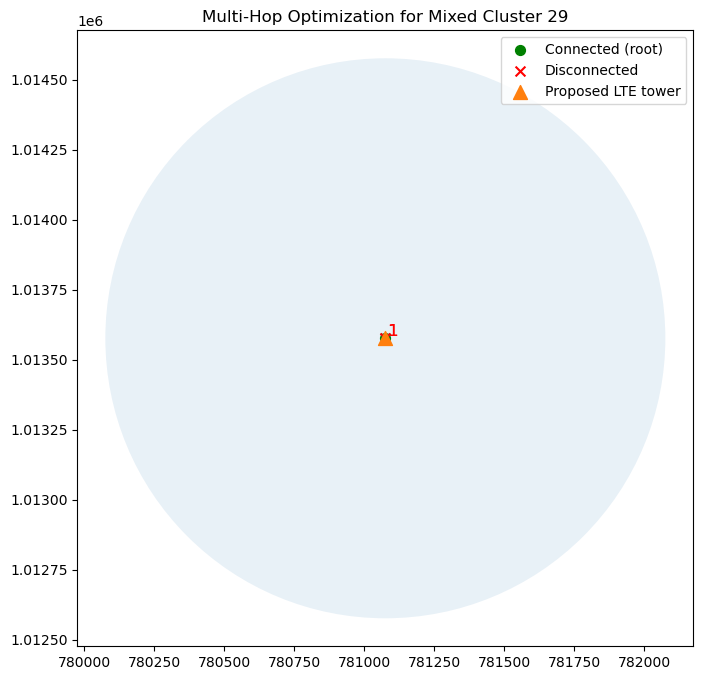

[cluster 30] Assigning tower to school 301
[cluster 30] cluster 30 is solved.


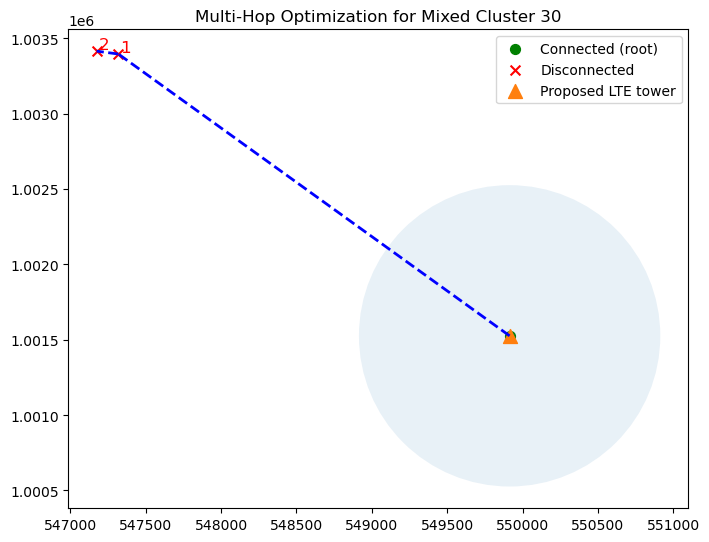

[cluster 31] Assigning tower to school 472
[cluster 31] cluster 31 is solved.


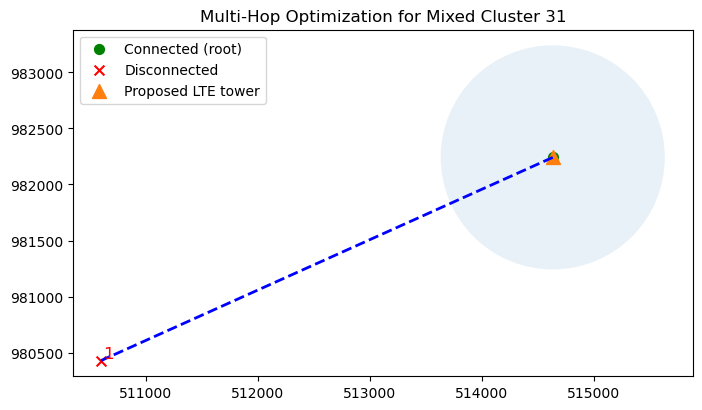

[cluster 32] Assigning tower to school 608
[cluster 32] cluster 32 is solved.


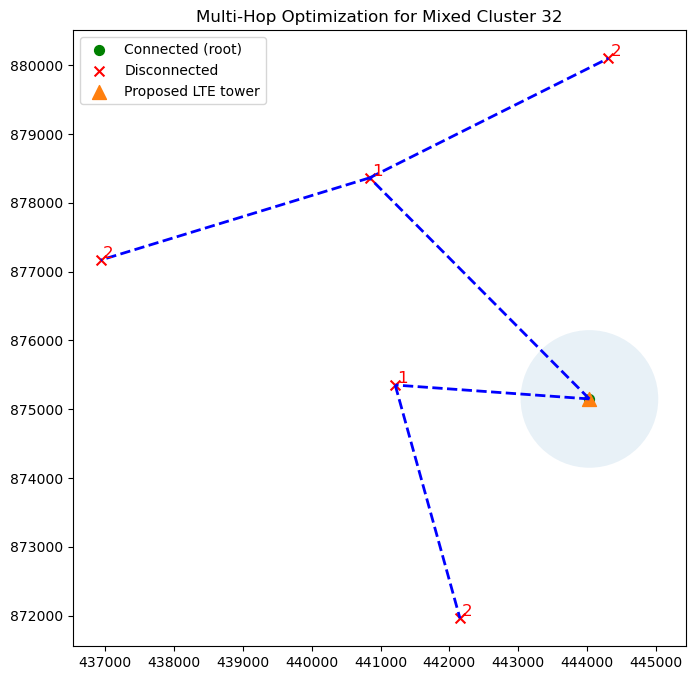

[cluster 33] Assigning tower to school 627
[cluster 33] cluster 33 is solved.


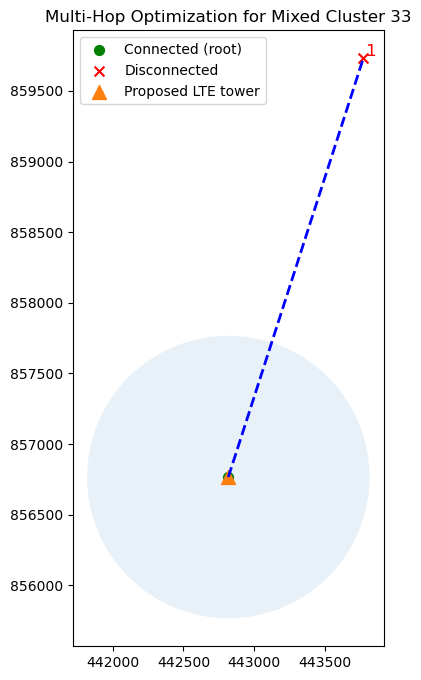

[cluster 34] Assigning tower to school 672
[cluster 34] cluster 34 is solved.


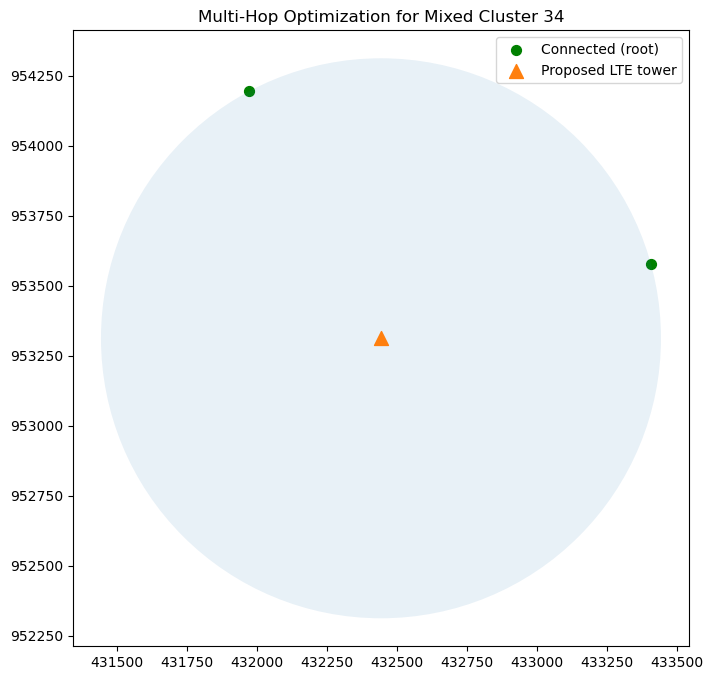

[cluster 35] Assigning tower to school 745
[cluster 35] cluster 35 is solved.


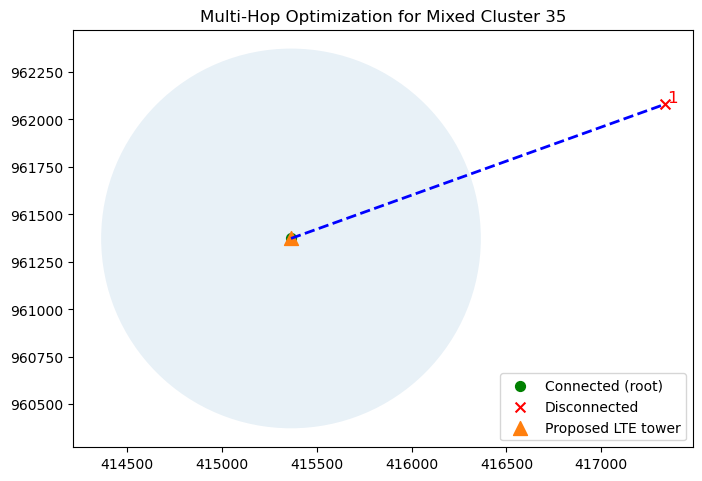

[cluster 36] Assigning tower to school 956
[cluster 36] cluster 36 is solved.


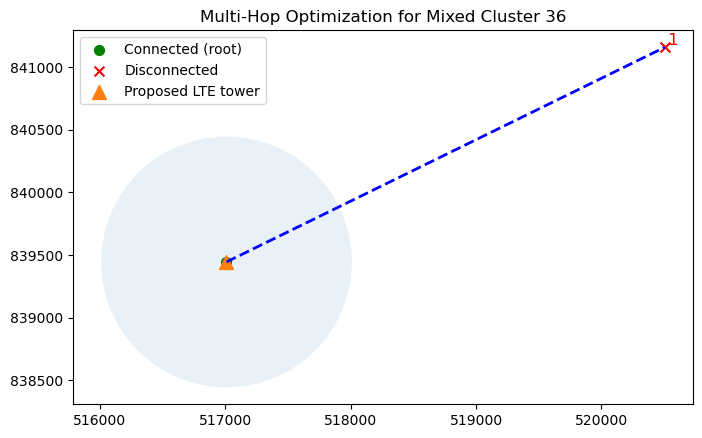

[cluster 37] Assigning tower to school 1026
[cluster 37] cluster 37 is solved.


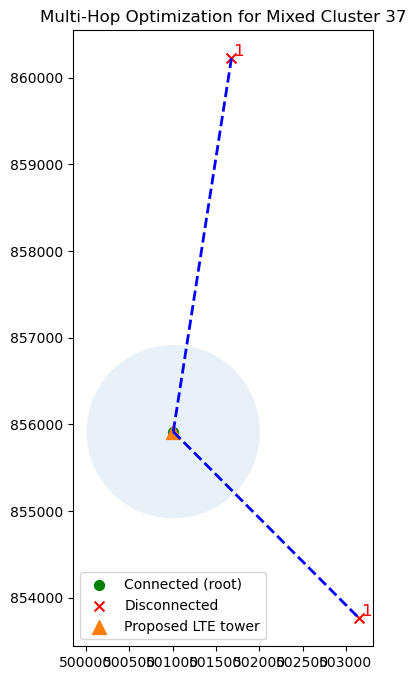

[cluster 38] Assigning tower to school 1028
[cluster 38] cluster 38 is solved.


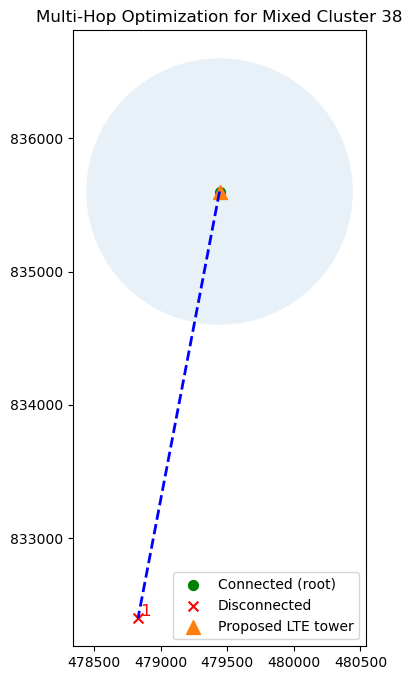

[cluster 39] Assigning tower to school 1033
[cluster 39] cluster 39 is solved.


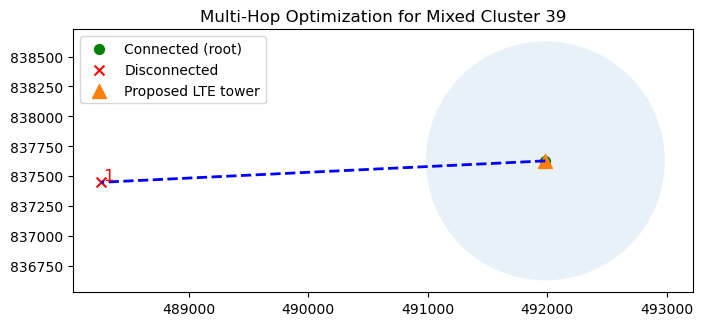

[cluster 40] Assigning tower to school 1552
[cluster 40] cluster 40 is solved.


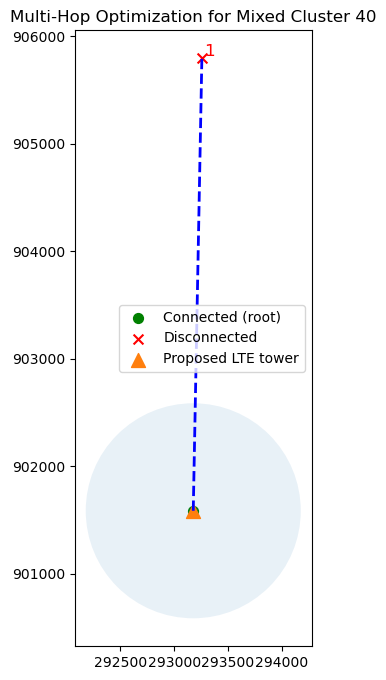

[cluster 41] Assigning tower to school 1555
[cluster 41] cluster 41 is solved.


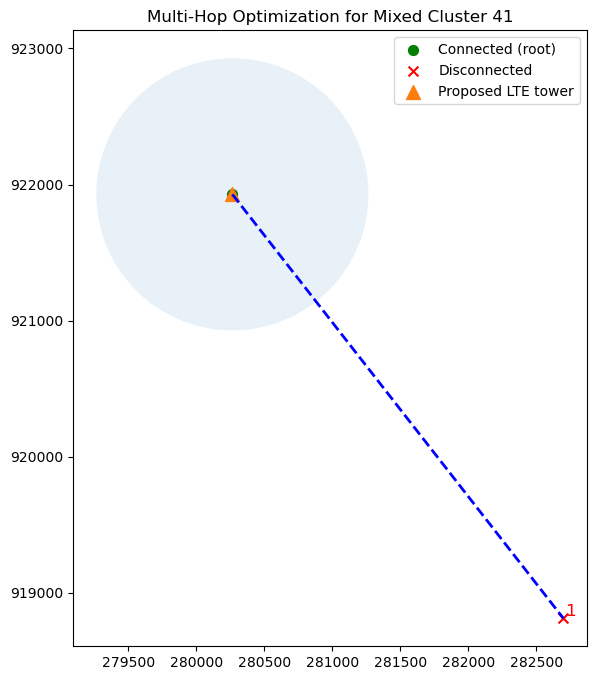

[cluster 42] Assigning tower to school 1920
[cluster 42] cluster 42 is solved.


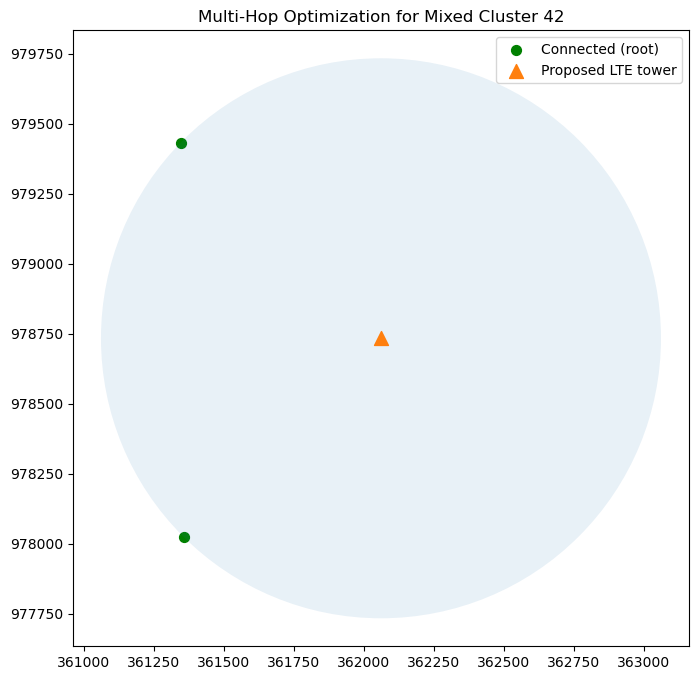

[cluster 43] Assigning tower to school 2008
[cluster 43] cluster 43 is solved.


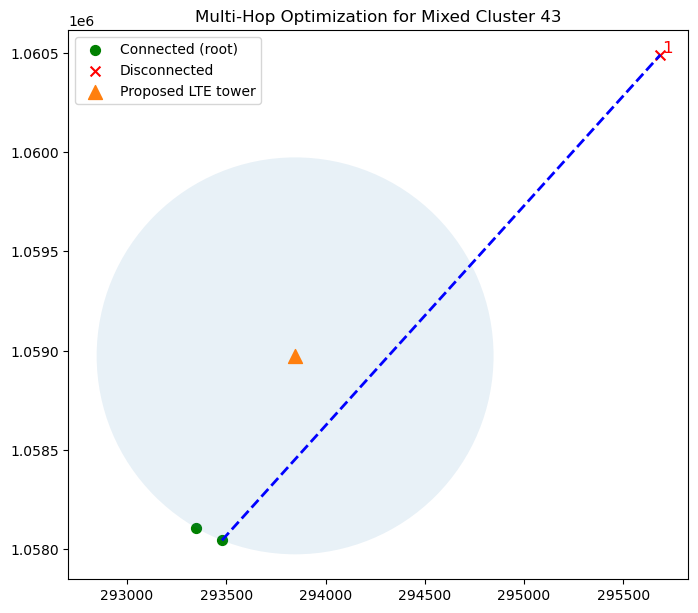

[cluster 44] Assigning tower to school 2073
[cluster 44] cluster 44 is solved.


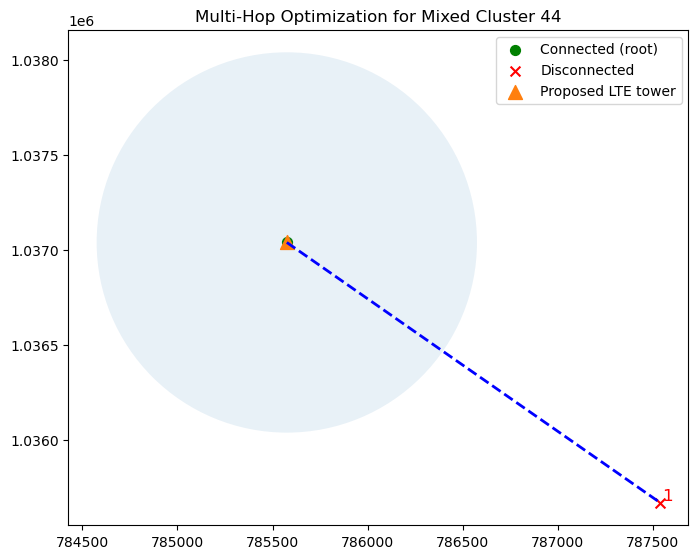

[cluster 45] Assigning tower to school 2024
[cluster 45] cluster 45 is solved.


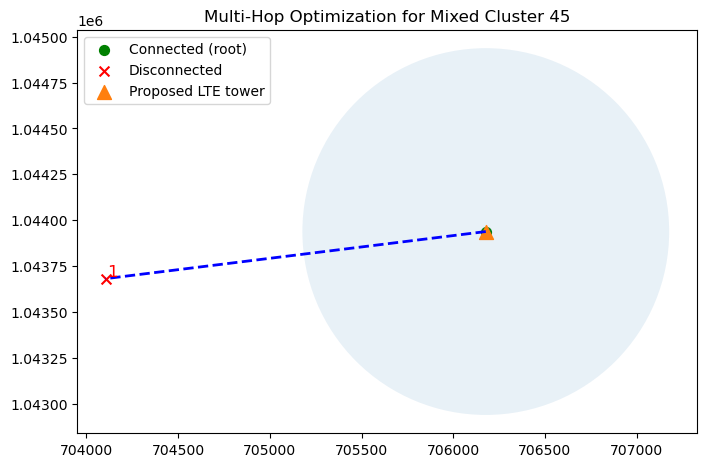

[cluster 46] Assigning tower to school 2040
[cluster 46] cluster 46 is solved.


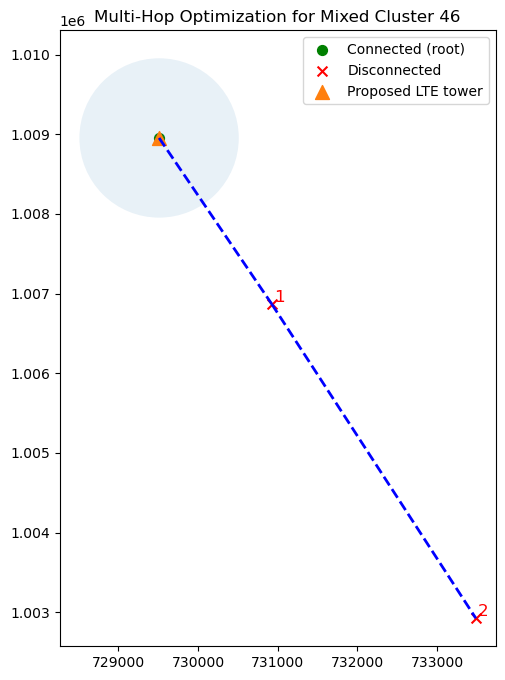

[cluster 47] Assigning tower to school 2067
[cluster 47] cluster 47 is solved.


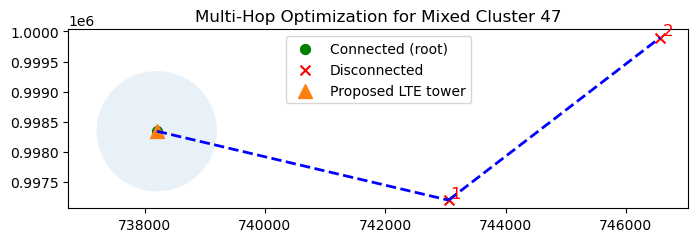

[cluster 48] Assigning tower to school 2051
Cluster 2051 is infeasible. Debugging constraints and variables...
[cluster 48] Assigning tower to school 2053
Cluster 2053 is infeasible. Debugging constraints and variables...
[cluster 48] Assigning tower to school 2054
Cluster 2054 is infeasible. Debugging constraints and variables...
[cluster 48] Assigning tower to school 2055
Cluster 2055 is infeasible. Debugging constraints and variables...
[cluster 48] Assigning tower to school 2056
Cluster 2056 is infeasible. Debugging constraints and variables...
[cluster 48] Assigning tower to school 2057
[cluster 48] cluster 48 is solved.


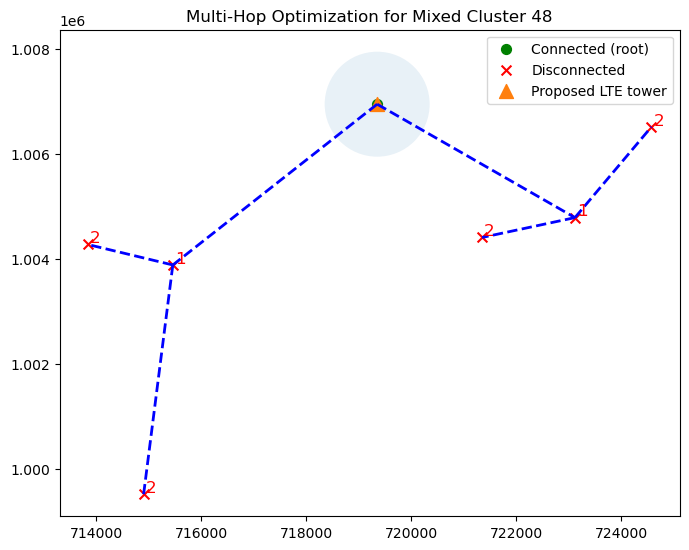

[cluster 49] Assigning tower to school 2068
[cluster 49] cluster 49 is solved.


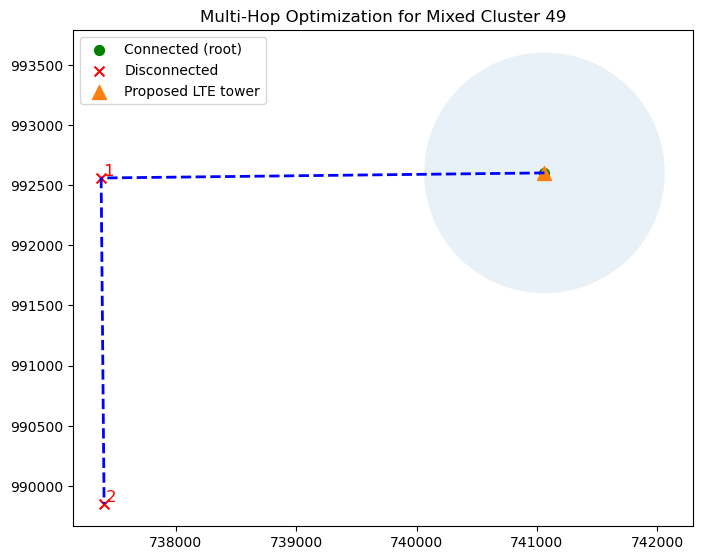

[cluster 50] Assigning tower to school 2070
[cluster 50] cluster 50 is solved.


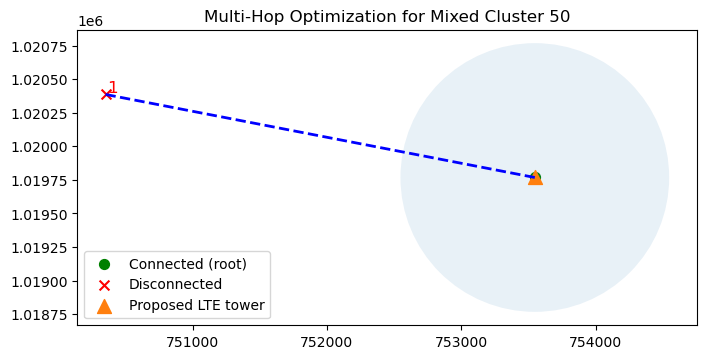

[cluster 51] Assigning tower to school 2074
[cluster 51] cluster 51 is solved.


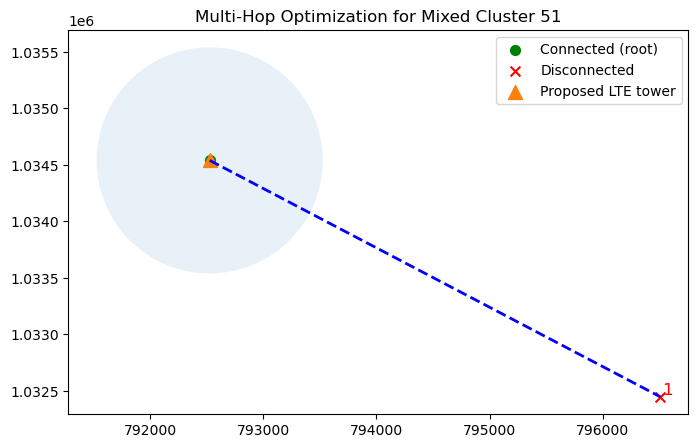

[cluster 52] Assigning tower to school 16
[cluster 52] cluster 52 is solved.


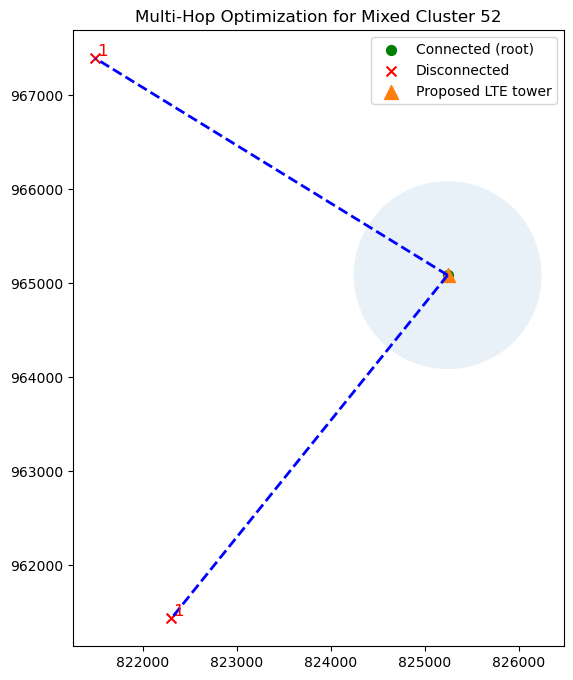

[cluster 53] Assigning tower to school 216
[cluster 53] cluster 53 is solved.


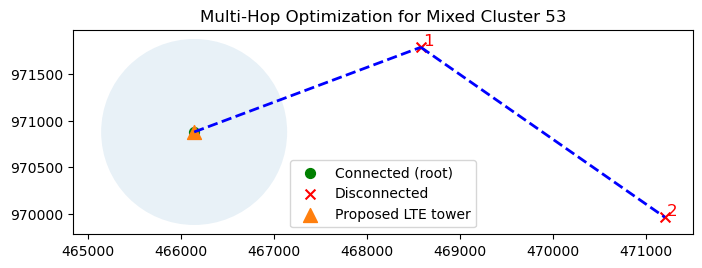

[cluster 54] Assigning tower to school 1120
Cluster 1120 is infeasible. Debugging constraints and variables...
[cluster 54] Assigning tower to school 1027
Cluster 1027 is infeasible. Debugging constraints and variables...
[cluster 54] Assigning tower to school 996
Cluster 996 is infeasible. Debugging constraints and variables...
[cluster 54] Assigning tower to school 997
Cluster 997 is infeasible. Debugging constraints and variables...
[cluster 54] Assigning tower to school 964
Cluster 964 is infeasible. Debugging constraints and variables...
[cluster 54] Assigning tower to school 965
Cluster 965 is infeasible. Debugging constraints and variables...
[cluster 54] Assigning tower to school 963
Cluster 963 is infeasible. Debugging constraints and variables...
[cluster 54] Assigning tower to school 966
Cluster 966 is infeasible. Debugging constraints and variables...
[cluster 54] Assigning tower to school 1003
Cluster 1003 is infeasible. Debugging constraints and variables...
[cluster 54] 

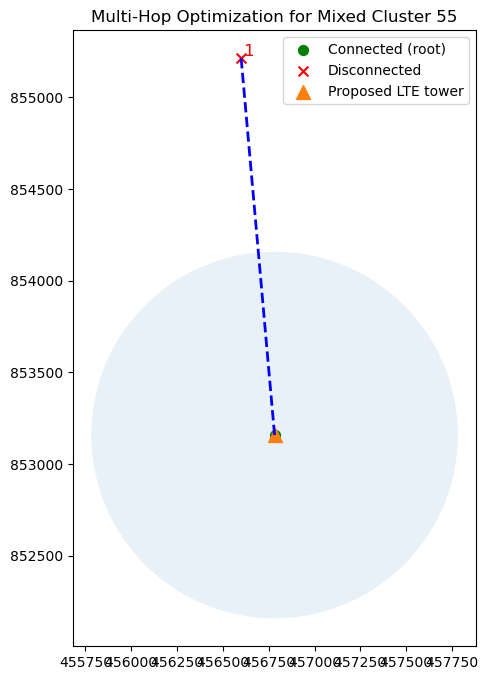

[cluster 56] Assigning tower to school 1060
Cluster 1060 is infeasible. Debugging constraints and variables...
[cluster 56] Assigning tower to school 1162
Cluster 1162 is infeasible. Debugging constraints and variables...
[cluster 56] Assigning tower to school 1163
Cluster 1163 is infeasible. Debugging constraints and variables...
[cluster 56] Assigning tower to school 972
Cluster 972 is infeasible. Debugging constraints and variables...
[cluster 56] Assigning tower to school 976
Cluster 976 is infeasible. Debugging constraints and variables...
[cluster 56] Assigning tower to school 1169
Cluster 1169 is infeasible. Debugging constraints and variables...
[cluster 56] Assigning tower to school 977
Cluster 977 is infeasible. Debugging constraints and variables...
[cluster 56] Assigning tower to school 1171
Cluster 1171 is infeasible. Debugging constraints and variables...
[cluster 56] Assigning tower to school 978
Cluster 978 is infeasible. Debugging constraints and variables...
[cluster 

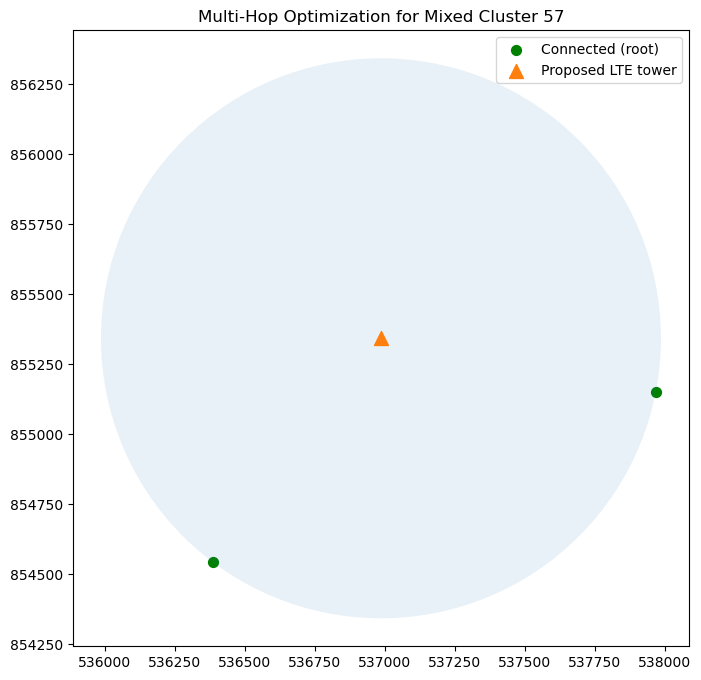

[cluster 58] Assigning tower to school 2179
Cluster 2179 is infeasible. Debugging constraints and variables...
[cluster 58] Assigning tower to school 2180
Cluster 2180 is infeasible. Debugging constraints and variables...
[cluster 58] Assigning tower to school 2181
Cluster 2181 is infeasible. Debugging constraints and variables...
[cluster 58] Assigning tower to school 2182
Cluster 2182 is infeasible. Debugging constraints and variables...
[cluster 58] Assigning tower to school 261
Cluster 261 is infeasible. Debugging constraints and variables...
[cluster 58] Assigning tower to school 265
Cluster 265 is infeasible. Debugging constraints and variables...
[cluster 58] Assigning tower to school 266
Cluster 266 is infeasible. Debugging constraints and variables...
[cluster 58] Assigning tower to school 267
Cluster 267 is infeasible. Debugging constraints and variables...
[cluster 58] Assigning tower to school 268
Cluster 268 is infeasible. Debugging constraints and variables...
[cluster 58

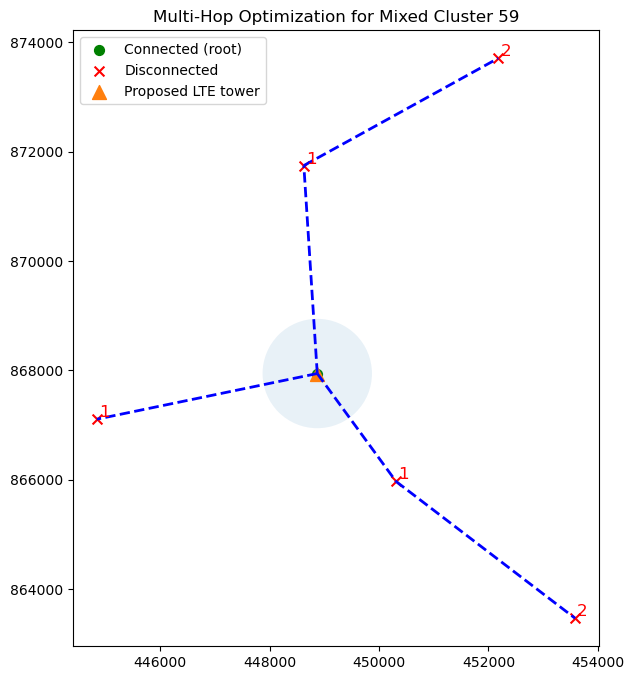

[cluster 60] Assigning tower to school 642
Cluster 642 is infeasible. Debugging constraints and variables...
[cluster 60] Assigning tower to school 645
Cluster 645 is infeasible. Debugging constraints and variables...
[cluster 60] Assigning tower to school 622
Cluster 622 is infeasible. Debugging constraints and variables...
[cluster 60] Assigning tower to school 623
Cluster 623 is infeasible. Debugging constraints and variables...
[cluster 60] Assigning tower to school 625
Cluster 625 is infeasible. Debugging constraints and variables...
[cluster 60] Assigning tower to school 1173
Cluster 1173 is infeasible. Debugging constraints and variables...
[cluster 61] Assigning tower to school 499
Cluster 499 is infeasible. Debugging constraints and variables...
[cluster 61] Assigning tower to school 501
Cluster 501 is infeasible. Debugging constraints and variables...
[cluster 61] Assigning tower to school 503
Cluster 503 is infeasible. Debugging constraints and variables...
[cluster 61] Assi

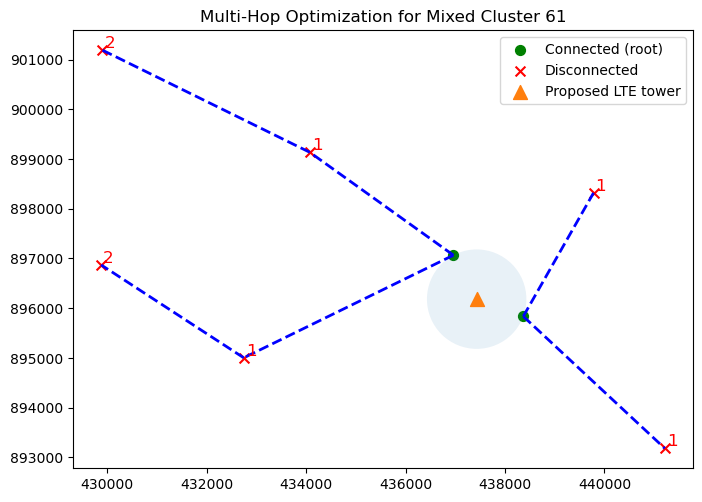

[cluster 62] Assigning tower to school 673
Cluster 673 is infeasible. Debugging constraints and variables...
[cluster 62] Assigning tower to school 836
Cluster 836 is infeasible. Debugging constraints and variables...
[cluster 62] Assigning tower to school 837
[cluster 62] cluster 62 is solved.


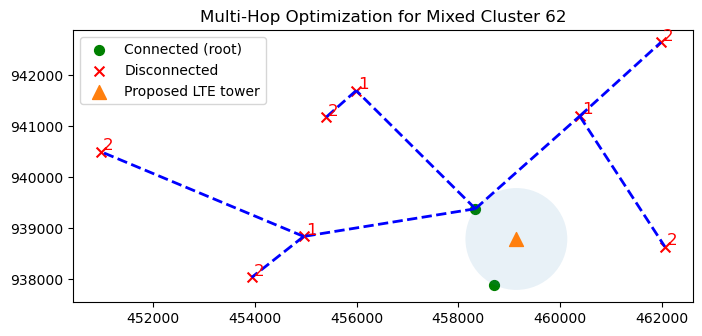

[cluster 63] Assigning tower to school 1211
[cluster 63] cluster 63 is solved.


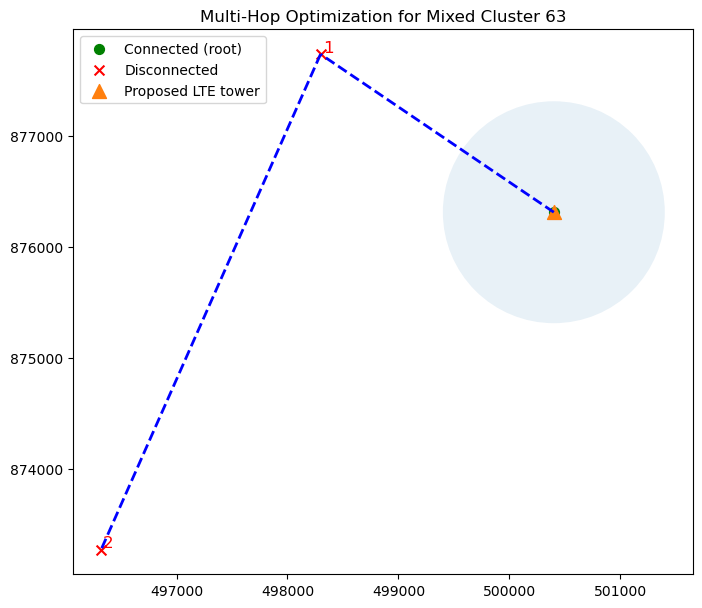

[cluster 64] Assigning tower to school 2188
Cluster 2188 is infeasible. Debugging constraints and variables...
[cluster 64] Assigning tower to school 2189
Cluster 2189 is infeasible. Debugging constraints and variables...
[cluster 64] Assigning tower to school 2190
Cluster 2190 is infeasible. Debugging constraints and variables...
[cluster 64] Assigning tower to school 2191
Cluster 2191 is infeasible. Debugging constraints and variables...
[cluster 64] Assigning tower to school 2192
Cluster 2192 is infeasible. Debugging constraints and variables...
[cluster 64] Assigning tower to school 2193
Cluster 2193 is infeasible. Debugging constraints and variables...
[cluster 64] Assigning tower to school 2195
Cluster 2195 is infeasible. Debugging constraints and variables...
[cluster 64] Assigning tower to school 667
Cluster 667 is infeasible. Debugging constraints and variables...
[cluster 64] Assigning tower to school 669
Cluster 669 is infeasible. Debugging constraints and variables...
[clus

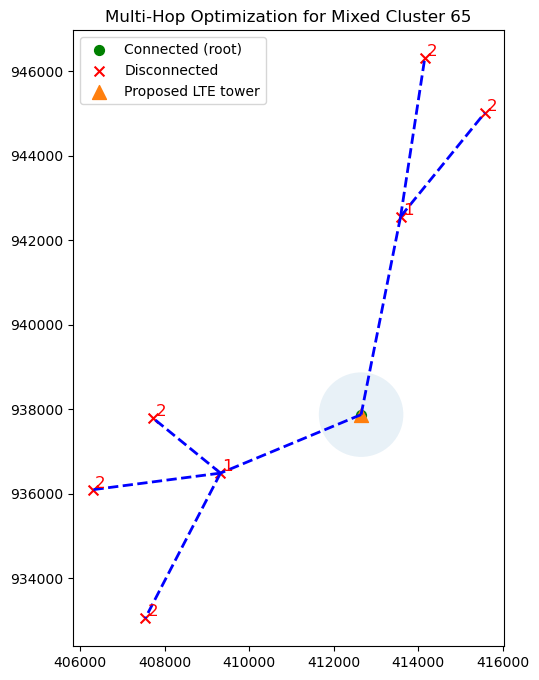

[cluster 66] Assigning tower to school 806
Cluster 806 is infeasible. Debugging constraints and variables...
[cluster 66] Assigning tower to school 807
Cluster 807 is infeasible. Debugging constraints and variables...
[cluster 66] Assigning tower to school 809
Cluster 809 is infeasible. Debugging constraints and variables...
[cluster 66] Assigning tower to school 1226
Cluster 1226 is infeasible. Debugging constraints and variables...
[cluster 66] Assigning tower to school 811
Cluster 811 is infeasible. Debugging constraints and variables...
[cluster 66] Assigning tower to school 814
Cluster 814 is infeasible. Debugging constraints and variables...
[cluster 66] Assigning tower to school 816
Cluster 816 is infeasible. Debugging constraints and variables...
[cluster 66] Assigning tower to school 817
Cluster 817 is infeasible. Debugging constraints and variables...
[cluster 66] Assigning tower to school 818
Cluster 818 is infeasible. Debugging constraints and variables...
[cluster 66] Assi

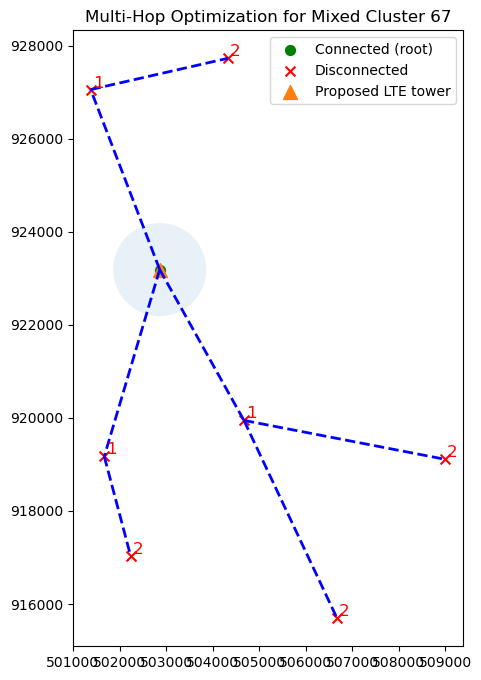

[cluster 68] Assigning tower to school 744
[cluster 68] cluster 68 is solved.


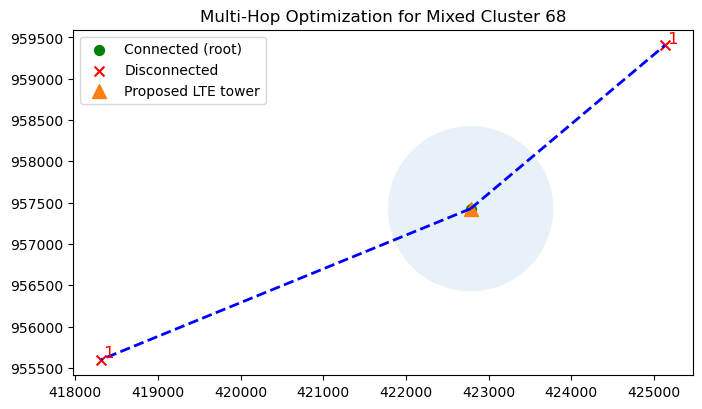

[cluster 69] Assigning tower to school 896
[cluster 69] cluster 69 is solved.


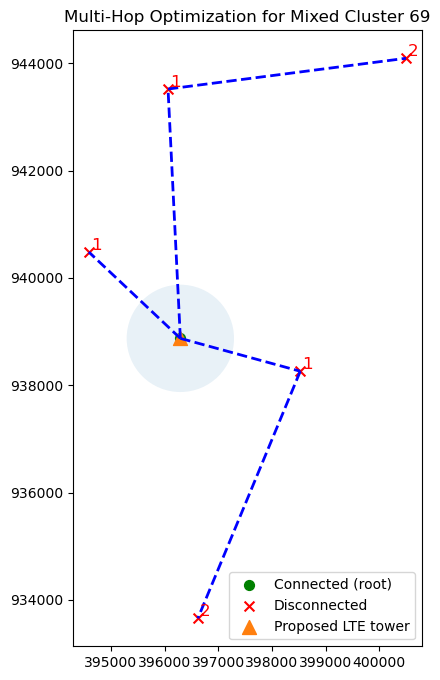

[cluster 70] Assigning tower to school 913
[cluster 70] cluster 70 is solved.


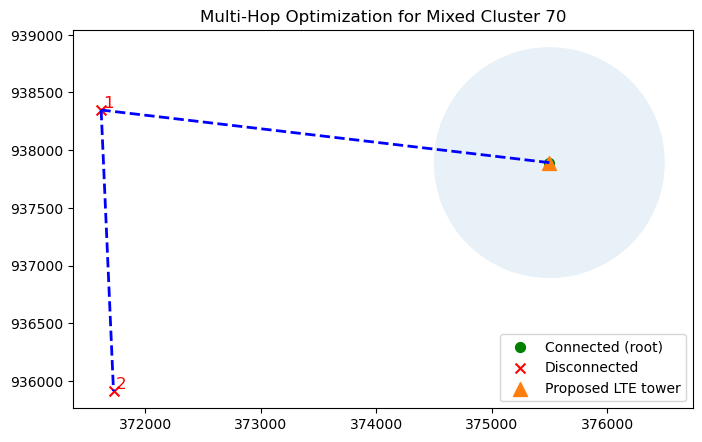

[cluster 71] Assigning tower to school 992
Cluster 992 is infeasible. Debugging constraints and variables...
[cluster 71] Assigning tower to school 960
Cluster 960 is infeasible. Debugging constraints and variables...
[cluster 71] Assigning tower to school 999
Cluster 999 is infeasible. Debugging constraints and variables...
[cluster 71] Assigning tower to school 1000
Cluster 1000 is infeasible. Debugging constraints and variables...
[cluster 71] Assigning tower to school 1001
Cluster 1001 is infeasible. Debugging constraints and variables...
[cluster 71] Assigning tower to school 1002
[cluster 71] cluster 71 is solved.


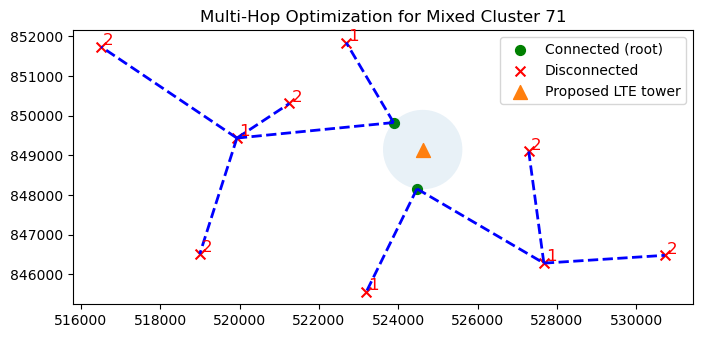

[cluster 72] Assigning tower to school 2114
Cluster 2114 is infeasible. Debugging constraints and variables...
[cluster 72] Assigning tower to school 2115
[cluster 72] cluster 72 is solved.


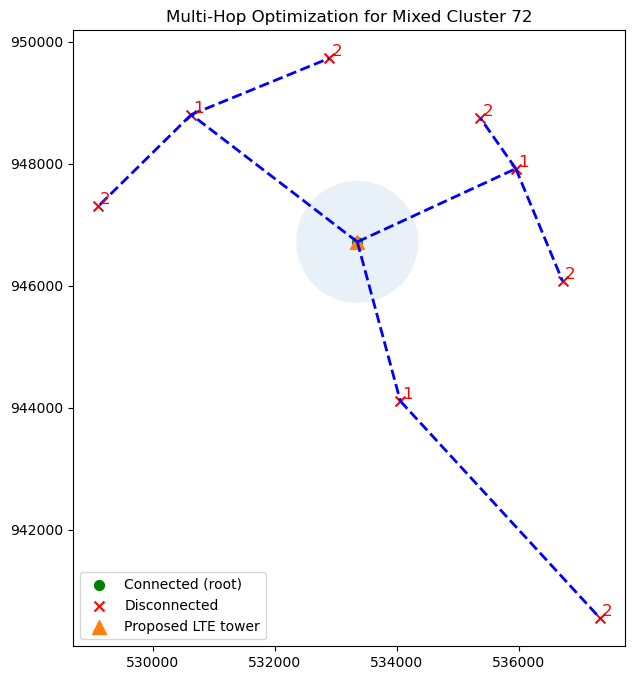

[cluster 73] Assigning tower to school 2082
[cluster 73] cluster 73 is solved.


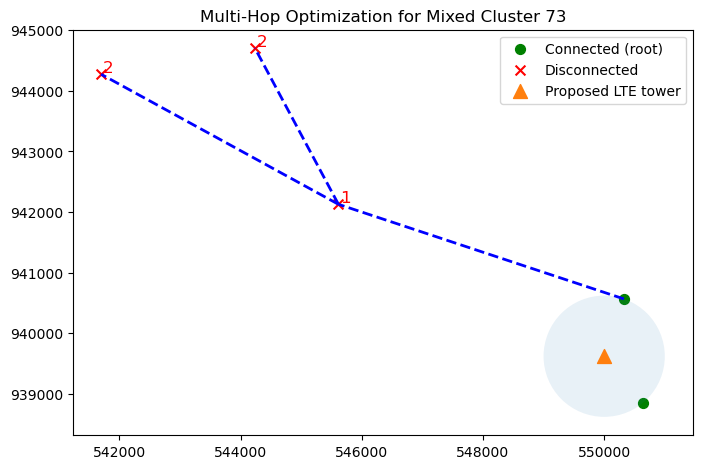

[cluster 74] Assigning tower to school 2120
[cluster 74] cluster 74 is solved.


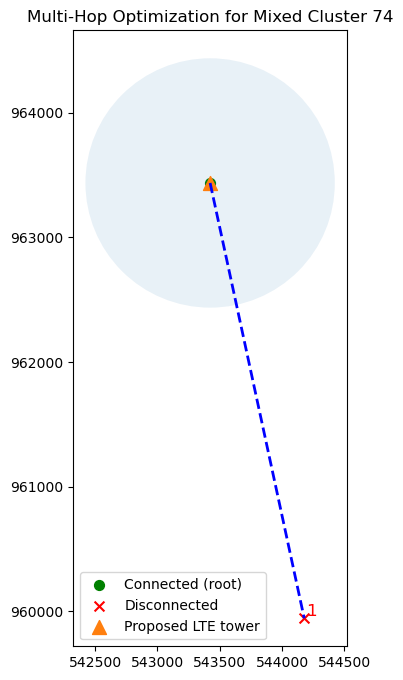

[cluster 75] Assigning tower to school 2125
[cluster 75] cluster 75 is solved.


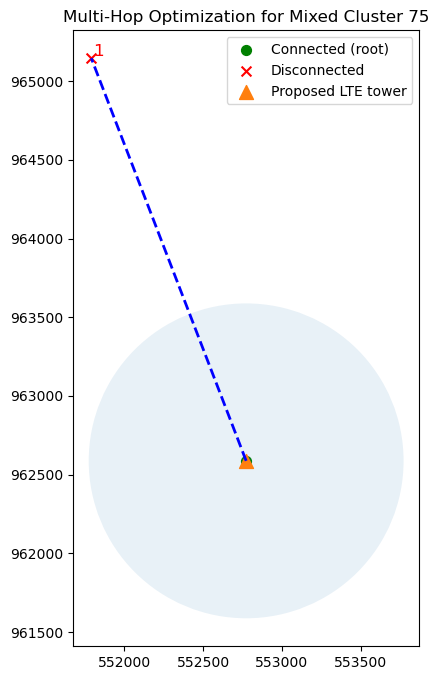

[cluster 76] Assigning tower to school 1235
Cluster 1235 is infeasible. Debugging constraints and variables...
[cluster 76] Assigning tower to school 1238
Cluster 1238 is infeasible. Debugging constraints and variables...
[cluster 76] Assigning tower to school 1241
Cluster 1241 is infeasible. Debugging constraints and variables...
[cluster 76] Assigning tower to school 1242
Cluster 1242 is infeasible. Debugging constraints and variables...
[cluster 76] Assigning tower to school 1243
Cluster 1243 is infeasible. Debugging constraints and variables...
[cluster 76] Assigning tower to school 1244
Cluster 1244 is infeasible. Debugging constraints and variables...
[cluster 76] Assigning tower to school 1245
Cluster 1245 is infeasible. Debugging constraints and variables...
[cluster 76] Assigning tower to school 1246
Cluster 1246 is infeasible. Debugging constraints and variables...
[cluster 76] Assigning tower to school 1247
Cluster 1247 is infeasible. Debugging constraints and variables...
[

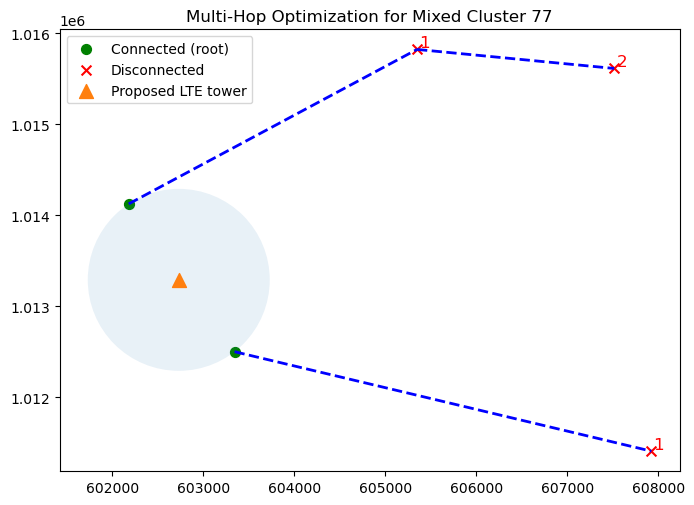

[cluster 78] Assigning tower to school 329
[cluster 78] cluster 78 is solved.


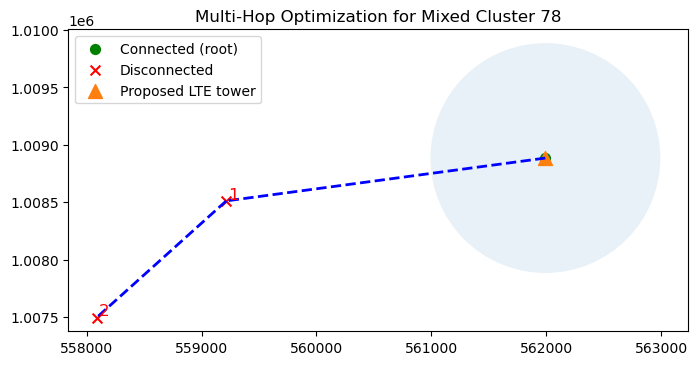

[cluster 79] Assigning tower to school 450
Cluster 450 is infeasible. Debugging constraints and variables...
[cluster 79] Assigning tower to school 451
Cluster 451 is infeasible. Debugging constraints and variables...
[cluster 79] Assigning tower to school 453
[cluster 79] cluster 79 is solved.


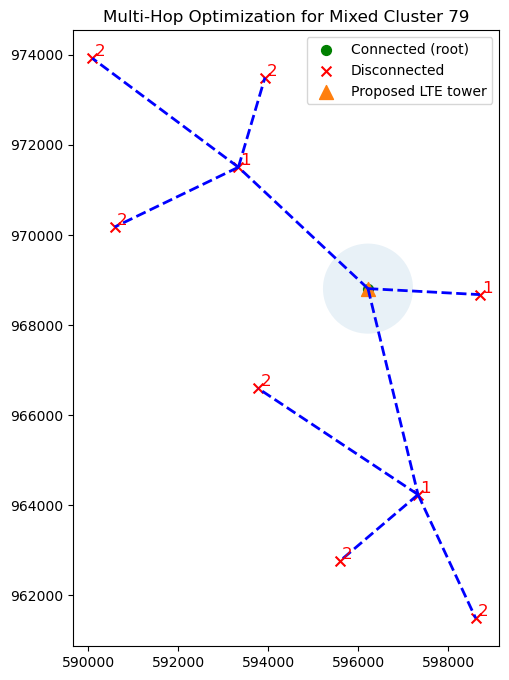

[cluster 80] Assigning tower to school 2028
Cluster 2028 is infeasible. Debugging constraints and variables...
[cluster 80] Assigning tower to school 2030
[cluster 80] cluster 80 is solved.


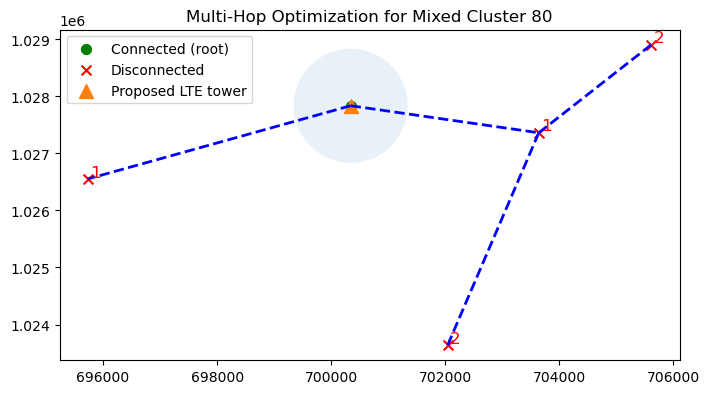

[cluster 81] Assigning tower to school 1824
Cluster 1824 is infeasible. Debugging constraints and variables...
[cluster 81] Assigning tower to school 1825
Cluster 1825 is infeasible. Debugging constraints and variables...
[cluster 81] Assigning tower to school 1826
Cluster 1826 is infeasible. Debugging constraints and variables...
[cluster 81] Assigning tower to school 1862
Cluster 1862 is infeasible. Debugging constraints and variables...
[cluster 81] Assigning tower to school 1863
Cluster 1863 is infeasible. Debugging constraints and variables...
[cluster 81] Assigning tower to school 1864
Cluster 1864 is infeasible. Debugging constraints and variables...
[cluster 81] Assigning tower to school 1832
Cluster 1832 is infeasible. Debugging constraints and variables...
[cluster 81] Assigning tower to school 1833
Cluster 1833 is infeasible. Debugging constraints and variables...
[cluster 81] Assigning tower to school 1834
Cluster 1834 is infeasible. Debugging constraints and variables...
[

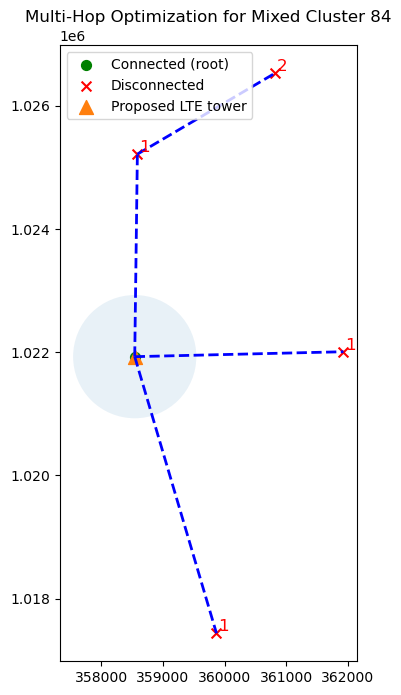

[cluster 85] Assigning tower to school 1841
[cluster 85] cluster 85 is solved.


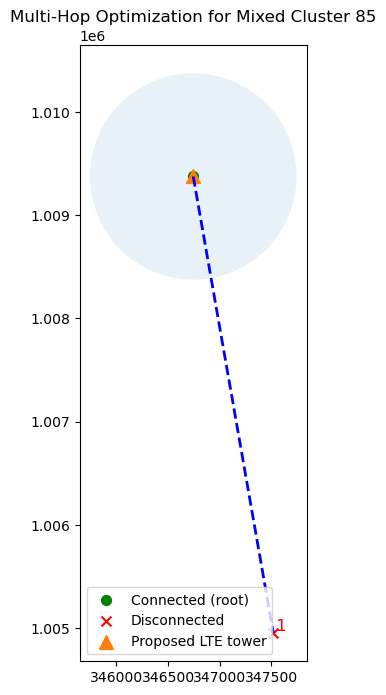

[cluster 86] Assigning tower to school 1904
[cluster 86] cluster 86 is solved.


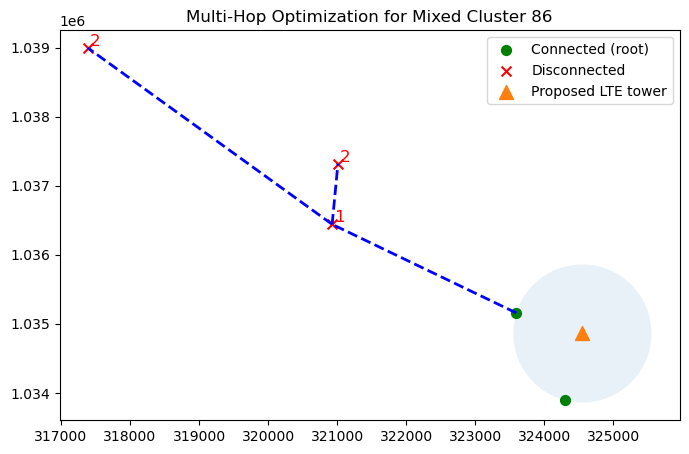

In [24]:
final_connected_with_tower = []
for cluster_idx, disconnected_cluster_info in enumerate(chain(all_disconnected_clusters, all_dropped_disconnected_clusters), start=1):
    cluster = filtered_schools_gdf.loc[disconnected_cluster_info['cluster_nodes']].copy()

    # Find all schools that are within default_tower_radius distance from each other
    close_schools = find_close_pairs(cluster)

    solution = None
    for school_idx in cluster.index.values:
        print(f"[cluster {cluster_idx}] Assigning tower to school {school_idx}")
        cluster_copy = cluster.copy()

        # Get the best tower placement nearby the current school (greedy, taking as many neighbouring schools as possible))
        tower_loc, connected_schools = get_greedy_tower_location(school_idx, close_schools, cluster_copy)

        # Set connected True for all schools that have been covered by the current tower placement
        cluster_copy.loc[connected_schools, 'CoveredByTower'] = True

        # Now solve the ILP for the current connected / not connected schools in the cluster
        solution = solve_mixed_connections_cluster(school_idx, cluster_copy)

        if solution is not None and (cluster_copy.index.isin(solution['to']) | cluster_copy['CoveredByTower']).all():
            # All schools are covered so this cluster is solved
            print(f"[cluster {cluster_idx}] cluster {cluster_idx} is solved.")
            break

    if solution is not None:
        final_connected_with_tower.append({
            "assignments_df": solution
        })
        # Make a plot of the solution
        plot_optimized_cluster(cluster_idx, cluster_copy, solution, tower_loc, default_tower_range)

# Summary and Consolidation of Optimization Results

This notebook presents a structured methodology to **analyze, classify, and optimize** the internet connectivity of schools in remote areas. The approach ensures **cost-effective** network expansion by leveraging existing cellular infrastructure and intelligent connectivity planning using long-distance point-to-point connections.

## Summary

This notebook covered the following topics:
### **1. Data Acquisition & Preprocessing**
- Two primary datasets were used:
  - **Giga School Mapping Data** (providing school locations and connectivity status)
  - **OpenCellID Data** (containing cellular tower locations and coverage)
- The datasets were cleaned, structured, and transformed into **GeoDataFrames** to facilitate geospatial analysis.

### **2. Clustering Schools Based on Geographic Proximity**
- Schools were grouped into clusters based on their geographical locations to ensure realistic connectivity solutions.
- Clustering was designed to prevent unnecessary links between schools that were too far apart.

### **3. Cluster Classification**
Each cluster was classified into one of the following categories:
1. **Connected Clusters** – All schools within the cluster already have internet access. **No action was needed for these clusters**
2. **Remote Standalone Schools** – A single school with no connectivity, requiring a dedicated solution such as a new **cellular tower nearby or a satellite connection**.
3. **Mixed-Connectivity Clusters** – Some schools have internet access while others do not. **A point-to-point network expansion strategy** was applied where possible, and for the leftover unconnected schools the **Disconnected Cluster** Strategy was applied.
4. **Disconnected Clusters** – No schools in the cluster have connectivity. **An optimization algorithm was used to determine the ideal placement of a new cellular tower.**

### **4. Optimizing School Connectivity**
- **Point-to-Point Connectivity Algorithm:**
  - Unconnected schools were linked to **nearby connected schools** using long-distance wireless extenders.
  - Connectivity was expanded while adhering to specific constraints:
    - A **maximum of 3 point-to-point peers per connected school**.
    - A **5 km maximum range per hop**.
    - A **3-hop limit** from the originally connected school.
  - If some of the schools could not be connected using this approach (infeasible ILP), they were labeled as part of a **disconnected cluster** and the **Cellular Tower Placement Optimization** algorithm was used for the remaining unconnected schools.

- **Cellular Tower Placement Optimization:**
  - For disconnected clusters, an **Integer Linear Programming (ILP) optimization model** was applied to determine the most **cost-effective placement of a new cellular tower**.
  - The model aimed to **maximize school coverage while minimizing infrastructure costs**.
  - Once a tower location was identified, additional point-to-point links were computed to extend coverage.

### **5. Results and Recommendations**
- The final output provided:
  - **Clusters successfully connected using point-to-point networks**.
  - **Clusters requiring a new cellular tower for optimal coverage**.
  - **Summary statistics** the following code block shows a summary of the statistics that the optimal solution returns.

### **Conclusion**
By leveraging **geospatial analysis, network optimization, and mathematical modeling**, this notebook presents a **scalable and cost-effective strategy** for extending internet connectivity to remote schools. The proposed methodology ensures that existing infrastructure is **maximally utilized** while **minimizing the need for new construction**. 

This approach can be **extended to other regions**, providing a replicable framework for improving digital access in underserved communities.


In [27]:
print(f"Total schools: {len(schools_df)}")
print(f"Connected schools that can not connect any disconnected school (no disconnected school in range): {len(schools_df) - len(filtered_schools_gdf)}")
print(f"Schools that are not connected: {(filtered_schools_gdf['Connected'] == False).sum()}")
print(f"Schools that are connected and potentially can connect unconnected school: {len(filtered_schools_gdf) - (filtered_schools_gdf['Connected'] == False).sum()}")
print("")
print("Clustering:")
print(f"Clusters with all schools disconnected: {len(all_disconnected_clusters)}")
print(f"Clusters with some schools are connected and some disconnected: {len(mixed_clusters)}")
print(f"Clusters with single element (we do not consider them in analysis): {len(clusters_all) - len(all_disconnected_clusters) - len(mixed_clusters) + len(clusters_disconnected_all) - len(all_dropped_disconnected_clusters)}")

print("")
print("Analysis:")

# Collect all schools in the "to" column from both mixed and final cluster results
all_to_schools = set()
all_to_schools_tower = set()

for cluster_result in chain(mixed_cluster_results, final_cluster_results):
    df_assignments = cluster_result["assignments_df"]
    all_to_schools.update(df_assignments["to"])

# Filter only those schools that are disconnected
disconnected_schools_in_to = [
    school for school in all_to_schools if not filtered_schools_gdf.loc[school, 'Connected']
]

# Convert to a DataFrame
df_disconnected_schools_in_to = pd.DataFrame(disconnected_schools_in_to, columns=["school_id"])

for cluster_result in final_connected_with_tower:
    df_assignments = cluster_result["assignments_df"]
    all_to_schools_tower.update(df_assignments["to"])


# Now, filter for final_connected_with_tower
disconnected_schools_with_tower = [
    school for school in all_to_schools_tower if not filtered_schools_gdf.loc[school, 'Connected']
]

# Convert to a DataFrame
df_disconnected_schools_with_tower = pd.DataFrame(disconnected_schools_with_tower, columns=["school_id"])


print(f"Total schools connected without using towers (from connected schools): {len(df_disconnected_schools_in_to)}")
print(f"Created towers: {len(final_connected_with_tower)}")

print(f"Total schools connected with using towers: {len(df_disconnected_schools_with_tower)}")

# List to store all connections
all_connections = []

# Extract from mixed_cluster_results, final_cluster_results, and final_connected_with_tower
for cluster_result in chain(mixed_cluster_results, final_cluster_results, final_connected_with_tower):
    df_assignments = cluster_result["assignments_df"]

    for _, row in df_assignments.iterrows():
        from_node = row["from"]
        to_node = row["to"]

        # Calculate distance using filtered_schools_gdf geometries
        if from_node in filtered_schools_gdf.index and to_node in filtered_schools_gdf.index:
            distance_meters = filtered_schools_gdf.loc[from_node, "geometry"].distance(
                filtered_schools_gdf.loc[to_node, "geometry"]
            )
            # Store the result
            all_connections.append([from_node, to_node, distance_meters])

# Convert to a DataFrame
df_all_connections = pd.DataFrame(all_connections, columns=["from", "to", "distance_meters"])
df_all_connections.rename(columns={"from": "from_school", "to": "to_school"}, inplace=True)

# Add school names by mapping from filtered_schools_df
df_all_connections["from_school_name"] = df_all_connections["from_school"].map(filtered_schools_gdf["school_name"])
df_all_connections["to_school_name"] = df_all_connections["to_school"].map(filtered_schools_gdf["school_name"])
df_all_connections.to_excel("final_connections.xlsx", index=False)
df_all_connections.head(5)

Total schools: 3171
Connected schools that can not connect any disconnected school (no disconnected school in range): 958
Schools that are not connected: 1312
Schools that are connected and potentially can connect unconnected school: 901

Clustering:
Clusters with all schools disconnected: 51
Clusters with some schools are connected and some disconnected: 73
Clusters with single element (we do not consider them in analysis): 94

Analysis:
Total schools connected without using towers (from connected schools): 625
Created towers: 75
Total schools connected with using towers: 172


from_school  to_school  distance_meters           from_school_name  \
0          6.0        4.0      2290.123125           ESC. RIO TUQUEZA   
1          6.0        5.0      3674.390368           ESC. RIO TUQUEZA   
2          9.0       10.0      3595.741467  C.E.B.G. OCTAVIO CEBALLOS   
3         21.0       20.0      1092.226601           ESC. BUENA VISTA   
4         21.0       22.0      3557.114297           ESC. BUENA VISTA   

            to_school_name  
0       ESC. BAJO CHIQUITO  
1           ESC. LA CALETA  
2              ESC. ARMILA  
3  ESC. SALTO TRES PIEDRAS  
4          ESC. RIO BONITO